In [1]:
import re
file_path =  '/Users/ioann/iemocap/IEMOCAP_full_release/Session1/dialog/EmoEvaluation/Ses01F_impro01.txt'
useful_regex = re.compile(r'\[.+\]\n', re.IGNORECASE)
with open(file_path) as f:
    file_content = f.read()
    
info_lines = re.findall(useful_regex, file_content)

In [2]:
import os


info_line = re.compile(r'\[.+\]\n', re.IGNORECASE)

start_times, end_times, wav_file_names, emotions, vals, acts, doms = [], [], [], [], [], [], []

for sess in range(1, 6):
    emo_evaluation_dir = '/Users/ioann/iemocap/IEMOCAP_full_release/Session{}/dialog/EmoEvaluation/'.format(sess)
    evaluation_files = [l for l in os.listdir(emo_evaluation_dir) if 'Ses' in l]
    for file in evaluation_files:
        with open(emo_evaluation_dir + file) as f:
            content = f.read()
        info_lines = re.findall(info_line, content)
        for line in info_lines[1:]:  # the first line is a header
            start_end_time, wav_file_name, emotion, val_act_dom = line.strip().split('\t')
            start_time, end_time = start_end_time[1:-1].split('-')
            val, act, dom = val_act_dom[1:-1].split(',')
            val, act, dom = float(val), float(act), float(dom)
            start_time, end_time = float(start_time), float(end_time)
            start_times.append(start_time)
            end_times.append(end_time)
            wav_file_names.append(wav_file_name)
            emotions.append(emotion)
            vals.append(val)
            acts.append(act)
            doms.append(dom)

In [3]:
import pandas as pd

df_iemocap = pd.DataFrame(columns=['start_time', 'end_time', 'wav_file', 'emotion', 'val', 'act', 'dom'])

df_iemocap['start_time'] = start_times
df_iemocap['end_time'] = end_times
df_iemocap['wav_file'] = wav_file_names
df_iemocap['emotion'] = emotions
df_iemocap['val'] = vals
df_iemocap['act'] = acts
df_iemocap['dom'] = doms

df_iemocap.tail()

,start_time,end_time,wav_file,emotion,val,act,dom
10034,236.57,244.83,Ses05M_script03_2_M041,ang,1.0,4.5,5.0
10035,244.84,246.58,Ses05M_script03_2_M042,ang,1.0,4.5,4.5
10036,246.59,248.83,Ses05M_script03_2_M043,ang,1.5,4.0,4.5
10037,255.86,260.33,Ses05M_script03_2_M044,ang,1.0,5.0,5.0
10038,260.34,266.35,Ses05M_script03_2_M045,ang,1.0,5.0,5.0


In [4]:
#Now that the labels have been extracted, we'll use df_iemocap.csv to split the original wav files into multiple frames
# Try for one file first
import librosa
import os
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as ms
from tqdm import tqdm
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display

import IPython.display
import librosa.display
ms.use('seaborn-muted')
%matplotlib inline

In [5]:
#into a csv
df_iemocap.to_csv('/Users/ioann/df_iemocap.csv', index=False)

In [6]:
import pandas as pd
import math

labels_df = pd.read_csv('/Users/ioann/df_iemocap.csv')
iemocap_dir = '/Users/ioann/iemocap/IEMOCAP_full_release/'

In [7]:
#build audio vectors
sr = 44100
audio_vectors = {}
for sess in (range(1, 3)): 
    wav_file_path = '{}Session{}/dialog/wav/'.format(iemocap_dir, sess)
    orig_wav_files = os.listdir(wav_file_path)
    for orig_wav_file in tqdm(orig_wav_files):
        try:
            orig_wav_vector, _sr = librosa.load(wav_file_path + orig_wav_file, sr=sr)
            orig_wav_file, file_format = orig_wav_file.split('.')
            for index, row in labels_df[labels_df['wav_file'].str.contains(orig_wav_file)].iterrows():
                start_time, end_time, truncated_wav_file_name, emotion, val, act, dom = row['start_time'], row['end_time'], row['wav_file'], row['emotion'], row['val'], row['act'], row['dom']
                start_frame = math.floor(start_time * sr)
                end_frame = math.floor(end_time * sr)
                truncated_wav_vector = orig_wav_vector[start_frame:end_frame + 1]
                audio_vectors[truncated_wav_file_name] = truncated_wav_vector
        except:
            print('An exception occured for {}'.format(orig_wav_file))
    with open('/Users/ioann/audio_vectors_{}.pkl'.format(sess), 'wb') as f:
        pickle.dump(audio_vectors, f)

 26%|██▌       | 8/31 [01:29<04:05, 10.66s/it]

An exception occured for Ses02F_script01_1.pk


100%|██████████| 31/31 [06:02<00:00, 13.25s/it]


In [8]:
#build audio vectors
sr = 44100
audio_vectors = {}
for sess in (range(3, 5)):  # using one session due to memory constraint, can replace [5] with range(1, 6)
    wav_file_path = '{}Session{}/dialog/wav/'.format(iemocap_dir, sess)
    orig_wav_files = os.listdir(wav_file_path)
    for orig_wav_file in tqdm(orig_wav_files):
        try:
            orig_wav_vector, _sr = librosa.load(wav_file_path + orig_wav_file, sr=sr)
            orig_wav_file, file_format = orig_wav_file.split('.')
            for index, row in labels_df[labels_df['wav_file'].str.contains(orig_wav_file)].iterrows():
                start_time, end_time, truncated_wav_file_name, emotion, val, act, dom = row['start_time'], row['end_time'], row['wav_file'], row['emotion'], row['val'], row['act'], row['dom']
                start_frame = math.floor(start_time * sr)
                end_frame = math.floor(end_time * sr)
                truncated_wav_vector = orig_wav_vector[start_frame:end_frame + 1]
                audio_vectors[truncated_wav_file_name] = truncated_wav_vector
        except:
            print('An exception occured for {}'.format(orig_wav_file))
    with open('/Users/ioann/audio_vectors_{}.pkl'.format(sess), 'wb') as f:
        pickle.dump(audio_vectors, f)

100%|██████████| 30/30 [06:07<00:00, 12.79s/it]


In [9]:
#build audio vectors
sr = 44100
audio_vectors = {}
for sess in [5]:  # using one session due to memory constraint, can replace [5] with range(1, 6)
    wav_file_path = '{}Session{}/dialog/wav/'.format(iemocap_dir, sess)
    orig_wav_files = os.listdir(wav_file_path)
    for orig_wav_file in tqdm(orig_wav_files):
        try:
            orig_wav_vector, _sr = librosa.load(wav_file_path + orig_wav_file, sr=sr)
            orig_wav_file, file_format = orig_wav_file.split('.')
            for index, row in labels_df[labels_df['wav_file'].str.contains(orig_wav_file)].iterrows():
                start_time, end_time, truncated_wav_file_name, emotion, val, act, dom = row['start_time'], row['end_time'], row['wav_file'], row['emotion'], row['val'], row['act'], row['dom']
                start_frame = math.floor(start_time * sr)
                end_frame = math.floor(end_time * sr)
                truncated_wav_vector = orig_wav_vector[start_frame:end_frame + 1]
                audio_vectors[truncated_wav_file_name] = truncated_wav_vector
        except:
            print('An exception occured for {}'.format(orig_wav_file))
    with open('/Users/ioann/audio_vectors_{}.pkl'.format(sess), 'wb') as f:
        pickle.dump(audio_vectors, f)

100%|██████████| 31/31 [06:22<00:00, 12.99s/it]


In [10]:
emotion_dict = {'ang': 'n',
                'hap': 'p',
                'exc': 'p',
                'sad': 'n',
                'fru': 'n',
                'fea': 'n',
                'sur': 'p',
                'neu': 'p',
                'xxx': 'oth',
                'oth': 'oth'}
data_dir = '/Users/ioann/'
labels_path = '{}df_iemocap.csv'.format(data_dir)
audio_vectors_path = '{}audio_vectors_'.format(data_dir)

In [11]:
columns = ['wav_file', 'label', 'feature_mfccs']
df_features_m = pd.DataFrame(columns=columns)

In [12]:
labels_df = pd.read_csv(labels_path)

for sess in (range(1, 6)):
        audio_vectors = pickle.load(open('{}{}.pkl'.format(audio_vectors_path, sess), 'rb'))
        for index, row in tqdm(labels_df[labels_df['wav_file'].str.contains('Ses0{}'.format(sess))].iterrows()):           
            try:
                wav_file_name = row['wav_file']
                label = emotion_dict[row['emotion']]
                y = audio_vectors[wav_file_name]

                feature_list = [wav_file_name, label]
                # wav_file, label
                data = librosa.effects.pitch_shift(y=y, 
                                      sr=sr, n_steps=2 * 2*(np.random.uniform()), 
                                      bins_per_octave=12)
               # mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
                mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40).T,axis=0) 

               
                #feature_list.append(np.mean(mfccs))  # rmse_mean
                feature_list.append(mfccs)
               

                

               
                
                df_features_m = df_features_m.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
            except:
                print('Some exception occured')


770it [03:54,  2.72it/s]

Some exception occured


1819it [08:48,  2.58it/s]
1811it [09:01,  4.20it/s]
1222it [05:53,  3.43it/s]

Some exception occured


2136it [10:25,  3.05it/s]
2103it [10:05,  5.64it/s]
2170it [09:55,  3.76it/s]


In [13]:
df3 = pd.DataFrame(df_features_m['feature_mfccs'].values.tolist())
df3
new=df_features_m.drop('feature_mfccs', 1)
newdf = pd.concat([new,df3], axis=1)
newdf

,wav_file,label,0,1,2,3,4,5,6,7,...,30,31,32,33,34,35,36,37,38,39
0,Ses01F_impro01_F000,p,-524.699433,156.781896,-46.480218,46.525830,9.022199,-12.766758,21.525594,-11.940674,...,3.900517,2.109329,3.578267,-0.733077,0.438011,-0.123428,-1.850812,1.934408,-0.031259,-1.914728
1,Ses01F_impro01_F001,p,-557.610687,172.858331,-21.808400,8.885391,26.234351,-5.373108,11.168930,3.739676,...,0.716632,0.604290,-0.449535,-0.099498,2.316654,2.224158,2.884833,3.038857,-2.115292,-2.740096
2,Ses01F_impro01_F002,p,-558.770972,185.330174,-38.221451,22.879543,18.858484,-15.227420,16.688347,0.256739,...,1.816402,1.467596,2.163130,3.251691,0.720997,0.302528,-0.614802,-2.377428,0.152498,1.586046
3,Ses01F_impro01_F003,oth,-526.482061,165.403830,-20.296760,20.994315,33.703021,-8.659728,6.961069,3.305663,...,-0.345397,2.509199,3.969619,0.575998,0.484325,3.421567,3.818967,1.450888,-1.010877,-0.105927
4,Ses01F_impro01_F004,oth,-461.586534,152.142613,-24.089382,22.405067,27.986986,-8.544526,-1.318120,-11.653250,...,1.900276,-0.093500,0.365691,3.032068,3.008591,1.393306,0.265074,1.209712,2.720181,2.381329
5,Ses01F_impro01_F005,p,-420.344880,153.939926,-21.221131,18.940197,6.143656,-15.640639,7.313545,-10.395848,...,2.615842,-1.413713,2.189429,3.734030,3.299075,4.307362,2.975783,2.454585,1.731427,0.220436
6,Ses01F_impro01_F006,n,-368.500637,164.878801,-23.668154,-5.211489,25.793473,-5.306778,-3.176753,4.421050,...,-2.619476,1.749539,2.275468,0.854076,2.837430,4.218750,3.893570,3.093397,1.269687,1.117534
7,Ses01F_impro01_F007,n,-436.219310,150.175568,-23.275061,4.531827,22.397548,-6.205895,2.955328,-2.724705,...,-0.476941,-0.053708,-0.980315,-0.130216,1.478547,1.056642,0.759494,0.712014,0.310727,0.660825
8,Ses01F_impro01_F008,n,-400.098804,181.100895,-51.846364,18.351225,25.325297,-22.867127,1.954922,-1.932408,...,0.315659,-1.656059,0.967293,3.599207,0.913685,-0.380347,-0.872402,1.361650,3.227774,0.716901
9,Ses01F_impro01_F009,n,-471.406158,156.544158,-29.516037,7.586400,20.570546,-9.838308,7.867089,0.812676,...,0.698054,1.306943,1.003158,2.352323,3.112504,2.413631,1.218161,0.627193,2.477480,3.298729


In [14]:
columns = ['wav_file', 'label', 'feature']
df_features = pd.DataFrame(columns=columns)

In [15]:
labels_df = pd.read_csv(labels_path)

for sess in (range(1, 6)):
        audio_vectors = pickle.load(open('{}{}.pkl'.format(audio_vectors_path, sess), 'rb'))
        for index, row in tqdm(labels_df[labels_df['wav_file'].str.contains('Ses0{}'.format(sess))].iterrows()):           
            try:
                wav_file_name = row['wav_file']
                label = emotion_dict[row['emotion']]
                y = audio_vectors[wav_file_name]

                feature_list = [wav_file_name, label]  # wav_file, label
                
               # mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
                mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T,axis=0) 

               
                #feature_list.append(np.mean(mfccs))  # rmse_mean
                feature_list.append(mfccs)
               

                

               
                
                df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
            except:
                print('Some exception occured')


770it [00:15, 41.33it/s]

Some exception occured


1819it [00:36, 50.01it/s]
1811it [00:37, 47.81it/s]
1222it [00:24, 46.23it/s]

Some exception occured


2136it [00:43, 47.34it/s]
2103it [00:43, 48.76it/s]
2170it [00:44, 53.48it/s]


In [16]:
df2 = pd.DataFrame(df_features['feature'].values.tolist())
df2

#new_df = pd.concat([newdf,df2], axis=1)
#new_df

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-509.126997,181.965860,-48.599549,31.576114,32.012172,-21.222346,18.036352,4.219425,-12.454106,13.210400,...,-1.538607,2.361050,1.754320,1.556140,5.038047,2.334538,2.539351,5.077994,1.888022,0.402842
1,-516.757101,166.037926,-13.698110,7.455778,24.127481,-5.943733,8.448324,6.310700,-8.912027,6.515647,...,-0.200320,-0.469727,-0.599042,-1.689963,-0.042121,2.508860,2.382482,2.270472,0.708341,-1.324735
2,-535.808389,197.637881,-35.971572,16.028582,27.252961,-17.289227,12.078187,6.596235,-9.104317,9.304528,...,-0.805395,1.045605,0.227568,-0.231600,2.007883,1.608188,2.511622,3.101419,-0.276906,-1.303641
3,-499.505437,173.583604,-26.196286,18.929305,35.394134,-10.336557,5.948212,3.568846,-12.046869,7.196558,...,-2.648540,0.256012,2.905106,0.806051,1.458800,3.587927,3.186033,1.861609,-0.167564,-0.764474
4,-430.813999,159.862295,-15.155569,11.889576,36.357437,1.025977,0.410147,-2.455916,-13.638808,-3.154461,...,-0.761237,1.874628,3.201370,1.396090,0.352647,0.841803,2.117443,2.855314,1.949633,1.237270
5,-386.503557,153.880057,-8.654504,11.462919,17.005921,-13.288454,3.486613,2.020962,-12.496160,-4.236066,...,-3.797975,1.039531,2.594824,1.138751,2.050575,1.679837,1.086065,1.729483,1.243465,1.516248
6,-338.679136,167.576578,-23.725968,-4.789725,25.580598,-6.741570,-4.581353,2.351062,-8.508468,-5.835905,...,-1.393701,2.189362,2.349536,0.781537,2.358782,3.684598,3.777222,3.235100,1.707252,1.858535
7,-411.708022,166.322311,-27.537525,5.647182,26.333488,-7.406942,5.228053,0.618157,-13.344606,0.691763,...,-1.476885,0.076237,-0.252111,-0.830246,0.461917,0.633769,0.435840,0.628173,0.029110,-0.212034
8,-364.805749,181.675440,-37.499601,5.804351,33.771206,-14.981616,-6.293604,2.465651,-8.561474,-1.129350,...,-1.283447,0.418868,-1.965341,-3.290352,-0.378126,0.940950,1.865115,1.188642,-0.756106,0.850033
9,-438.489636,160.395622,-24.566140,4.215405,23.486020,-8.647269,5.627794,4.042671,-10.475144,3.386079,...,-1.455696,-0.133780,-0.066850,-0.594847,0.921930,2.700348,3.346706,1.956133,0.429507,1.637339


In [17]:
columns = ['wav_file', 'label', 'noise']
df_features_noise = pd.DataFrame(columns=columns)

In [18]:
labels_df = pd.read_csv(labels_path)

for sess in (range(1, 6)):
        audio_vectors = pickle.load(open('{}{}.pkl'.format(audio_vectors_path, sess), 'rb'))
        for index, row in tqdm(labels_df[labels_df['wav_file'].str.contains('Ses0{}'.format(sess))].iterrows()):           
            try:
                wav_file_name = row['wav_file']
                label = emotion_dict[row['emotion']]
                y = audio_vectors[wav_file_name]

                feature_list = [wav_file_name, label]
                # wav_file, label
                data = y + 0.005*np.random.uniform()*np.amax(y)
               # mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
                mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40).T,axis=0) 

               
                #feature_list.append(np.mean(mfccs))  # rmse_mean
                feature_list.append(mfccs)
               

                

               
                
                df_features_noise = df_features_noise.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
            except:
                print('Some exception occured')

768it [00:16, 38.74it/s]

Some exception occured


1819it [00:37, 48.57it/s]
1811it [00:38, 53.58it/s]
1218it [00:24, 46.45it/s]

Some exception occured


2136it [00:43, 48.98it/s]
2103it [00:45, 46.08it/s]
2170it [00:45, 48.19it/s]


In [19]:
df4 = pd.DataFrame(df_features_noise['noise'].values.tolist())
df4=df4[:10037]
new_df = pd.concat([newdf,df2,df4], axis=1)
new_df


,wav_file,label,0,1,2,3,4,5,6,7,...,30,31,32,33,34,35,36,37,38,39
0,Ses01F_impro01_F000,p,-524.699433,156.781896,-46.480218,46.525830,9.022199,-12.766758,21.525594,-11.940674,...,-1.536227,2.363418,1.756676,1.558484,5.040378,2.336856,2.541656,5.080285,1.890300,0.405106
1,Ses01F_impro01_F001,p,-557.610687,172.858331,-21.808400,8.885391,26.234351,-5.373108,11.168930,3.739676,...,-0.159705,-0.429307,-0.558823,-1.649951,-0.002323,2.548439,2.421835,2.309594,0.747226,-1.286093
2,Ses01F_impro01_F002,p,-558.770972,185.330174,-38.221451,22.879543,18.858484,-15.227420,16.688347,0.256739,...,-0.804730,1.046266,0.228226,-0.230946,2.008534,1.608835,2.512266,3.102059,-0.276270,-1.303009
3,Ses01F_impro01_F003,oth,-526.482061,165.403830,-20.296760,20.994315,33.703021,-8.659728,6.961069,3.305663,...,-2.651317,0.253248,2.902356,0.803315,1.456078,3.585221,3.183342,1.858934,-0.170223,-0.767116
4,Ses01F_impro01_F004,oth,-461.586534,152.142613,-24.089382,22.405067,27.986986,-8.544526,-1.318120,-11.653250,...,-0.731106,1.904614,3.231207,1.425773,0.382172,0.871165,2.146637,2.884337,1.978480,1.265936
5,Ses01F_impro01_F005,p,-420.344880,153.939926,-21.221131,18.940197,6.143656,-15.640639,7.313545,-10.395848,...,-3.769235,1.068132,2.623283,1.167064,2.078736,1.707843,1.113912,1.757166,1.270980,1.543591
6,Ses01F_impro01_F006,n,-368.500637,164.878801,-23.668154,-5.211489,25.793473,-5.306778,-3.176753,4.421050,...,-0.461043,3.117535,3.273084,1.700321,3.272663,4.593440,4.680887,4.133452,2.600155,2.745856
7,Ses01F_impro01_F007,n,-436.219310,150.175568,-23.275061,4.531827,22.397548,-6.205895,2.955328,-2.724705,...,-0.946922,0.603652,0.272676,-0.308167,0.981211,1.150199,0.949328,1.138642,0.536484,0.292167
8,Ses01F_impro01_F008,n,-400.098804,181.100895,-51.846364,18.351225,25.325297,-22.867127,1.954922,-1.932408,...,-1.169395,0.532372,-1.852402,-3.177997,-0.266371,1.052090,1.975621,1.298498,-0.646915,0.958540
9,Ses01F_impro01_F009,n,-471.406158,156.544158,-29.516037,7.586400,20.570546,-9.838308,7.867089,0.812676,...,-1.435846,-0.114025,-0.047194,-0.575292,0.941380,2.719691,3.365939,1.975253,0.448511,1.656224


In [20]:
df4

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-509.125194,181.968409,-48.597000,31.578663,32.014719,-21.219801,18.038895,4.221965,-12.451568,13.212934,...,-1.536227,2.363418,1.756676,1.558484,5.040378,2.336856,2.541656,5.080285,1.890300,0.405106
1,-516.726319,166.081455,-13.654590,7.499280,24.170961,-5.900282,8.491738,6.354072,-8.868704,6.558914,...,-0.159705,-0.429307,-0.558823,-1.649951,-0.002323,2.548439,2.421835,2.309594,0.747226,-1.286093
2,-535.807885,197.638593,-35.970860,16.029294,27.253672,-17.288516,12.078897,6.596945,-9.103608,9.305236,...,-0.804730,1.046266,0.228226,-0.230946,2.008534,1.608835,2.512266,3.102059,-0.276270,-1.303009
3,-499.507542,173.580628,-26.199261,18.926331,35.391161,-10.339528,5.945244,3.565880,-12.049832,7.193599,...,-2.651317,0.253248,2.902356,0.803315,1.456078,3.585221,3.183342,1.858934,-0.170223,-0.767116
4,-430.791163,159.894588,-15.123284,11.921849,36.389694,1.058211,0.442355,-2.423740,-13.606668,-3.122363,...,-0.731106,1.904614,3.231207,1.425773,0.382172,0.871165,2.146637,2.884337,1.978480,1.265936
5,-386.481775,153.910859,-8.623710,11.493703,17.036687,-13.257708,3.517334,2.051652,-12.465505,-4.205449,...,-3.769235,1.068132,2.623283,1.167064,2.078736,1.707843,1.113912,1.757166,1.270980,1.543591
6,-337.972283,168.576143,-22.726628,-3.790761,26.579035,-5.743810,-3.584421,3.347016,-7.513641,-4.842355,...,-0.461043,3.117535,3.273084,1.700321,3.272663,4.593440,4.680887,4.133452,2.600155,2.745856
7,-411.306368,166.890293,-26.969671,6.214823,26.900829,-6.839986,5.794539,1.184087,-12.779316,1.256328,...,-0.946922,0.603652,0.272676,-0.308167,0.981211,1.150199,0.949328,1.138642,0.536484,0.292167
8,-364.719310,181.797674,-37.377395,5.926511,33.893302,-14.859603,-6.171692,2.587443,-8.439819,-1.007851,...,-1.169395,0.532372,-1.852402,-3.177997,-0.266371,1.052090,1.975621,1.298498,-0.646915,0.958540
9,-438.474592,160.416896,-24.544871,4.236666,23.507270,-8.626033,5.649012,4.063868,-10.453971,3.407225,...,-1.435846,-0.114025,-0.047194,-0.575292,0.941380,2.719691,3.365939,1.975253,0.448511,1.656224


In [21]:
df1 = np.random.rand(len(new_df)) < 0.90
train =new_df[df1]
test = new_df[~df1]

In [23]:
trainlabel=train.iloc[:,1]
testlabel=test.iloc[:,1]
trainfeatures=train.iloc[:,2:]
testfeatures=test.iloc[:,2:]

In [24]:
testlabel

5        h
15       e
24       e
30       d
36       h
48       h
71       i
72       b
84       b
87       h
111      h
112      g
114      h
117      c
120      h
121      h
125      h
127      e
128      i
131      i
157      h
163      h
164      h
178      h
182      h
185      h
190      i
237      h
240      i
241      h
        ..
9810     e
9821     d
9832     i
9833     b
9834     i
9846     i
9852     e
9862     a
9876     i
9891     h
9894     h
9900     i
9902     i
9904     i
9916     i
9922     c
9933     c
9938     c
9940     c
9945     i
9951     h
9966     i
9967     e
9981     a
9987     a
10014    a
10024    a
10030    a
10032    a
10036    a
Name: label, Length: 1079, dtype: object

In [25]:
X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

In [26]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder



lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

Using TensorFlow backend.
C:\Users\ioann\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ioann\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ioann\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ioann\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [27]:
#for cnn
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [28]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
model = Sequential()



model.add(Conv1D(256, 5,padding='same',
                 input_shape=(120,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(9))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

In [29]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 120, 256)          1536      
_________________________________________________________________
activation_1 (Activation)    (None, 120, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 120, 128)          163968    
_________________________________________________________________
activation_2 (Activation)    (None, 120, 128)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 120, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 15, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 15, 128)          

In [ ]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=400, validation_data=(x_testcnn, y_test))


Train on 8958 samples, validate on 1079 samples
Epoch 1/400
8958/8958 [==============================] - ETA: 17:20 - loss: 12.7992 - accuracy: 0.12 - ETA: 2:12 - loss: 7.2182 - accuracy: 0.1328 - ETA: 1:16 - loss: 5.7386 - accuracy: 0.12 - ETA: 52s - loss: 4.7196 - accuracy: 0.1458 - ETA: 39s - loss: 4.1670 - accuracy: 0.156 - ETA: 32s - loss: 3.8968 - accuracy: 0.155 - ETA: 26s - loss: 3.6935 - accuracy: 0.159 - ETA: 23s - loss: 3.5284 - accuracy: 0.163 - ETA: 20s - loss: 3.4269 - accuracy: 0.165 - ETA: 18s - loss: 3.3260 - accuracy: 0.172 - ETA: 16s - loss: 3.2519 - accuracy: 0.175 - ETA: 15s - loss: 3.1763 - accuracy: 0.177 - ETA: 14s - loss: 3.1100 - accuracy: 0.180 - ETA: 13s - loss: 3.0618 - accuracy: 0.182 - ETA: 12s - loss: 3.0287 - accuracy: 0.180 - ETA: 11s - loss: 2.9812 - accuracy: 0.183 - ETA: 10s - loss: 2.9505 - accuracy: 0.186 - ETA: 10s - loss: 2.9200 - accuracy: 0.187 - ETA: 9s - loss: 2.8972 - accuracy: 0.187 - ETA: 9s - loss: 2.8695 - accuracy: 0.19 - ETA: 8s - lo

8958/8958 [==============================] - ETA: 4s - loss: 2.1251 - accuracy: 0.31 - ETA: 4s - loss: 1.9281 - accuracy: 0.30 - ETA: 4s - loss: 1.9310 - accuracy: 0.25 - ETA: 4s - loss: 1.9313 - accuracy: 0.23 - ETA: 4s - loss: 1.9106 - accuracy: 0.24 - ETA: 3s - loss: 1.8918 - accuracy: 0.25 - ETA: 3s - loss: 1.9101 - accuracy: 0.24 - ETA: 3s - loss: 1.8969 - accuracy: 0.25 - ETA: 3s - loss: 1.9082 - accuracy: 0.25 - ETA: 3s - loss: 1.8932 - accuracy: 0.25 - ETA: 3s - loss: 1.8921 - accuracy: 0.25 - ETA: 3s - loss: 1.8945 - accuracy: 0.24 - ETA: 3s - loss: 1.8899 - accuracy: 0.25 - ETA: 3s - loss: 1.8889 - accuracy: 0.25 - ETA: 3s - loss: 1.8954 - accuracy: 0.25 - ETA: 3s - loss: 1.8919 - accuracy: 0.25 - ETA: 3s - loss: 1.8868 - accuracy: 0.25 - ETA: 3s - loss: 1.8884 - accuracy: 0.25 - ETA: 3s - loss: 1.8839 - accuracy: 0.26 - ETA: 3s - loss: 1.8873 - accuracy: 0.25 - ETA: 3s - loss: 1.8908 - accuracy: 0.25 - ETA: 3s - loss: 1.8908 - accuracy: 0.25 - ETA: 3s - loss: 1.8978 - accura

8958/8958 [==============================] - ETA: 4s - loss: 1.8684 - accuracy: 0.18 - ETA: 4s - loss: 1.8953 - accuracy: 0.27 - ETA: 4s - loss: 1.8812 - accuracy: 0.26 - ETA: 4s - loss: 1.8696 - accuracy: 0.26 - ETA: 4s - loss: 1.8580 - accuracy: 0.26 - ETA: 4s - loss: 1.8468 - accuracy: 0.25 - ETA: 3s - loss: 1.8495 - accuracy: 0.26 - ETA: 3s - loss: 1.8495 - accuracy: 0.25 - ETA: 3s - loss: 1.8423 - accuracy: 0.26 - ETA: 3s - loss: 1.8374 - accuracy: 0.26 - ETA: 3s - loss: 1.8414 - accuracy: 0.26 - ETA: 3s - loss: 1.8480 - accuracy: 0.25 - ETA: 3s - loss: 1.8549 - accuracy: 0.25 - ETA: 3s - loss: 1.8546 - accuracy: 0.25 - ETA: 3s - loss: 1.8537 - accuracy: 0.25 - ETA: 3s - loss: 1.8512 - accuracy: 0.25 - ETA: 3s - loss: 1.8495 - accuracy: 0.25 - ETA: 3s - loss: 1.8515 - accuracy: 0.25 - ETA: 3s - loss: 1.8480 - accuracy: 0.24 - ETA: 3s - loss: 1.8479 - accuracy: 0.24 - ETA: 3s - loss: 1.8472 - accuracy: 0.24 - ETA: 3s - loss: 1.8507 - accuracy: 0.24 - ETA: 3s - loss: 1.8518 - accura

8958/8958 [==============================] - ETA: 4s - loss: 1.8946 - accuracy: 0.31 - ETA: 4s - loss: 1.7733 - accuracy: 0.31 - ETA: 4s - loss: 1.7784 - accuracy: 0.30 - ETA: 4s - loss: 1.7826 - accuracy: 0.29 - ETA: 4s - loss: 1.7972 - accuracy: 0.28 - ETA: 4s - loss: 1.7901 - accuracy: 0.28 - ETA: 3s - loss: 1.8010 - accuracy: 0.27 - ETA: 3s - loss: 1.8135 - accuracy: 0.27 - ETA: 3s - loss: 1.8157 - accuracy: 0.27 - ETA: 3s - loss: 1.8084 - accuracy: 0.27 - ETA: 3s - loss: 1.8087 - accuracy: 0.28 - ETA: 3s - loss: 1.8151 - accuracy: 0.27 - ETA: 3s - loss: 1.8029 - accuracy: 0.27 - ETA: 3s - loss: 1.7893 - accuracy: 0.28 - ETA: 3s - loss: 1.7880 - accuracy: 0.28 - ETA: 3s - loss: 1.7873 - accuracy: 0.27 - ETA: 3s - loss: 1.7884 - accuracy: 0.27 - ETA: 3s - loss: 1.7812 - accuracy: 0.28 - ETA: 3s - loss: 1.7879 - accuracy: 0.28 - ETA: 3s - loss: 1.7840 - accuracy: 0.28 - ETA: 3s - loss: 1.7834 - accuracy: 0.28 - ETA: 3s - loss: 1.7841 - accuracy: 0.28 - ETA: 3s - loss: 1.7817 - accura

8958/8958 [==============================] - ETA: 4s - loss: 1.8296 - accuracy: 0.18 - ETA: 4s - loss: 1.7977 - accuracy: 0.32 - ETA: 4s - loss: 1.8352 - accuracy: 0.29 - ETA: 4s - loss: 1.8051 - accuracy: 0.29 - ETA: 4s - loss: 1.7862 - accuracy: 0.28 - ETA: 3s - loss: 1.7943 - accuracy: 0.28 - ETA: 3s - loss: 1.7986 - accuracy: 0.27 - ETA: 3s - loss: 1.7888 - accuracy: 0.28 - ETA: 3s - loss: 1.7948 - accuracy: 0.28 - ETA: 3s - loss: 1.7937 - accuracy: 0.28 - ETA: 3s - loss: 1.7835 - accuracy: 0.28 - ETA: 3s - loss: 1.7897 - accuracy: 0.28 - ETA: 3s - loss: 1.7878 - accuracy: 0.28 - ETA: 3s - loss: 1.7894 - accuracy: 0.28 - ETA: 3s - loss: 1.7963 - accuracy: 0.28 - ETA: 3s - loss: 1.8012 - accuracy: 0.28 - ETA: 3s - loss: 1.7965 - accuracy: 0.29 - ETA: 3s - loss: 1.7954 - accuracy: 0.28 - ETA: 3s - loss: 1.7950 - accuracy: 0.28 - ETA: 3s - loss: 1.7929 - accuracy: 0.28 - ETA: 3s - loss: 1.7907 - accuracy: 0.28 - ETA: 3s - loss: 1.7971 - accuracy: 0.28 - ETA: 3s - loss: 1.8006 - accura

8958/8958 [==============================] - ETA: 4s - loss: 1.8009 - accuracy: 0.31 - ETA: 4s - loss: 1.7187 - accuracy: 0.32 - ETA: 4s - loss: 1.8253 - accuracy: 0.30 - ETA: 4s - loss: 1.7904 - accuracy: 0.29 - ETA: 3s - loss: 1.7775 - accuracy: 0.29 - ETA: 3s - loss: 1.7493 - accuracy: 0.31 - ETA: 3s - loss: 1.7758 - accuracy: 0.29 - ETA: 3s - loss: 1.7540 - accuracy: 0.30 - ETA: 3s - loss: 1.7759 - accuracy: 0.29 - ETA: 3s - loss: 1.7619 - accuracy: 0.30 - ETA: 3s - loss: 1.7645 - accuracy: 0.29 - ETA: 3s - loss: 1.7739 - accuracy: 0.29 - ETA: 3s - loss: 1.7767 - accuracy: 0.29 - ETA: 3s - loss: 1.7712 - accuracy: 0.29 - ETA: 3s - loss: 1.7713 - accuracy: 0.29 - ETA: 3s - loss: 1.7738 - accuracy: 0.29 - ETA: 3s - loss: 1.7676 - accuracy: 0.29 - ETA: 3s - loss: 1.7653 - accuracy: 0.29 - ETA: 3s - loss: 1.7718 - accuracy: 0.29 - ETA: 3s - loss: 1.7709 - accuracy: 0.29 - ETA: 3s - loss: 1.7720 - accuracy: 0.29 - ETA: 3s - loss: 1.7725 - accuracy: 0.28 - ETA: 3s - loss: 1.7703 - accura

8958/8958 [==============================] - ETA: 5s - loss: 1.7780 - accuracy: 0.31 - ETA: 4s - loss: 1.6840 - accuracy: 0.27 - ETA: 4s - loss: 1.6884 - accuracy: 0.28 - ETA: 4s - loss: 1.7198 - accuracy: 0.28 - ETA: 3s - loss: 1.7709 - accuracy: 0.28 - ETA: 3s - loss: 1.7710 - accuracy: 0.29 - ETA: 3s - loss: 1.7618 - accuracy: 0.29 - ETA: 3s - loss: 1.7627 - accuracy: 0.29 - ETA: 3s - loss: 1.7541 - accuracy: 0.30 - ETA: 3s - loss: 1.7340 - accuracy: 0.31 - ETA: 3s - loss: 1.7270 - accuracy: 0.31 - ETA: 3s - loss: 1.7325 - accuracy: 0.31 - ETA: 3s - loss: 1.7441 - accuracy: 0.30 - ETA: 3s - loss: 1.7429 - accuracy: 0.30 - ETA: 3s - loss: 1.7528 - accuracy: 0.29 - ETA: 3s - loss: 1.7514 - accuracy: 0.30 - ETA: 3s - loss: 1.7536 - accuracy: 0.30 - ETA: 3s - loss: 1.7556 - accuracy: 0.29 - ETA: 3s - loss: 1.7545 - accuracy: 0.29 - ETA: 3s - loss: 1.7512 - accuracy: 0.30 - ETA: 3s - loss: 1.7507 - accuracy: 0.30 - ETA: 3s - loss: 1.7413 - accuracy: 0.30 - ETA: 3s - loss: 1.7446 - accura

8958/8958 [==============================] - ETA: 4s - loss: 1.8766 - accuracy: 0.12 - ETA: 4s - loss: 1.7287 - accuracy: 0.28 - ETA: 4s - loss: 1.7509 - accuracy: 0.28 - ETA: 4s - loss: 1.7538 - accuracy: 0.30 - ETA: 3s - loss: 1.7605 - accuracy: 0.29 - ETA: 3s - loss: 1.7518 - accuracy: 0.28 - ETA: 3s - loss: 1.7528 - accuracy: 0.28 - ETA: 3s - loss: 1.7493 - accuracy: 0.29 - ETA: 3s - loss: 1.7396 - accuracy: 0.30 - ETA: 3s - loss: 1.7398 - accuracy: 0.30 - ETA: 3s - loss: 1.7512 - accuracy: 0.30 - ETA: 3s - loss: 1.7523 - accuracy: 0.30 - ETA: 3s - loss: 1.7457 - accuracy: 0.30 - ETA: 3s - loss: 1.7392 - accuracy: 0.30 - ETA: 3s - loss: 1.7441 - accuracy: 0.30 - ETA: 3s - loss: 1.7403 - accuracy: 0.30 - ETA: 3s - loss: 1.7356 - accuracy: 0.31 - ETA: 3s - loss: 1.7322 - accuracy: 0.31 - ETA: 3s - loss: 1.7314 - accuracy: 0.31 - ETA: 3s - loss: 1.7299 - accuracy: 0.31 - ETA: 3s - loss: 1.7318 - accuracy: 0.31 - ETA: 3s - loss: 1.7297 - accuracy: 0.31 - ETA: 3s - loss: 1.7287 - accura

8958/8958 [==============================] - ETA: 5s - loss: 2.1523 - accuracy: 0.12 - ETA: 4s - loss: 1.6962 - accuracy: 0.35 - ETA: 4s - loss: 1.6401 - accuracy: 0.35 - ETA: 4s - loss: 1.6819 - accuracy: 0.34 - ETA: 4s - loss: 1.6904 - accuracy: 0.33 - ETA: 4s - loss: 1.7133 - accuracy: 0.33 - ETA: 3s - loss: 1.7336 - accuracy: 0.32 - ETA: 3s - loss: 1.7191 - accuracy: 0.32 - ETA: 3s - loss: 1.7131 - accuracy: 0.32 - ETA: 3s - loss: 1.7097 - accuracy: 0.31 - ETA: 3s - loss: 1.7180 - accuracy: 0.30 - ETA: 3s - loss: 1.7237 - accuracy: 0.31 - ETA: 3s - loss: 1.7320 - accuracy: 0.31 - ETA: 3s - loss: 1.7324 - accuracy: 0.31 - ETA: 3s - loss: 1.7356 - accuracy: 0.31 - ETA: 3s - loss: 1.7394 - accuracy: 0.31 - ETA: 3s - loss: 1.7389 - accuracy: 0.31 - ETA: 3s - loss: 1.7362 - accuracy: 0.31 - ETA: 3s - loss: 1.7323 - accuracy: 0.31 - ETA: 3s - loss: 1.7341 - accuracy: 0.31 - ETA: 3s - loss: 1.7366 - accuracy: 0.31 - ETA: 3s - loss: 1.7373 - accuracy: 0.31 - ETA: 3s - loss: 1.7369 - accura

8958/8958 [==============================] - ETA: 4s - loss: 1.7825 - accuracy: 0.31 - ETA: 4s - loss: 1.8673 - accuracy: 0.27 - ETA: 4s - loss: 1.8114 - accuracy: 0.26 - ETA: 4s - loss: 1.7672 - accuracy: 0.27 - ETA: 3s - loss: 1.7601 - accuracy: 0.28 - ETA: 3s - loss: 1.7455 - accuracy: 0.28 - ETA: 3s - loss: 1.7663 - accuracy: 0.27 - ETA: 3s - loss: 1.7618 - accuracy: 0.27 - ETA: 3s - loss: 1.7578 - accuracy: 0.27 - ETA: 3s - loss: 1.7581 - accuracy: 0.28 - ETA: 3s - loss: 1.7519 - accuracy: 0.28 - ETA: 3s - loss: 1.7458 - accuracy: 0.29 - ETA: 3s - loss: 1.7471 - accuracy: 0.29 - ETA: 3s - loss: 1.7442 - accuracy: 0.29 - ETA: 3s - loss: 1.7468 - accuracy: 0.29 - ETA: 3s - loss: 1.7432 - accuracy: 0.29 - ETA: 3s - loss: 1.7470 - accuracy: 0.29 - ETA: 3s - loss: 1.7426 - accuracy: 0.29 - ETA: 3s - loss: 1.7430 - accuracy: 0.29 - ETA: 3s - loss: 1.7517 - accuracy: 0.29 - ETA: 3s - loss: 1.7480 - accuracy: 0.29 - ETA: 3s - loss: 1.7498 - accuracy: 0.29 - ETA: 3s - loss: 1.7524 - accura

8958/8958 [==============================] - ETA: 5s - loss: 1.6823 - accuracy: 0.50 - ETA: 4s - loss: 1.7696 - accuracy: 0.29 - ETA: 4s - loss: 1.7332 - accuracy: 0.32 - ETA: 4s - loss: 1.7638 - accuracy: 0.32 - ETA: 4s - loss: 1.7482 - accuracy: 0.30 - ETA: 3s - loss: 1.7530 - accuracy: 0.31 - ETA: 3s - loss: 1.7409 - accuracy: 0.31 - ETA: 3s - loss: 1.7304 - accuracy: 0.30 - ETA: 3s - loss: 1.7363 - accuracy: 0.29 - ETA: 3s - loss: 1.7524 - accuracy: 0.29 - ETA: 3s - loss: 1.7488 - accuracy: 0.29 - ETA: 3s - loss: 1.7492 - accuracy: 0.29 - ETA: 3s - loss: 1.7586 - accuracy: 0.29 - ETA: 3s - loss: 1.7522 - accuracy: 0.29 - ETA: 3s - loss: 1.7551 - accuracy: 0.30 - ETA: 3s - loss: 1.7567 - accuracy: 0.30 - ETA: 3s - loss: 1.7469 - accuracy: 0.30 - ETA: 3s - loss: 1.7469 - accuracy: 0.30 - ETA: 3s - loss: 1.7535 - accuracy: 0.30 - ETA: 3s - loss: 1.7539 - accuracy: 0.30 - ETA: 3s - loss: 1.7523 - accuracy: 0.30 - ETA: 3s - loss: 1.7516 - accuracy: 0.30 - ETA: 3s - loss: 1.7455 - accura

8958/8958 [==============================] - ETA: 4s - loss: 1.7972 - accuracy: 0.31 - ETA: 4s - loss: 1.7059 - accuracy: 0.35 - ETA: 4s - loss: 1.6792 - accuracy: 0.37 - ETA: 4s - loss: 1.6487 - accuracy: 0.38 - ETA: 4s - loss: 1.6621 - accuracy: 0.37 - ETA: 3s - loss: 1.6668 - accuracy: 0.36 - ETA: 3s - loss: 1.6730 - accuracy: 0.34 - ETA: 3s - loss: 1.6576 - accuracy: 0.35 - ETA: 3s - loss: 1.6524 - accuracy: 0.35 - ETA: 3s - loss: 1.6569 - accuracy: 0.35 - ETA: 3s - loss: 1.6642 - accuracy: 0.35 - ETA: 3s - loss: 1.6653 - accuracy: 0.35 - ETA: 3s - loss: 1.6729 - accuracy: 0.35 - ETA: 3s - loss: 1.6717 - accuracy: 0.35 - ETA: 3s - loss: 1.6794 - accuracy: 0.34 - ETA: 3s - loss: 1.6827 - accuracy: 0.34 - ETA: 3s - loss: 1.6853 - accuracy: 0.34 - ETA: 3s - loss: 1.6966 - accuracy: 0.33 - ETA: 3s - loss: 1.6940 - accuracy: 0.33 - ETA: 3s - loss: 1.6955 - accuracy: 0.33 - ETA: 3s - loss: 1.7024 - accuracy: 0.33 - ETA: 3s - loss: 1.7013 - accuracy: 0.33 - ETA: 3s - loss: 1.7012 - accura

8958/8958 [==============================] - ETA: 4s - loss: 1.7441 - accuracy: 0.18 - ETA: 4s - loss: 1.8213 - accuracy: 0.28 - ETA: 4s - loss: 1.8141 - accuracy: 0.28 - ETA: 4s - loss: 1.8300 - accuracy: 0.30 - ETA: 4s - loss: 1.7906 - accuracy: 0.31 - ETA: 4s - loss: 1.7482 - accuracy: 0.32 - ETA: 3s - loss: 1.7569 - accuracy: 0.32 - ETA: 3s - loss: 1.7561 - accuracy: 0.32 - ETA: 3s - loss: 1.7552 - accuracy: 0.32 - ETA: 3s - loss: 1.7588 - accuracy: 0.31 - ETA: 3s - loss: 1.7504 - accuracy: 0.31 - ETA: 3s - loss: 1.7499 - accuracy: 0.31 - ETA: 3s - loss: 1.7514 - accuracy: 0.31 - ETA: 3s - loss: 1.7586 - accuracy: 0.30 - ETA: 3s - loss: 1.7570 - accuracy: 0.31 - ETA: 3s - loss: 1.7506 - accuracy: 0.31 - ETA: 3s - loss: 1.7479 - accuracy: 0.31 - ETA: 3s - loss: 1.7487 - accuracy: 0.31 - ETA: 3s - loss: 1.7435 - accuracy: 0.31 - ETA: 3s - loss: 1.7485 - accuracy: 0.31 - ETA: 3s - loss: 1.7455 - accuracy: 0.31 - ETA: 3s - loss: 1.7540 - accuracy: 0.31 - ETA: 3s - loss: 1.7564 - accura

8958/8958 [==============================] - ETA: 4s - loss: 1.3914 - accuracy: 0.37 - ETA: 4s - loss: 1.6595 - accuracy: 0.30 - ETA: 4s - loss: 1.6327 - accuracy: 0.32 - ETA: 4s - loss: 1.6632 - accuracy: 0.33 - ETA: 4s - loss: 1.7143 - accuracy: 0.30 - ETA: 4s - loss: 1.7140 - accuracy: 0.31 - ETA: 3s - loss: 1.7208 - accuracy: 0.32 - ETA: 3s - loss: 1.7139 - accuracy: 0.32 - ETA: 3s - loss: 1.7046 - accuracy: 0.32 - ETA: 3s - loss: 1.7097 - accuracy: 0.32 - ETA: 3s - loss: 1.7138 - accuracy: 0.32 - ETA: 3s - loss: 1.7214 - accuracy: 0.31 - ETA: 3s - loss: 1.7149 - accuracy: 0.31 - ETA: 3s - loss: 1.7184 - accuracy: 0.31 - ETA: 3s - loss: 1.7086 - accuracy: 0.31 - ETA: 3s - loss: 1.7060 - accuracy: 0.31 - ETA: 3s - loss: 1.7045 - accuracy: 0.31 - ETA: 3s - loss: 1.7018 - accuracy: 0.31 - ETA: 3s - loss: 1.7052 - accuracy: 0.31 - ETA: 3s - loss: 1.7054 - accuracy: 0.31 - ETA: 3s - loss: 1.7076 - accuracy: 0.31 - ETA: 3s - loss: 1.7054 - accuracy: 0.32 - ETA: 3s - loss: 1.7011 - accura

8958/8958 [==============================] - ETA: 4s - loss: 1.9927 - accuracy: 0.12 - ETA: 4s - loss: 1.6554 - accuracy: 0.32 - ETA: 4s - loss: 1.6777 - accuracy: 0.32 - ETA: 4s - loss: 1.6878 - accuracy: 0.32 - ETA: 4s - loss: 1.6915 - accuracy: 0.31 - ETA: 3s - loss: 1.7031 - accuracy: 0.32 - ETA: 3s - loss: 1.7195 - accuracy: 0.31 - ETA: 3s - loss: 1.7117 - accuracy: 0.32 - ETA: 3s - loss: 1.7085 - accuracy: 0.32 - ETA: 3s - loss: 1.7080 - accuracy: 0.32 - ETA: 3s - loss: 1.7099 - accuracy: 0.32 - ETA: 3s - loss: 1.7155 - accuracy: 0.32 - ETA: 3s - loss: 1.7104 - accuracy: 0.32 - ETA: 3s - loss: 1.7164 - accuracy: 0.31 - ETA: 3s - loss: 1.7121 - accuracy: 0.31 - ETA: 3s - loss: 1.7122 - accuracy: 0.31 - ETA: 3s - loss: 1.7154 - accuracy: 0.31 - ETA: 3s - loss: 1.7096 - accuracy: 0.31 - ETA: 3s - loss: 1.7100 - accuracy: 0.31 - ETA: 3s - loss: 1.7062 - accuracy: 0.31 - ETA: 3s - loss: 1.7083 - accuracy: 0.31 - ETA: 3s - loss: 1.7139 - accuracy: 0.31 - ETA: 3s - loss: 1.7119 - accura

8958/8958 [==============================] - ETA: 5s - loss: 1.6278 - accuracy: 0.43 - ETA: 4s - loss: 1.7000 - accuracy: 0.31 - ETA: 4s - loss: 1.7343 - accuracy: 0.30 - ETA: 4s - loss: 1.7220 - accuracy: 0.30 - ETA: 4s - loss: 1.7463 - accuracy: 0.28 - ETA: 4s - loss: 1.7485 - accuracy: 0.30 - ETA: 3s - loss: 1.7278 - accuracy: 0.31 - ETA: 3s - loss: 1.7207 - accuracy: 0.30 - ETA: 3s - loss: 1.7202 - accuracy: 0.30 - ETA: 3s - loss: 1.7216 - accuracy: 0.30 - ETA: 3s - loss: 1.7161 - accuracy: 0.31 - ETA: 3s - loss: 1.7156 - accuracy: 0.32 - ETA: 3s - loss: 1.7137 - accuracy: 0.32 - ETA: 3s - loss: 1.7120 - accuracy: 0.32 - ETA: 3s - loss: 1.7124 - accuracy: 0.31 - ETA: 3s - loss: 1.7104 - accuracy: 0.32 - ETA: 3s - loss: 1.7140 - accuracy: 0.32 - ETA: 3s - loss: 1.7242 - accuracy: 0.32 - ETA: 3s - loss: 1.7225 - accuracy: 0.32 - ETA: 3s - loss: 1.7196 - accuracy: 0.32 - ETA: 3s - loss: 1.7157 - accuracy: 0.32 - ETA: 3s - loss: 1.7171 - accuracy: 0.32 - ETA: 3s - loss: 1.7132 - accura

8958/8958 [==============================] - ETA: 4s - loss: 1.8508 - accuracy: 0.31 - ETA: 4s - loss: 1.7560 - accuracy: 0.30 - ETA: 4s - loss: 1.6687 - accuracy: 0.34 - ETA: 4s - loss: 1.7198 - accuracy: 0.34 - ETA: 4s - loss: 1.7219 - accuracy: 0.33 - ETA: 3s - loss: 1.7241 - accuracy: 0.32 - ETA: 3s - loss: 1.7221 - accuracy: 0.32 - ETA: 3s - loss: 1.7121 - accuracy: 0.33 - ETA: 3s - loss: 1.7253 - accuracy: 0.32 - ETA: 3s - loss: 1.7153 - accuracy: 0.32 - ETA: 3s - loss: 1.7190 - accuracy: 0.32 - ETA: 3s - loss: 1.7149 - accuracy: 0.31 - ETA: 3s - loss: 1.7073 - accuracy: 0.32 - ETA: 3s - loss: 1.7011 - accuracy: 0.32 - ETA: 3s - loss: 1.7075 - accuracy: 0.32 - ETA: 3s - loss: 1.7072 - accuracy: 0.32 - ETA: 3s - loss: 1.6993 - accuracy: 0.32 - ETA: 3s - loss: 1.7038 - accuracy: 0.32 - ETA: 3s - loss: 1.6995 - accuracy: 0.32 - ETA: 3s - loss: 1.7004 - accuracy: 0.32 - ETA: 3s - loss: 1.7026 - accuracy: 0.31 - ETA: 3s - loss: 1.7031 - accuracy: 0.32 - ETA: 3s - loss: 1.7069 - accura

8958/8958 [==============================] - ETA: 4s - loss: 1.6665 - accuracy: 0.18 - ETA: 4s - loss: 1.7899 - accuracy: 0.24 - ETA: 4s - loss: 1.7822 - accuracy: 0.29 - ETA: 4s - loss: 1.7513 - accuracy: 0.30 - ETA: 4s - loss: 1.7283 - accuracy: 0.30 - ETA: 3s - loss: 1.7098 - accuracy: 0.32 - ETA: 3s - loss: 1.7150 - accuracy: 0.32 - ETA: 3s - loss: 1.6849 - accuracy: 0.32 - ETA: 3s - loss: 1.6766 - accuracy: 0.31 - ETA: 3s - loss: 1.6794 - accuracy: 0.32 - ETA: 3s - loss: 1.6815 - accuracy: 0.32 - ETA: 3s - loss: 1.6886 - accuracy: 0.32 - ETA: 3s - loss: 1.6856 - accuracy: 0.33 - ETA: 3s - loss: 1.6777 - accuracy: 0.33 - ETA: 3s - loss: 1.6713 - accuracy: 0.33 - ETA: 3s - loss: 1.6721 - accuracy: 0.33 - ETA: 3s - loss: 1.6779 - accuracy: 0.33 - ETA: 3s - loss: 1.6802 - accuracy: 0.33 - ETA: 3s - loss: 1.6814 - accuracy: 0.33 - ETA: 3s - loss: 1.6803 - accuracy: 0.33 - ETA: 3s - loss: 1.6818 - accuracy: 0.33 - ETA: 3s - loss: 1.6833 - accuracy: 0.33 - ETA: 3s - loss: 1.6835 - accura

8958/8958 [==============================] - ETA: 5s - loss: 1.7618 - accuracy: 0.25 - ETA: 4s - loss: 1.6616 - accuracy: 0.35 - ETA: 4s - loss: 1.6655 - accuracy: 0.35 - ETA: 4s - loss: 1.7036 - accuracy: 0.32 - ETA: 4s - loss: 1.7009 - accuracy: 0.32 - ETA: 4s - loss: 1.7151 - accuracy: 0.32 - ETA: 3s - loss: 1.6823 - accuracy: 0.33 - ETA: 3s - loss: 1.7026 - accuracy: 0.33 - ETA: 3s - loss: 1.6936 - accuracy: 0.33 - ETA: 3s - loss: 1.6835 - accuracy: 0.33 - ETA: 3s - loss: 1.6767 - accuracy: 0.34 - ETA: 3s - loss: 1.6850 - accuracy: 0.33 - ETA: 3s - loss: 1.6905 - accuracy: 0.33 - ETA: 3s - loss: 1.6875 - accuracy: 0.32 - ETA: 3s - loss: 1.6912 - accuracy: 0.32 - ETA: 3s - loss: 1.6945 - accuracy: 0.33 - ETA: 3s - loss: 1.6987 - accuracy: 0.32 - ETA: 3s - loss: 1.6999 - accuracy: 0.32 - ETA: 3s - loss: 1.7021 - accuracy: 0.33 - ETA: 3s - loss: 1.7032 - accuracy: 0.32 - ETA: 3s - loss: 1.6965 - accuracy: 0.33 - ETA: 3s - loss: 1.6901 - accuracy: 0.33 - ETA: 3s - loss: 1.6896 - accura

8958/8958 [==============================] - ETA: 4s - loss: 1.6720 - accuracy: 0.37 - ETA: 4s - loss: 1.6288 - accuracy: 0.37 - ETA: 4s - loss: 1.6755 - accuracy: 0.36 - ETA: 4s - loss: 1.6624 - accuracy: 0.34 - ETA: 4s - loss: 1.6391 - accuracy: 0.34 - ETA: 3s - loss: 1.6646 - accuracy: 0.32 - ETA: 3s - loss: 1.6558 - accuracy: 0.34 - ETA: 3s - loss: 1.6618 - accuracy: 0.34 - ETA: 3s - loss: 1.6537 - accuracy: 0.35 - ETA: 3s - loss: 1.6478 - accuracy: 0.36 - ETA: 3s - loss: 1.6590 - accuracy: 0.36 - ETA: 3s - loss: 1.6696 - accuracy: 0.35 - ETA: 3s - loss: 1.6646 - accuracy: 0.35 - ETA: 3s - loss: 1.6671 - accuracy: 0.35 - ETA: 3s - loss: 1.6640 - accuracy: 0.35 - ETA: 3s - loss: 1.6687 - accuracy: 0.35 - ETA: 3s - loss: 1.6664 - accuracy: 0.35 - ETA: 3s - loss: 1.6669 - accuracy: 0.34 - ETA: 3s - loss: 1.6717 - accuracy: 0.34 - ETA: 3s - loss: 1.6735 - accuracy: 0.34 - ETA: 3s - loss: 1.6831 - accuracy: 0.33 - ETA: 3s - loss: 1.6789 - accuracy: 0.34 - ETA: 3s - loss: 1.6797 - accura

8958/8958 [==============================] - ETA: 4s - loss: 1.9034 - accuracy: 0.18 - ETA: 4s - loss: 1.7728 - accuracy: 0.30 - ETA: 4s - loss: 1.7791 - accuracy: 0.32 - ETA: 4s - loss: 1.7588 - accuracy: 0.30 - ETA: 4s - loss: 1.7320 - accuracy: 0.31 - ETA: 4s - loss: 1.7376 - accuracy: 0.30 - ETA: 3s - loss: 1.7406 - accuracy: 0.29 - ETA: 3s - loss: 1.7403 - accuracy: 0.30 - ETA: 3s - loss: 1.7320 - accuracy: 0.29 - ETA: 3s - loss: 1.7330 - accuracy: 0.29 - ETA: 3s - loss: 1.7251 - accuracy: 0.30 - ETA: 3s - loss: 1.7202 - accuracy: 0.31 - ETA: 3s - loss: 1.7120 - accuracy: 0.31 - ETA: 3s - loss: 1.7132 - accuracy: 0.31 - ETA: 3s - loss: 1.7089 - accuracy: 0.31 - ETA: 3s - loss: 1.7158 - accuracy: 0.31 - ETA: 3s - loss: 1.7082 - accuracy: 0.32 - ETA: 3s - loss: 1.7104 - accuracy: 0.32 - ETA: 3s - loss: 1.7077 - accuracy: 0.32 - ETA: 3s - loss: 1.6977 - accuracy: 0.32 - ETA: 3s - loss: 1.7027 - accuracy: 0.32 - ETA: 3s - loss: 1.7039 - accuracy: 0.32 - ETA: 3s - loss: 1.7048 - accura

8958/8958 [==============================] - ETA: 3s - loss: 1.5997 - accuracy: 0.50 - ETA: 4s - loss: 1.7548 - accuracy: 0.31 - ETA: 4s - loss: 1.7644 - accuracy: 0.28 - ETA: 4s - loss: 1.7398 - accuracy: 0.28 - ETA: 3s - loss: 1.7248 - accuracy: 0.29 - ETA: 3s - loss: 1.7020 - accuracy: 0.30 - ETA: 3s - loss: 1.7035 - accuracy: 0.31 - ETA: 3s - loss: 1.6914 - accuracy: 0.31 - ETA: 3s - loss: 1.6942 - accuracy: 0.32 - ETA: 3s - loss: 1.6968 - accuracy: 0.32 - ETA: 3s - loss: 1.6948 - accuracy: 0.32 - ETA: 3s - loss: 1.7013 - accuracy: 0.31 - ETA: 3s - loss: 1.6962 - accuracy: 0.31 - ETA: 3s - loss: 1.7067 - accuracy: 0.31 - ETA: 3s - loss: 1.7030 - accuracy: 0.31 - ETA: 3s - loss: 1.6990 - accuracy: 0.31 - ETA: 3s - loss: 1.6926 - accuracy: 0.31 - ETA: 3s - loss: 1.6878 - accuracy: 0.31 - ETA: 3s - loss: 1.6894 - accuracy: 0.31 - ETA: 3s - loss: 1.6883 - accuracy: 0.31 - ETA: 3s - loss: 1.6911 - accuracy: 0.31 - ETA: 3s - loss: 1.6877 - accuracy: 0.32 - ETA: 3s - loss: 1.6861 - accura

8958/8958 [==============================] - ETA: 4s - loss: 1.7552 - accuracy: 0.31 - ETA: 4s - loss: 1.5940 - accuracy: 0.37 - ETA: 4s - loss: 1.6626 - accuracy: 0.35 - ETA: 4s - loss: 1.6355 - accuracy: 0.32 - ETA: 4s - loss: 1.6450 - accuracy: 0.32 - ETA: 4s - loss: 1.6776 - accuracy: 0.31 - ETA: 3s - loss: 1.6662 - accuracy: 0.30 - ETA: 3s - loss: 1.6784 - accuracy: 0.31 - ETA: 3s - loss: 1.6828 - accuracy: 0.31 - ETA: 3s - loss: 1.6772 - accuracy: 0.31 - ETA: 3s - loss: 1.6749 - accuracy: 0.31 - ETA: 3s - loss: 1.6664 - accuracy: 0.32 - ETA: 3s - loss: 1.6646 - accuracy: 0.32 - ETA: 3s - loss: 1.6727 - accuracy: 0.33 - ETA: 3s - loss: 1.6602 - accuracy: 0.33 - ETA: 3s - loss: 1.6633 - accuracy: 0.33 - ETA: 3s - loss: 1.6659 - accuracy: 0.33 - ETA: 3s - loss: 1.6688 - accuracy: 0.33 - ETA: 3s - loss: 1.6670 - accuracy: 0.33 - ETA: 3s - loss: 1.6716 - accuracy: 0.33 - ETA: 3s - loss: 1.6712 - accuracy: 0.33 - ETA: 3s - loss: 1.6763 - accuracy: 0.33 - ETA: 3s - loss: 1.6775 - accura

8958/8958 [==============================] - ETA: 4s - loss: 1.5833 - accuracy: 0.25 - ETA: 4s - loss: 1.6392 - accuracy: 0.30 - ETA: 4s - loss: 1.6707 - accuracy: 0.31 - ETA: 4s - loss: 1.6775 - accuracy: 0.31 - ETA: 4s - loss: 1.6801 - accuracy: 0.30 - ETA: 4s - loss: 1.7067 - accuracy: 0.30 - ETA: 3s - loss: 1.6923 - accuracy: 0.30 - ETA: 3s - loss: 1.6706 - accuracy: 0.33 - ETA: 3s - loss: 1.6619 - accuracy: 0.34 - ETA: 3s - loss: 1.6531 - accuracy: 0.34 - ETA: 3s - loss: 1.6427 - accuracy: 0.34 - ETA: 3s - loss: 1.6381 - accuracy: 0.35 - ETA: 3s - loss: 1.6329 - accuracy: 0.35 - ETA: 3s - loss: 1.6355 - accuracy: 0.35 - ETA: 3s - loss: 1.6442 - accuracy: 0.35 - ETA: 3s - loss: 1.6423 - accuracy: 0.35 - ETA: 3s - loss: 1.6444 - accuracy: 0.35 - ETA: 3s - loss: 1.6440 - accuracy: 0.35 - ETA: 3s - loss: 1.6522 - accuracy: 0.34 - ETA: 3s - loss: 1.6444 - accuracy: 0.35 - ETA: 3s - loss: 1.6467 - accuracy: 0.34 - ETA: 3s - loss: 1.6498 - accuracy: 0.34 - ETA: 3s - loss: 1.6500 - accura

8958/8958 [==============================] - ETA: 4s - loss: 1.4645 - accuracy: 0.37 - ETA: 4s - loss: 1.6270 - accuracy: 0.39 - ETA: 4s - loss: 1.6645 - accuracy: 0.38 - ETA: 4s - loss: 1.6985 - accuracy: 0.37 - ETA: 4s - loss: 1.6462 - accuracy: 0.38 - ETA: 3s - loss: 1.6791 - accuracy: 0.36 - ETA: 3s - loss: 1.6785 - accuracy: 0.38 - ETA: 3s - loss: 1.6900 - accuracy: 0.37 - ETA: 3s - loss: 1.6840 - accuracy: 0.36 - ETA: 3s - loss: 1.6968 - accuracy: 0.35 - ETA: 3s - loss: 1.6964 - accuracy: 0.35 - ETA: 3s - loss: 1.6938 - accuracy: 0.34 - ETA: 3s - loss: 1.6912 - accuracy: 0.34 - ETA: 3s - loss: 1.6904 - accuracy: 0.34 - ETA: 3s - loss: 1.6915 - accuracy: 0.34 - ETA: 3s - loss: 1.6859 - accuracy: 0.34 - ETA: 3s - loss: 1.6959 - accuracy: 0.34 - ETA: 3s - loss: 1.6868 - accuracy: 0.35 - ETA: 3s - loss: 1.6802 - accuracy: 0.34 - ETA: 3s - loss: 1.6813 - accuracy: 0.35 - ETA: 3s - loss: 1.6770 - accuracy: 0.35 - ETA: 3s - loss: 1.6772 - accuracy: 0.35 - ETA: 3s - loss: 1.6749 - accura

8958/8958 [==============================] - ETA: 4s - loss: 1.6616 - accuracy: 0.25 - ETA: 4s - loss: 1.7174 - accuracy: 0.29 - ETA: 4s - loss: 1.6903 - accuracy: 0.31 - ETA: 4s - loss: 1.6506 - accuracy: 0.33 - ETA: 4s - loss: 1.6718 - accuracy: 0.34 - ETA: 3s - loss: 1.6713 - accuracy: 0.33 - ETA: 3s - loss: 1.6716 - accuracy: 0.34 - ETA: 3s - loss: 1.6647 - accuracy: 0.34 - ETA: 3s - loss: 1.6595 - accuracy: 0.33 - ETA: 3s - loss: 1.6588 - accuracy: 0.33 - ETA: 3s - loss: 1.6579 - accuracy: 0.34 - ETA: 3s - loss: 1.6660 - accuracy: 0.34 - ETA: 3s - loss: 1.6630 - accuracy: 0.33 - ETA: 3s - loss: 1.6606 - accuracy: 0.33 - ETA: 3s - loss: 1.6608 - accuracy: 0.33 - ETA: 3s - loss: 1.6610 - accuracy: 0.33 - ETA: 3s - loss: 1.6694 - accuracy: 0.33 - ETA: 3s - loss: 1.6637 - accuracy: 0.34 - ETA: 3s - loss: 1.6588 - accuracy: 0.34 - ETA: 3s - loss: 1.6638 - accuracy: 0.34 - ETA: 3s - loss: 1.6678 - accuracy: 0.34 - ETA: 3s - loss: 1.6679 - accuracy: 0.34 - ETA: 3s - loss: 1.6684 - accura

8958/8958 [==============================] - ETA: 4s - loss: 1.6392 - accuracy: 0.25 - ETA: 4s - loss: 1.7012 - accuracy: 0.27 - ETA: 4s - loss: 1.6927 - accuracy: 0.28 - ETA: 4s - loss: 1.7087 - accuracy: 0.29 - ETA: 3s - loss: 1.7078 - accuracy: 0.30 - ETA: 3s - loss: 1.6946 - accuracy: 0.32 - ETA: 3s - loss: 1.6869 - accuracy: 0.32 - ETA: 3s - loss: 1.6768 - accuracy: 0.32 - ETA: 3s - loss: 1.6672 - accuracy: 0.33 - ETA: 3s - loss: 1.6604 - accuracy: 0.34 - ETA: 3s - loss: 1.6556 - accuracy: 0.34 - ETA: 3s - loss: 1.6585 - accuracy: 0.34 - ETA: 3s - loss: 1.6581 - accuracy: 0.34 - ETA: 3s - loss: 1.6663 - accuracy: 0.34 - ETA: 3s - loss: 1.6615 - accuracy: 0.34 - ETA: 3s - loss: 1.6677 - accuracy: 0.34 - ETA: 3s - loss: 1.6707 - accuracy: 0.34 - ETA: 3s - loss: 1.6649 - accuracy: 0.34 - ETA: 3s - loss: 1.6703 - accuracy: 0.34 - ETA: 3s - loss: 1.6677 - accuracy: 0.34 - ETA: 3s - loss: 1.6608 - accuracy: 0.34 - ETA: 3s - loss: 1.6624 - accuracy: 0.34 - ETA: 3s - loss: 1.6594 - accura

8958/8958 [==============================] - ETA: 4s - loss: 1.6618 - accuracy: 0.37 - ETA: 4s - loss: 1.6857 - accuracy: 0.32 - ETA: 4s - loss: 1.6549 - accuracy: 0.39 - ETA: 4s - loss: 1.6348 - accuracy: 0.40 - ETA: 4s - loss: 1.6159 - accuracy: 0.40 - ETA: 4s - loss: 1.6423 - accuracy: 0.38 - ETA: 3s - loss: 1.6620 - accuracy: 0.37 - ETA: 3s - loss: 1.6574 - accuracy: 0.37 - ETA: 3s - loss: 1.6616 - accuracy: 0.37 - ETA: 3s - loss: 1.6592 - accuracy: 0.37 - ETA: 3s - loss: 1.6778 - accuracy: 0.36 - ETA: 3s - loss: 1.6807 - accuracy: 0.35 - ETA: 3s - loss: 1.6775 - accuracy: 0.35 - ETA: 3s - loss: 1.6758 - accuracy: 0.35 - ETA: 3s - loss: 1.6797 - accuracy: 0.35 - ETA: 3s - loss: 1.6818 - accuracy: 0.35 - ETA: 3s - loss: 1.6788 - accuracy: 0.35 - ETA: 3s - loss: 1.6812 - accuracy: 0.35 - ETA: 3s - loss: 1.6771 - accuracy: 0.35 - ETA: 3s - loss: 1.6763 - accuracy: 0.35 - ETA: 3s - loss: 1.6802 - accuracy: 0.34 - ETA: 3s - loss: 1.6856 - accuracy: 0.34 - ETA: 3s - loss: 1.6847 - accura

8958/8958 [==============================] - ETA: 4s - loss: 1.8217 - accuracy: 0.37 - ETA: 4s - loss: 1.5957 - accuracy: 0.42 - ETA: 4s - loss: 1.6738 - accuracy: 0.38 - ETA: 4s - loss: 1.6872 - accuracy: 0.36 - ETA: 4s - loss: 1.6968 - accuracy: 0.35 - ETA: 3s - loss: 1.6962 - accuracy: 0.35 - ETA: 3s - loss: 1.6935 - accuracy: 0.35 - ETA: 3s - loss: 1.6936 - accuracy: 0.34 - ETA: 3s - loss: 1.7046 - accuracy: 0.35 - ETA: 3s - loss: 1.6973 - accuracy: 0.34 - ETA: 3s - loss: 1.6927 - accuracy: 0.34 - ETA: 3s - loss: 1.6961 - accuracy: 0.34 - ETA: 3s - loss: 1.6883 - accuracy: 0.34 - ETA: 3s - loss: 1.6846 - accuracy: 0.34 - ETA: 3s - loss: 1.6798 - accuracy: 0.34 - ETA: 3s - loss: 1.6856 - accuracy: 0.34 - ETA: 3s - loss: 1.6863 - accuracy: 0.34 - ETA: 3s - loss: 1.6859 - accuracy: 0.33 - ETA: 3s - loss: 1.6820 - accuracy: 0.33 - ETA: 3s - loss: 1.6798 - accuracy: 0.34 - ETA: 3s - loss: 1.6765 - accuracy: 0.33 - ETA: 3s - loss: 1.6712 - accuracy: 0.34 - ETA: 3s - loss: 1.6719 - accura

8958/8958 [==============================] - ETA: 4s - loss: 1.8750 - accuracy: 0.25 - ETA: 4s - loss: 1.7460 - accuracy: 0.25 - ETA: 4s - loss: 1.6795 - accuracy: 0.28 - ETA: 4s - loss: 1.6356 - accuracy: 0.31 - ETA: 4s - loss: 1.6705 - accuracy: 0.31 - ETA: 3s - loss: 1.6834 - accuracy: 0.32 - ETA: 3s - loss: 1.6796 - accuracy: 0.33 - ETA: 3s - loss: 1.6849 - accuracy: 0.32 - ETA: 3s - loss: 1.6812 - accuracy: 0.32 - ETA: 3s - loss: 1.6984 - accuracy: 0.31 - ETA: 3s - loss: 1.7058 - accuracy: 0.31 - ETA: 3s - loss: 1.7089 - accuracy: 0.31 - ETA: 3s - loss: 1.7042 - accuracy: 0.32 - ETA: 3s - loss: 1.7084 - accuracy: 0.32 - ETA: 3s - loss: 1.7068 - accuracy: 0.32 - ETA: 3s - loss: 1.7053 - accuracy: 0.31 - ETA: 3s - loss: 1.7011 - accuracy: 0.32 - ETA: 3s - loss: 1.6955 - accuracy: 0.32 - ETA: 3s - loss: 1.6986 - accuracy: 0.32 - ETA: 3s - loss: 1.6973 - accuracy: 0.33 - ETA: 3s - loss: 1.6945 - accuracy: 0.33 - ETA: 3s - loss: 1.6907 - accuracy: 0.33 - ETA: 3s - loss: 1.6899 - accura

8958/8958 [==============================] - ETA: 4s - loss: 1.4844 - accuracy: 0.31 - ETA: 4s - loss: 1.6127 - accuracy: 0.30 - ETA: 4s - loss: 1.5855 - accuracy: 0.32 - ETA: 4s - loss: 1.6091 - accuracy: 0.33 - ETA: 4s - loss: 1.6306 - accuracy: 0.33 - ETA: 3s - loss: 1.6209 - accuracy: 0.33 - ETA: 3s - loss: 1.6355 - accuracy: 0.33 - ETA: 3s - loss: 1.6305 - accuracy: 0.34 - ETA: 3s - loss: 1.6310 - accuracy: 0.33 - ETA: 3s - loss: 1.6252 - accuracy: 0.33 - ETA: 3s - loss: 1.6308 - accuracy: 0.34 - ETA: 3s - loss: 1.6418 - accuracy: 0.34 - ETA: 3s - loss: 1.6518 - accuracy: 0.33 - ETA: 3s - loss: 1.6441 - accuracy: 0.34 - ETA: 3s - loss: 1.6401 - accuracy: 0.34 - ETA: 3s - loss: 1.6408 - accuracy: 0.34 - ETA: 3s - loss: 1.6399 - accuracy: 0.34 - ETA: 3s - loss: 1.6477 - accuracy: 0.34 - ETA: 3s - loss: 1.6497 - accuracy: 0.34 - ETA: 3s - loss: 1.6487 - accuracy: 0.34 - ETA: 3s - loss: 1.6495 - accuracy: 0.35 - ETA: 3s - loss: 1.6527 - accuracy: 0.34 - ETA: 3s - loss: 1.6550 - accura

8958/8958 [==============================] - ETA: 4s - loss: 1.7501 - accuracy: 0.37 - ETA: 4s - loss: 1.7202 - accuracy: 0.34 - ETA: 4s - loss: 1.6963 - accuracy: 0.32 - ETA: 4s - loss: 1.6890 - accuracy: 0.33 - ETA: 4s - loss: 1.6745 - accuracy: 0.34 - ETA: 3s - loss: 1.6555 - accuracy: 0.34 - ETA: 3s - loss: 1.6323 - accuracy: 0.35 - ETA: 3s - loss: 1.6332 - accuracy: 0.35 - ETA: 3s - loss: 1.6218 - accuracy: 0.35 - ETA: 3s - loss: 1.6146 - accuracy: 0.35 - ETA: 3s - loss: 1.6113 - accuracy: 0.35 - ETA: 3s - loss: 1.6126 - accuracy: 0.35 - ETA: 3s - loss: 1.6182 - accuracy: 0.35 - ETA: 3s - loss: 1.6180 - accuracy: 0.35 - ETA: 3s - loss: 1.6272 - accuracy: 0.34 - ETA: 3s - loss: 1.6313 - accuracy: 0.34 - ETA: 3s - loss: 1.6269 - accuracy: 0.35 - ETA: 3s - loss: 1.6277 - accuracy: 0.35 - ETA: 3s - loss: 1.6308 - accuracy: 0.35 - ETA: 3s - loss: 1.6347 - accuracy: 0.34 - ETA: 3s - loss: 1.6425 - accuracy: 0.34 - ETA: 3s - loss: 1.6392 - accuracy: 0.35 - ETA: 3s - loss: 1.6430 - accura

8958/8958 [==============================] - ETA: 4s - loss: 1.4614 - accuracy: 0.62 - ETA: 4s - loss: 1.5538 - accuracy: 0.39 - ETA: 4s - loss: 1.6446 - accuracy: 0.35 - ETA: 4s - loss: 1.6330 - accuracy: 0.38 - ETA: 3s - loss: 1.6324 - accuracy: 0.37 - ETA: 3s - loss: 1.6348 - accuracy: 0.37 - ETA: 3s - loss: 1.6546 - accuracy: 0.36 - ETA: 3s - loss: 1.6357 - accuracy: 0.37 - ETA: 3s - loss: 1.6404 - accuracy: 0.36 - ETA: 3s - loss: 1.6452 - accuracy: 0.36 - ETA: 3s - loss: 1.6440 - accuracy: 0.36 - ETA: 3s - loss: 1.6482 - accuracy: 0.35 - ETA: 3s - loss: 1.6415 - accuracy: 0.36 - ETA: 3s - loss: 1.6547 - accuracy: 0.36 - ETA: 3s - loss: 1.6531 - accuracy: 0.36 - ETA: 3s - loss: 1.6563 - accuracy: 0.36 - ETA: 3s - loss: 1.6544 - accuracy: 0.36 - ETA: 3s - loss: 1.6643 - accuracy: 0.35 - ETA: 3s - loss: 1.6591 - accuracy: 0.35 - ETA: 3s - loss: 1.6596 - accuracy: 0.35 - ETA: 3s - loss: 1.6639 - accuracy: 0.35 - ETA: 3s - loss: 1.6659 - accuracy: 0.35 - ETA: 3s - loss: 1.6621 - accura

8958/8958 [==============================] - ETA: 4s - loss: 1.4559 - accuracy: 0.56 - ETA: 4s - loss: 1.6158 - accuracy: 0.41 - ETA: 4s - loss: 1.6451 - accuracy: 0.36 - ETA: 4s - loss: 1.6459 - accuracy: 0.34 - ETA: 4s - loss: 1.6561 - accuracy: 0.33 - ETA: 4s - loss: 1.6419 - accuracy: 0.34 - ETA: 3s - loss: 1.6232 - accuracy: 0.34 - ETA: 3s - loss: 1.6257 - accuracy: 0.35 - ETA: 3s - loss: 1.6278 - accuracy: 0.35 - ETA: 3s - loss: 1.6266 - accuracy: 0.34 - ETA: 3s - loss: 1.6322 - accuracy: 0.34 - ETA: 3s - loss: 1.6182 - accuracy: 0.35 - ETA: 3s - loss: 1.6214 - accuracy: 0.35 - ETA: 3s - loss: 1.6194 - accuracy: 0.35 - ETA: 3s - loss: 1.6197 - accuracy: 0.35 - ETA: 3s - loss: 1.6155 - accuracy: 0.35 - ETA: 3s - loss: 1.6112 - accuracy: 0.35 - ETA: 3s - loss: 1.6082 - accuracy: 0.35 - ETA: 3s - loss: 1.6061 - accuracy: 0.36 - ETA: 3s - loss: 1.6002 - accuracy: 0.36 - ETA: 3s - loss: 1.6023 - accuracy: 0.36 - ETA: 3s - loss: 1.6070 - accuracy: 0.36 - ETA: 3s - loss: 1.6151 - accura

8958/8958 [==============================] - ETA: 3s - loss: 1.7146 - accuracy: 0.31 - ETA: 4s - loss: 1.6266 - accuracy: 0.36 - ETA: 4s - loss: 1.6431 - accuracy: 0.33 - ETA: 4s - loss: 1.6364 - accuracy: 0.34 - ETA: 4s - loss: 1.6406 - accuracy: 0.34 - ETA: 3s - loss: 1.6386 - accuracy: 0.36 - ETA: 3s - loss: 1.6239 - accuracy: 0.37 - ETA: 3s - loss: 1.6253 - accuracy: 0.37 - ETA: 3s - loss: 1.6253 - accuracy: 0.37 - ETA: 3s - loss: 1.6289 - accuracy: 0.37 - ETA: 3s - loss: 1.6348 - accuracy: 0.36 - ETA: 3s - loss: 1.6337 - accuracy: 0.36 - ETA: 3s - loss: 1.6292 - accuracy: 0.36 - ETA: 3s - loss: 1.6194 - accuracy: 0.37 - ETA: 3s - loss: 1.6257 - accuracy: 0.36 - ETA: 3s - loss: 1.6278 - accuracy: 0.36 - ETA: 3s - loss: 1.6314 - accuracy: 0.36 - ETA: 3s - loss: 1.6293 - accuracy: 0.36 - ETA: 3s - loss: 1.6380 - accuracy: 0.36 - ETA: 3s - loss: 1.6289 - accuracy: 0.36 - ETA: 3s - loss: 1.6290 - accuracy: 0.36 - ETA: 3s - loss: 1.6254 - accuracy: 0.37 - ETA: 3s - loss: 1.6283 - accura

8958/8958 [==============================] - ETA: 4s - loss: 1.8117 - accuracy: 0.31 - ETA: 4s - loss: 1.7008 - accuracy: 0.32 - ETA: 4s - loss: 1.6282 - accuracy: 0.34 - ETA: 4s - loss: 1.6166 - accuracy: 0.35 - ETA: 4s - loss: 1.6118 - accuracy: 0.35 - ETA: 3s - loss: 1.5953 - accuracy: 0.36 - ETA: 3s - loss: 1.5705 - accuracy: 0.38 - ETA: 3s - loss: 1.5755 - accuracy: 0.38 - ETA: 3s - loss: 1.5849 - accuracy: 0.37 - ETA: 3s - loss: 1.6030 - accuracy: 0.36 - ETA: 3s - loss: 1.6127 - accuracy: 0.36 - ETA: 3s - loss: 1.6113 - accuracy: 0.36 - ETA: 3s - loss: 1.6111 - accuracy: 0.36 - ETA: 3s - loss: 1.6162 - accuracy: 0.36 - ETA: 3s - loss: 1.6197 - accuracy: 0.36 - ETA: 3s - loss: 1.6234 - accuracy: 0.36 - ETA: 3s - loss: 1.6190 - accuracy: 0.36 - ETA: 3s - loss: 1.6195 - accuracy: 0.36 - ETA: 3s - loss: 1.6212 - accuracy: 0.36 - ETA: 3s - loss: 1.6132 - accuracy: 0.36 - ETA: 3s - loss: 1.6192 - accuracy: 0.36 - ETA: 3s - loss: 1.6206 - accuracy: 0.36 - ETA: 3s - loss: 1.6227 - accura

8958/8958 [==============================] - ETA: 4s - loss: 1.6613 - accuracy: 0.25 - ETA: 4s - loss: 1.6310 - accuracy: 0.31 - ETA: 4s - loss: 1.6390 - accuracy: 0.32 - ETA: 4s - loss: 1.6136 - accuracy: 0.36 - ETA: 4s - loss: 1.6069 - accuracy: 0.36 - ETA: 4s - loss: 1.5989 - accuracy: 0.36 - ETA: 3s - loss: 1.6049 - accuracy: 0.35 - ETA: 3s - loss: 1.6027 - accuracy: 0.36 - ETA: 3s - loss: 1.6148 - accuracy: 0.36 - ETA: 3s - loss: 1.6265 - accuracy: 0.35 - ETA: 3s - loss: 1.6299 - accuracy: 0.34 - ETA: 3s - loss: 1.6297 - accuracy: 0.34 - ETA: 3s - loss: 1.6209 - accuracy: 0.35 - ETA: 3s - loss: 1.6177 - accuracy: 0.35 - ETA: 3s - loss: 1.6182 - accuracy: 0.35 - ETA: 3s - loss: 1.6144 - accuracy: 0.35 - ETA: 3s - loss: 1.6150 - accuracy: 0.35 - ETA: 3s - loss: 1.6171 - accuracy: 0.35 - ETA: 3s - loss: 1.6152 - accuracy: 0.35 - ETA: 3s - loss: 1.6132 - accuracy: 0.35 - ETA: 3s - loss: 1.6080 - accuracy: 0.35 - ETA: 3s - loss: 1.6061 - accuracy: 0.35 - ETA: 3s - loss: 1.6088 - accura

8958/8958 [==============================] - ETA: 4s - loss: 1.6205 - accuracy: 0.25 - ETA: 4s - loss: 1.6662 - accuracy: 0.31 - ETA: 4s - loss: 1.6472 - accuracy: 0.34 - ETA: 4s - loss: 1.6652 - accuracy: 0.34 - ETA: 4s - loss: 1.6418 - accuracy: 0.35 - ETA: 4s - loss: 1.6411 - accuracy: 0.36 - ETA: 4s - loss: 1.6438 - accuracy: 0.35 - ETA: 4s - loss: 1.6335 - accuracy: 0.36 - ETA: 4s - loss: 1.6356 - accuracy: 0.35 - ETA: 4s - loss: 1.6417 - accuracy: 0.35 - ETA: 4s - loss: 1.6366 - accuracy: 0.36 - ETA: 4s - loss: 1.6323 - accuracy: 0.36 - ETA: 4s - loss: 1.6288 - accuracy: 0.36 - ETA: 3s - loss: 1.6348 - accuracy: 0.36 - ETA: 3s - loss: 1.6318 - accuracy: 0.36 - ETA: 3s - loss: 1.6346 - accuracy: 0.35 - ETA: 3s - loss: 1.6414 - accuracy: 0.35 - ETA: 3s - loss: 1.6420 - accuracy: 0.35 - ETA: 3s - loss: 1.6329 - accuracy: 0.36 - ETA: 3s - loss: 1.6373 - accuracy: 0.36 - ETA: 3s - loss: 1.6346 - accuracy: 0.36 - ETA: 3s - loss: 1.6343 - accuracy: 0.35 - ETA: 3s - loss: 1.6357 - accura

8958/8958 [==============================] - ETA: 5s - loss: 1.6334 - accuracy: 0.25 - ETA: 4s - loss: 1.6408 - accuracy: 0.32 - ETA: 4s - loss: 1.6392 - accuracy: 0.34 - ETA: 4s - loss: 1.6704 - accuracy: 0.32 - ETA: 4s - loss: 1.6853 - accuracy: 0.32 - ETA: 4s - loss: 1.6624 - accuracy: 0.33 - ETA: 4s - loss: 1.6487 - accuracy: 0.33 - ETA: 4s - loss: 1.6492 - accuracy: 0.33 - ETA: 4s - loss: 1.6469 - accuracy: 0.34 - ETA: 4s - loss: 1.6522 - accuracy: 0.34 - ETA: 3s - loss: 1.6619 - accuracy: 0.33 - ETA: 3s - loss: 1.6646 - accuracy: 0.33 - ETA: 3s - loss: 1.6627 - accuracy: 0.34 - ETA: 3s - loss: 1.6670 - accuracy: 0.34 - ETA: 3s - loss: 1.6662 - accuracy: 0.34 - ETA: 3s - loss: 1.6587 - accuracy: 0.34 - ETA: 3s - loss: 1.6532 - accuracy: 0.35 - ETA: 3s - loss: 1.6536 - accuracy: 0.35 - ETA: 3s - loss: 1.6527 - accuracy: 0.35 - ETA: 3s - loss: 1.6497 - accuracy: 0.35 - ETA: 3s - loss: 1.6493 - accuracy: 0.35 - ETA: 3s - loss: 1.6451 - accuracy: 0.35 - ETA: 3s - loss: 1.6451 - accura

8958/8958 [==============================] - ETA: 4s - loss: 1.4392 - accuracy: 0.43 - ETA: 4s - loss: 1.5506 - accuracy: 0.45 - ETA: 4s - loss: 1.5937 - accuracy: 0.37 - ETA: 4s - loss: 1.5904 - accuracy: 0.38 - ETA: 4s - loss: 1.5743 - accuracy: 0.38 - ETA: 4s - loss: 1.5745 - accuracy: 0.37 - ETA: 4s - loss: 1.5717 - accuracy: 0.38 - ETA: 4s - loss: 1.5798 - accuracy: 0.37 - ETA: 4s - loss: 1.5742 - accuracy: 0.38 - ETA: 4s - loss: 1.5790 - accuracy: 0.38 - ETA: 3s - loss: 1.5802 - accuracy: 0.38 - ETA: 3s - loss: 1.5902 - accuracy: 0.38 - ETA: 3s - loss: 1.6118 - accuracy: 0.36 - ETA: 3s - loss: 1.6256 - accuracy: 0.36 - ETA: 3s - loss: 1.6243 - accuracy: 0.36 - ETA: 3s - loss: 1.6181 - accuracy: 0.37 - ETA: 3s - loss: 1.6218 - accuracy: 0.37 - ETA: 3s - loss: 1.6213 - accuracy: 0.37 - ETA: 3s - loss: 1.6291 - accuracy: 0.37 - ETA: 3s - loss: 1.6285 - accuracy: 0.36 - ETA: 3s - loss: 1.6277 - accuracy: 0.36 - ETA: 3s - loss: 1.6276 - accuracy: 0.36 - ETA: 3s - loss: 1.6224 - accura

8958/8958 [==============================] - ETA: 4s - loss: 1.6615 - accuracy: 0.25 - ETA: 4s - loss: 1.6524 - accuracy: 0.32 - ETA: 4s - loss: 1.6249 - accuracy: 0.33 - ETA: 4s - loss: 1.5772 - accuracy: 0.37 - ETA: 4s - loss: 1.6014 - accuracy: 0.37 - ETA: 4s - loss: 1.5994 - accuracy: 0.37 - ETA: 4s - loss: 1.6157 - accuracy: 0.37 - ETA: 4s - loss: 1.6126 - accuracy: 0.37 - ETA: 4s - loss: 1.6055 - accuracy: 0.37 - ETA: 4s - loss: 1.6022 - accuracy: 0.37 - ETA: 3s - loss: 1.6075 - accuracy: 0.36 - ETA: 3s - loss: 1.6234 - accuracy: 0.36 - ETA: 3s - loss: 1.6262 - accuracy: 0.35 - ETA: 3s - loss: 1.6360 - accuracy: 0.35 - ETA: 3s - loss: 1.6368 - accuracy: 0.35 - ETA: 3s - loss: 1.6356 - accuracy: 0.35 - ETA: 3s - loss: 1.6346 - accuracy: 0.35 - ETA: 3s - loss: 1.6318 - accuracy: 0.36 - ETA: 3s - loss: 1.6221 - accuracy: 0.36 - ETA: 3s - loss: 1.6219 - accuracy: 0.36 - ETA: 3s - loss: 1.6223 - accuracy: 0.35 - ETA: 3s - loss: 1.6235 - accuracy: 0.35 - ETA: 3s - loss: 1.6288 - accura

8958/8958 [==============================] - ETA: 4s - loss: 2.1713 - accuracy: 0.06 - ETA: 4s - loss: 1.6608 - accuracy: 0.30 - ETA: 4s - loss: 1.6874 - accuracy: 0.31 - ETA: 4s - loss: 1.6729 - accuracy: 0.32 - ETA: 4s - loss: 1.6878 - accuracy: 0.32 - ETA: 4s - loss: 1.6733 - accuracy: 0.33 - ETA: 4s - loss: 1.6681 - accuracy: 0.34 - ETA: 4s - loss: 1.6450 - accuracy: 0.35 - ETA: 4s - loss: 1.6423 - accuracy: 0.36 - ETA: 4s - loss: 1.6344 - accuracy: 0.36 - ETA: 4s - loss: 1.6383 - accuracy: 0.36 - ETA: 3s - loss: 1.6291 - accuracy: 0.36 - ETA: 3s - loss: 1.6283 - accuracy: 0.36 - ETA: 3s - loss: 1.6280 - accuracy: 0.36 - ETA: 3s - loss: 1.6278 - accuracy: 0.37 - ETA: 3s - loss: 1.6280 - accuracy: 0.37 - ETA: 3s - loss: 1.6228 - accuracy: 0.37 - ETA: 3s - loss: 1.6233 - accuracy: 0.37 - ETA: 3s - loss: 1.6168 - accuracy: 0.37 - ETA: 3s - loss: 1.6192 - accuracy: 0.36 - ETA: 3s - loss: 1.6221 - accuracy: 0.36 - ETA: 3s - loss: 1.6283 - accuracy: 0.36 - ETA: 3s - loss: 1.6240 - accura

8958/8958 [==============================] - ETA: 4s - loss: 1.5313 - accuracy: 0.43 - ETA: 4s - loss: 1.7137 - accuracy: 0.40 - ETA: 4s - loss: 1.6595 - accuracy: 0.37 - ETA: 4s - loss: 1.6385 - accuracy: 0.35 - ETA: 4s - loss: 1.6629 - accuracy: 0.34 - ETA: 4s - loss: 1.6409 - accuracy: 0.34 - ETA: 4s - loss: 1.6454 - accuracy: 0.36 - ETA: 4s - loss: 1.6479 - accuracy: 0.36 - ETA: 4s - loss: 1.6411 - accuracy: 0.36 - ETA: 4s - loss: 1.6378 - accuracy: 0.36 - ETA: 4s - loss: 1.6333 - accuracy: 0.37 - ETA: 3s - loss: 1.6413 - accuracy: 0.36 - ETA: 3s - loss: 1.6368 - accuracy: 0.36 - ETA: 3s - loss: 1.6279 - accuracy: 0.37 - ETA: 3s - loss: 1.6162 - accuracy: 0.38 - ETA: 3s - loss: 1.6106 - accuracy: 0.38 - ETA: 3s - loss: 1.6067 - accuracy: 0.38 - ETA: 3s - loss: 1.6074 - accuracy: 0.37 - ETA: 3s - loss: 1.6034 - accuracy: 0.38 - ETA: 3s - loss: 1.6075 - accuracy: 0.37 - ETA: 3s - loss: 1.6086 - accuracy: 0.37 - ETA: 3s - loss: 1.6010 - accuracy: 0.37 - ETA: 3s - loss: 1.6011 - accura

8958/8958 [==============================] - ETA: 5s - loss: 1.5200 - accuracy: 0.56 - ETA: 4s - loss: 1.5173 - accuracy: 0.42 - ETA: 4s - loss: 1.5692 - accuracy: 0.39 - ETA: 4s - loss: 1.6054 - accuracy: 0.38 - ETA: 4s - loss: 1.5924 - accuracy: 0.39 - ETA: 4s - loss: 1.5864 - accuracy: 0.38 - ETA: 4s - loss: 1.6039 - accuracy: 0.38 - ETA: 4s - loss: 1.6153 - accuracy: 0.38 - ETA: 4s - loss: 1.6150 - accuracy: 0.39 - ETA: 4s - loss: 1.6219 - accuracy: 0.39 - ETA: 3s - loss: 1.6101 - accuracy: 0.39 - ETA: 3s - loss: 1.6050 - accuracy: 0.39 - ETA: 3s - loss: 1.6074 - accuracy: 0.38 - ETA: 3s - loss: 1.5993 - accuracy: 0.38 - ETA: 3s - loss: 1.6058 - accuracy: 0.38 - ETA: 3s - loss: 1.6141 - accuracy: 0.38 - ETA: 3s - loss: 1.6130 - accuracy: 0.37 - ETA: 3s - loss: 1.6183 - accuracy: 0.37 - ETA: 3s - loss: 1.6164 - accuracy: 0.37 - ETA: 3s - loss: 1.6179 - accuracy: 0.37 - ETA: 3s - loss: 1.6186 - accuracy: 0.37 - ETA: 3s - loss: 1.6156 - accuracy: 0.38 - ETA: 3s - loss: 1.6163 - accura

8958/8958 [==============================] - ETA: 4s - loss: 1.8887 - accuracy: 0.25 - ETA: 4s - loss: 1.6660 - accuracy: 0.41 - ETA: 4s - loss: 1.6675 - accuracy: 0.40 - ETA: 4s - loss: 1.6367 - accuracy: 0.39 - ETA: 4s - loss: 1.6194 - accuracy: 0.38 - ETA: 4s - loss: 1.6226 - accuracy: 0.39 - ETA: 4s - loss: 1.6280 - accuracy: 0.38 - ETA: 4s - loss: 1.6060 - accuracy: 0.39 - ETA: 4s - loss: 1.6107 - accuracy: 0.38 - ETA: 4s - loss: 1.6102 - accuracy: 0.39 - ETA: 3s - loss: 1.6060 - accuracy: 0.38 - ETA: 3s - loss: 1.6192 - accuracy: 0.38 - ETA: 3s - loss: 1.6104 - accuracy: 0.38 - ETA: 3s - loss: 1.6077 - accuracy: 0.38 - ETA: 3s - loss: 1.6028 - accuracy: 0.38 - ETA: 3s - loss: 1.6032 - accuracy: 0.38 - ETA: 3s - loss: 1.6067 - accuracy: 0.37 - ETA: 3s - loss: 1.6046 - accuracy: 0.38 - ETA: 3s - loss: 1.6011 - accuracy: 0.38 - ETA: 3s - loss: 1.6043 - accuracy: 0.38 - ETA: 3s - loss: 1.6062 - accuracy: 0.38 - ETA: 3s - loss: 1.6081 - accuracy: 0.38 - ETA: 3s - loss: 1.6050 - accura

8958/8958 [==============================] - ETA: 5s - loss: 1.4768 - accuracy: 0.31 - ETA: 4s - loss: 1.5005 - accuracy: 0.42 - ETA: 4s - loss: 1.5003 - accuracy: 0.40 - ETA: 4s - loss: 1.5109 - accuracy: 0.39 - ETA: 4s - loss: 1.5441 - accuracy: 0.39 - ETA: 4s - loss: 1.5564 - accuracy: 0.39 - ETA: 4s - loss: 1.5605 - accuracy: 0.38 - ETA: 4s - loss: 1.5598 - accuracy: 0.38 - ETA: 4s - loss: 1.5685 - accuracy: 0.38 - ETA: 4s - loss: 1.5665 - accuracy: 0.39 - ETA: 4s - loss: 1.5817 - accuracy: 0.38 - ETA: 3s - loss: 1.5729 - accuracy: 0.39 - ETA: 3s - loss: 1.5794 - accuracy: 0.39 - ETA: 3s - loss: 1.5781 - accuracy: 0.39 - ETA: 3s - loss: 1.5824 - accuracy: 0.38 - ETA: 3s - loss: 1.5840 - accuracy: 0.38 - ETA: 3s - loss: 1.5846 - accuracy: 0.38 - ETA: 3s - loss: 1.5866 - accuracy: 0.38 - ETA: 3s - loss: 1.5890 - accuracy: 0.38 - ETA: 3s - loss: 1.5911 - accuracy: 0.38 - ETA: 3s - loss: 1.5889 - accuracy: 0.38 - ETA: 3s - loss: 1.5905 - accuracy: 0.38 - ETA: 3s - loss: 1.5893 - accura

8958/8958 [==============================] - ETA: 4s - loss: 1.3894 - accuracy: 0.56 - ETA: 4s - loss: 1.4001 - accuracy: 0.46 - ETA: 4s - loss: 1.5029 - accuracy: 0.46 - ETA: 4s - loss: 1.5257 - accuracy: 0.43 - ETA: 4s - loss: 1.5936 - accuracy: 0.40 - ETA: 4s - loss: 1.6027 - accuracy: 0.39 - ETA: 4s - loss: 1.6020 - accuracy: 0.38 - ETA: 4s - loss: 1.5947 - accuracy: 0.38 - ETA: 4s - loss: 1.5910 - accuracy: 0.38 - ETA: 4s - loss: 1.5819 - accuracy: 0.38 - ETA: 3s - loss: 1.5773 - accuracy: 0.39 - ETA: 3s - loss: 1.5763 - accuracy: 0.39 - ETA: 3s - loss: 1.5835 - accuracy: 0.39 - ETA: 3s - loss: 1.5899 - accuracy: 0.38 - ETA: 3s - loss: 1.5881 - accuracy: 0.38 - ETA: 3s - loss: 1.5799 - accuracy: 0.38 - ETA: 3s - loss: 1.5891 - accuracy: 0.37 - ETA: 3s - loss: 1.5867 - accuracy: 0.38 - ETA: 3s - loss: 1.5877 - accuracy: 0.38 - ETA: 3s - loss: 1.5874 - accuracy: 0.38 - ETA: 3s - loss: 1.5851 - accuracy: 0.38 - ETA: 3s - loss: 1.5909 - accuracy: 0.38 - ETA: 3s - loss: 1.5880 - accura

8958/8958 [==============================] - ETA: 5s - loss: 1.6830 - accuracy: 0.37 - ETA: 4s - loss: 1.5773 - accuracy: 0.43 - ETA: 4s - loss: 1.7501 - accuracy: 0.38 - ETA: 4s - loss: 1.7285 - accuracy: 0.34 - ETA: 4s - loss: 1.7139 - accuracy: 0.36 - ETA: 4s - loss: 1.7035 - accuracy: 0.36 - ETA: 4s - loss: 1.6634 - accuracy: 0.37 - ETA: 4s - loss: 1.6688 - accuracy: 0.38 - ETA: 4s - loss: 1.6504 - accuracy: 0.38 - ETA: 4s - loss: 1.6420 - accuracy: 0.38 - ETA: 4s - loss: 1.6388 - accuracy: 0.37 - ETA: 4s - loss: 1.6235 - accuracy: 0.37 - ETA: 4s - loss: 1.6142 - accuracy: 0.38 - ETA: 4s - loss: 1.6150 - accuracy: 0.38 - ETA: 3s - loss: 1.6105 - accuracy: 0.38 - ETA: 3s - loss: 1.6045 - accuracy: 0.38 - ETA: 3s - loss: 1.6001 - accuracy: 0.38 - ETA: 3s - loss: 1.5938 - accuracy: 0.38 - ETA: 3s - loss: 1.5907 - accuracy: 0.38 - ETA: 3s - loss: 1.5921 - accuracy: 0.38 - ETA: 3s - loss: 1.5926 - accuracy: 0.38 - ETA: 3s - loss: 1.5897 - accuracy: 0.38 - ETA: 3s - loss: 1.5882 - accura

8958/8958 [==============================] - ETA: 4s - loss: 1.8272 - accuracy: 0.18 - ETA: 3s - loss: 1.6415 - accuracy: 0.37 - ETA: 3s - loss: 1.5933 - accuracy: 0.41 - ETA: 3s - loss: 1.5973 - accuracy: 0.39 - ETA: 3s - loss: 1.5817 - accuracy: 0.40 - ETA: 3s - loss: 1.5726 - accuracy: 0.41 - ETA: 3s - loss: 1.5927 - accuracy: 0.41 - ETA: 3s - loss: 1.6025 - accuracy: 0.40 - ETA: 3s - loss: 1.6094 - accuracy: 0.40 - ETA: 3s - loss: 1.6051 - accuracy: 0.40 - ETA: 3s - loss: 1.5927 - accuracy: 0.40 - ETA: 3s - loss: 1.6078 - accuracy: 0.40 - ETA: 3s - loss: 1.6006 - accuracy: 0.40 - ETA: 3s - loss: 1.6027 - accuracy: 0.39 - ETA: 3s - loss: 1.5974 - accuracy: 0.39 - ETA: 3s - loss: 1.5993 - accuracy: 0.39 - ETA: 3s - loss: 1.6023 - accuracy: 0.39 - ETA: 3s - loss: 1.5932 - accuracy: 0.39 - ETA: 3s - loss: 1.5931 - accuracy: 0.38 - ETA: 3s - loss: 1.5956 - accuracy: 0.38 - ETA: 3s - loss: 1.5977 - accuracy: 0.38 - ETA: 3s - loss: 1.5984 - accuracy: 0.38 - ETA: 3s - loss: 1.5919 - accura

8958/8958 [==============================] - ETA: 4s - loss: 1.6091 - accuracy: 0.43 - ETA: 4s - loss: 1.4639 - accuracy: 0.48 - ETA: 4s - loss: 1.6029 - accuracy: 0.42 - ETA: 4s - loss: 1.5907 - accuracy: 0.39 - ETA: 3s - loss: 1.5757 - accuracy: 0.40 - ETA: 3s - loss: 1.5844 - accuracy: 0.39 - ETA: 3s - loss: 1.5727 - accuracy: 0.39 - ETA: 3s - loss: 1.5833 - accuracy: 0.40 - ETA: 3s - loss: 1.5824 - accuracy: 0.40 - ETA: 3s - loss: 1.5941 - accuracy: 0.40 - ETA: 3s - loss: 1.5848 - accuracy: 0.39 - ETA: 3s - loss: 1.5712 - accuracy: 0.40 - ETA: 3s - loss: 1.5885 - accuracy: 0.39 - ETA: 3s - loss: 1.5866 - accuracy: 0.39 - ETA: 3s - loss: 1.5792 - accuracy: 0.40 - ETA: 3s - loss: 1.5790 - accuracy: 0.40 - ETA: 3s - loss: 1.5879 - accuracy: 0.39 - ETA: 3s - loss: 1.5879 - accuracy: 0.39 - ETA: 3s - loss: 1.5979 - accuracy: 0.39 - ETA: 3s - loss: 1.5981 - accuracy: 0.39 - ETA: 3s - loss: 1.5964 - accuracy: 0.39 - ETA: 3s - loss: 1.5992 - accuracy: 0.39 - ETA: 3s - loss: 1.5918 - accura

8958/8958 [==============================] - ETA: 4s - loss: 1.2973 - accuracy: 0.56 - ETA: 4s - loss: 1.5142 - accuracy: 0.41 - ETA: 4s - loss: 1.5670 - accuracy: 0.40 - ETA: 3s - loss: 1.5736 - accuracy: 0.40 - ETA: 3s - loss: 1.5790 - accuracy: 0.39 - ETA: 3s - loss: 1.6029 - accuracy: 0.37 - ETA: 3s - loss: 1.6181 - accuracy: 0.36 - ETA: 3s - loss: 1.6011 - accuracy: 0.38 - ETA: 3s - loss: 1.5855 - accuracy: 0.37 - ETA: 3s - loss: 1.5892 - accuracy: 0.37 - ETA: 3s - loss: 1.5887 - accuracy: 0.38 - ETA: 3s - loss: 1.5927 - accuracy: 0.38 - ETA: 3s - loss: 1.6020 - accuracy: 0.38 - ETA: 3s - loss: 1.5911 - accuracy: 0.38 - ETA: 3s - loss: 1.5878 - accuracy: 0.38 - ETA: 3s - loss: 1.5849 - accuracy: 0.38 - ETA: 3s - loss: 1.5848 - accuracy: 0.38 - ETA: 3s - loss: 1.5797 - accuracy: 0.38 - ETA: 3s - loss: 1.5798 - accuracy: 0.38 - ETA: 3s - loss: 1.5763 - accuracy: 0.38 - ETA: 3s - loss: 1.5789 - accuracy: 0.38 - ETA: 3s - loss: 1.5754 - accuracy: 0.38 - ETA: 2s - loss: 1.5731 - accura

8958/8958 [==============================] - ETA: 4s - loss: 1.7585 - accuracy: 0.25 - ETA: 4s - loss: 1.6405 - accuracy: 0.31 - ETA: 4s - loss: 1.6103 - accuracy: 0.35 - ETA: 4s - loss: 1.5881 - accuracy: 0.38 - ETA: 3s - loss: 1.6168 - accuracy: 0.37 - ETA: 3s - loss: 1.6048 - accuracy: 0.36 - ETA: 3s - loss: 1.5939 - accuracy: 0.37 - ETA: 3s - loss: 1.5902 - accuracy: 0.37 - ETA: 3s - loss: 1.5940 - accuracy: 0.38 - ETA: 3s - loss: 1.5964 - accuracy: 0.37 - ETA: 3s - loss: 1.5840 - accuracy: 0.38 - ETA: 3s - loss: 1.5908 - accuracy: 0.38 - ETA: 3s - loss: 1.5900 - accuracy: 0.38 - ETA: 3s - loss: 1.5877 - accuracy: 0.38 - ETA: 3s - loss: 1.5769 - accuracy: 0.39 - ETA: 3s - loss: 1.5880 - accuracy: 0.38 - ETA: 3s - loss: 1.5893 - accuracy: 0.38 - ETA: 3s - loss: 1.5910 - accuracy: 0.38 - ETA: 3s - loss: 1.5920 - accuracy: 0.38 - ETA: 3s - loss: 1.5939 - accuracy: 0.38 - ETA: 3s - loss: 1.5956 - accuracy: 0.38 - ETA: 3s - loss: 1.6013 - accuracy: 0.38 - ETA: 3s - loss: 1.5982 - accura

8958/8958 [==============================] - ETA: 4s - loss: 1.4806 - accuracy: 0.50 - ETA: 4s - loss: 1.4896 - accuracy: 0.43 - ETA: 4s - loss: 1.5584 - accuracy: 0.42 - ETA: 4s - loss: 1.5522 - accuracy: 0.41 - ETA: 4s - loss: 1.5524 - accuracy: 0.41 - ETA: 4s - loss: 1.5777 - accuracy: 0.39 - ETA: 3s - loss: 1.5592 - accuracy: 0.40 - ETA: 3s - loss: 1.5538 - accuracy: 0.40 - ETA: 3s - loss: 1.5454 - accuracy: 0.40 - ETA: 3s - loss: 1.5485 - accuracy: 0.40 - ETA: 3s - loss: 1.5580 - accuracy: 0.40 - ETA: 3s - loss: 1.5621 - accuracy: 0.40 - ETA: 3s - loss: 1.5718 - accuracy: 0.39 - ETA: 3s - loss: 1.5813 - accuracy: 0.39 - ETA: 3s - loss: 1.5817 - accuracy: 0.39 - ETA: 3s - loss: 1.5794 - accuracy: 0.39 - ETA: 3s - loss: 1.5726 - accuracy: 0.38 - ETA: 3s - loss: 1.5691 - accuracy: 0.39 - ETA: 3s - loss: 1.5722 - accuracy: 0.39 - ETA: 3s - loss: 1.5768 - accuracy: 0.38 - ETA: 3s - loss: 1.5726 - accuracy: 0.39 - ETA: 3s - loss: 1.5689 - accuracy: 0.39 - ETA: 2s - loss: 1.5729 - accura

8958/8958 [==============================] - ETA: 3s - loss: 1.6717 - accuracy: 0.25 - ETA: 3s - loss: 1.5565 - accuracy: 0.36 - ETA: 3s - loss: 1.5831 - accuracy: 0.37 - ETA: 3s - loss: 1.6164 - accuracy: 0.36 - ETA: 3s - loss: 1.5935 - accuracy: 0.37 - ETA: 3s - loss: 1.6012 - accuracy: 0.36 - ETA: 3s - loss: 1.5720 - accuracy: 0.38 - ETA: 3s - loss: 1.5732 - accuracy: 0.38 - ETA: 3s - loss: 1.5891 - accuracy: 0.38 - ETA: 3s - loss: 1.5967 - accuracy: 0.37 - ETA: 3s - loss: 1.6077 - accuracy: 0.37 - ETA: 3s - loss: 1.6162 - accuracy: 0.37 - ETA: 3s - loss: 1.6095 - accuracy: 0.37 - ETA: 3s - loss: 1.6085 - accuracy: 0.37 - ETA: 3s - loss: 1.6040 - accuracy: 0.38 - ETA: 3s - loss: 1.6041 - accuracy: 0.37 - ETA: 3s - loss: 1.5971 - accuracy: 0.38 - ETA: 3s - loss: 1.5946 - accuracy: 0.38 - ETA: 3s - loss: 1.5970 - accuracy: 0.38 - ETA: 3s - loss: 1.5969 - accuracy: 0.38 - ETA: 3s - loss: 1.5926 - accuracy: 0.38 - ETA: 2s - loss: 1.5984 - accuracy: 0.38 - ETA: 2s - loss: 1.5956 - accura

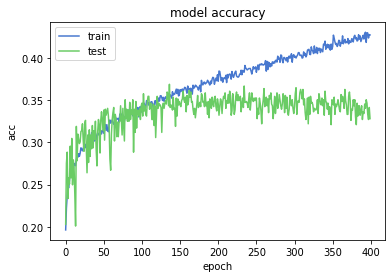

In [31]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
#save model
model_name = 'IEMOCAP_male_9_5feMALE_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\ioann\saved_models\IEMOCAP_male_9_5feMALE_Model.h5 


In [33]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [34]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/Users/ioann/saved_models/IEMOCAP_male_9_5feMALE_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 32.82%


In [22]:
def build_ravdess_onesub(file_list):
    
   
    df = { 'actor': [] }
   

    for file in file_list:
        

        props = file.split('_')
        df['actor'].append(props[-1][0])
       

       

    file_properties = pd.DataFrame(df)
    
    return file_properties

In [23]:
wav_list=new_df['wav_file'].values.tolist()
actor_list=build_ravdess_onesub(wav_list)
actor = pd.DataFrame(actor_list)

In [24]:
newdf = pd.concat([new_df, actor], axis=1)

newdf=newdf.fillna(0)
newdf

,wav_file,label,0,1,2,3,4,5,6,7,...,31,32,33,34,35,36,37,38,39,actor
0,Ses01F_impro01_F000,p,-524.699433,156.781896,-46.480218,46.525830,9.022199,-12.766758,21.525594,-11.940674,...,2.363418,1.756676,1.558484,5.040378,2.336856,2.541656,5.080285,1.890300,0.405106,F
1,Ses01F_impro01_F001,p,-557.610687,172.858331,-21.808400,8.885391,26.234351,-5.373108,11.168930,3.739676,...,-0.429307,-0.558823,-1.649951,-0.002323,2.548439,2.421835,2.309594,0.747226,-1.286093,F
2,Ses01F_impro01_F002,p,-558.770972,185.330174,-38.221451,22.879543,18.858484,-15.227420,16.688347,0.256739,...,1.046266,0.228226,-0.230946,2.008534,1.608835,2.512266,3.102059,-0.276270,-1.303009,F
3,Ses01F_impro01_F003,oth,-526.482061,165.403830,-20.296760,20.994315,33.703021,-8.659728,6.961069,3.305663,...,0.253248,2.902356,0.803315,1.456078,3.585221,3.183342,1.858934,-0.170223,-0.767116,F
4,Ses01F_impro01_F004,oth,-461.586534,152.142613,-24.089382,22.405067,27.986986,-8.544526,-1.318120,-11.653250,...,1.904614,3.231207,1.425773,0.382172,0.871165,2.146637,2.884337,1.978480,1.265936,F
5,Ses01F_impro01_F005,p,-420.344880,153.939926,-21.221131,18.940197,6.143656,-15.640639,7.313545,-10.395848,...,1.068132,2.623283,1.167064,2.078736,1.707843,1.113912,1.757166,1.270980,1.543591,F
6,Ses01F_impro01_F006,n,-368.500637,164.878801,-23.668154,-5.211489,25.793473,-5.306778,-3.176753,4.421050,...,3.117535,3.273084,1.700321,3.272663,4.593440,4.680887,4.133452,2.600155,2.745856,F
7,Ses01F_impro01_F007,n,-436.219310,150.175568,-23.275061,4.531827,22.397548,-6.205895,2.955328,-2.724705,...,0.603652,0.272676,-0.308167,0.981211,1.150199,0.949328,1.138642,0.536484,0.292167,F
8,Ses01F_impro01_F008,n,-400.098804,181.100895,-51.846364,18.351225,25.325297,-22.867127,1.954922,-1.932408,...,0.532372,-1.852402,-3.177997,-0.266371,1.052090,1.975621,1.298498,-0.646915,0.958540,F
9,Ses01F_impro01_F009,n,-471.406158,156.544158,-29.516037,7.586400,20.570546,-9.838308,7.867089,0.812676,...,-0.114025,-0.047194,-0.575292,0.941380,2.719691,3.365939,1.975253,0.448511,1.656224,F


In [25]:
def build_onesub(file_list):
    
   
    df = { 'session': [] }
   

    for file in file_list:
        

        props = file.split('_')
        df['session'].append(props[0][:-1])
       

       

    file_properties = pd.DataFrame(df)
    
    return file_properties

In [26]:
wav_list=new_df['wav_file'].values.tolist()
session_list=build_onesub(wav_list)
session = pd.DataFrame(session_list)
session

,session
0,Ses01
1,Ses01
2,Ses01
3,Ses01
4,Ses01
5,Ses01
6,Ses01
7,Ses01
8,Ses01
9,Ses01


In [27]:
new_df_ses = pd.concat([new_df, actor, session], axis=1)

new_df_ses=new_df_ses.fillna(0)
new_df_ses

,wav_file,label,0,1,2,3,4,5,6,7,...,32,33,34,35,36,37,38,39,actor,session
0,Ses01F_impro01_F000,p,-524.699433,156.781896,-46.480218,46.525830,9.022199,-12.766758,21.525594,-11.940674,...,1.756676,1.558484,5.040378,2.336856,2.541656,5.080285,1.890300,0.405106,F,Ses01
1,Ses01F_impro01_F001,p,-557.610687,172.858331,-21.808400,8.885391,26.234351,-5.373108,11.168930,3.739676,...,-0.558823,-1.649951,-0.002323,2.548439,2.421835,2.309594,0.747226,-1.286093,F,Ses01
2,Ses01F_impro01_F002,p,-558.770972,185.330174,-38.221451,22.879543,18.858484,-15.227420,16.688347,0.256739,...,0.228226,-0.230946,2.008534,1.608835,2.512266,3.102059,-0.276270,-1.303009,F,Ses01
3,Ses01F_impro01_F003,oth,-526.482061,165.403830,-20.296760,20.994315,33.703021,-8.659728,6.961069,3.305663,...,2.902356,0.803315,1.456078,3.585221,3.183342,1.858934,-0.170223,-0.767116,F,Ses01
4,Ses01F_impro01_F004,oth,-461.586534,152.142613,-24.089382,22.405067,27.986986,-8.544526,-1.318120,-11.653250,...,3.231207,1.425773,0.382172,0.871165,2.146637,2.884337,1.978480,1.265936,F,Ses01
5,Ses01F_impro01_F005,p,-420.344880,153.939926,-21.221131,18.940197,6.143656,-15.640639,7.313545,-10.395848,...,2.623283,1.167064,2.078736,1.707843,1.113912,1.757166,1.270980,1.543591,F,Ses01
6,Ses01F_impro01_F006,n,-368.500637,164.878801,-23.668154,-5.211489,25.793473,-5.306778,-3.176753,4.421050,...,3.273084,1.700321,3.272663,4.593440,4.680887,4.133452,2.600155,2.745856,F,Ses01
7,Ses01F_impro01_F007,n,-436.219310,150.175568,-23.275061,4.531827,22.397548,-6.205895,2.955328,-2.724705,...,0.272676,-0.308167,0.981211,1.150199,0.949328,1.138642,0.536484,0.292167,F,Ses01
8,Ses01F_impro01_F008,n,-400.098804,181.100895,-51.846364,18.351225,25.325297,-22.867127,1.954922,-1.932408,...,-1.852402,-3.177997,-0.266371,1.052090,1.975621,1.298498,-0.646915,0.958540,F,Ses01
9,Ses01F_impro01_F009,n,-471.406158,156.544158,-29.516037,7.586400,20.570546,-9.838308,7.867089,0.812676,...,-0.047194,-0.575292,0.941380,2.719691,3.365939,1.975253,0.448511,1.656224,F,Ses01


In [28]:
#gia male me ses
male_df_ses=(new_df_ses.loc[new_df_ses['actor'] != 'F'])

male_df_ses=male_df_ses.fillna(0)
male_df_ses

,wav_file,label,0,1,2,3,4,5,6,7,...,32,33,34,35,36,37,38,39,actor,session
16,Ses01F_impro01_M000,n,-528.301828,175.161637,-40.695592,29.582657,20.563640,-17.022413,18.446683,-2.635731,...,-1.046503,-1.710547,0.770408,-0.722925,0.780592,2.743282,-1.130217,-1.762778,M,Ses01
17,Ses01F_impro01_M001,n,-578.753364,177.339040,-29.834374,30.482880,20.720151,-13.339913,21.309800,-1.671017,...,-0.056112,-1.801580,1.979629,2.114441,2.043275,2.754667,-0.880692,-2.023587,M,Ses01
18,Ses01F_impro01_M002,n,-483.483073,175.896102,-20.875764,19.210717,15.172853,-10.099069,9.057746,-5.605250,...,0.588610,1.354784,1.981898,2.221999,2.156219,1.720458,0.639116,-0.393077,M,Ses01
19,Ses01F_impro01_M003,n,-423.371510,165.990290,-21.012657,16.502886,24.237640,-6.514301,-1.790263,-13.585031,...,-0.793655,-3.069717,-3.555864,-2.962489,-1.889444,-0.641586,-2.190782,-2.432778,M,Ses01
20,Ses01F_impro01_M004,n,-375.129896,158.040001,-27.657236,20.562050,8.113179,-17.048602,6.905656,-13.177964,...,0.828942,-0.554975,1.128573,0.828230,0.718324,2.292089,2.276395,3.253977,M,Ses01
21,Ses01F_impro01_M005,n,-422.717340,161.950498,-23.348196,14.697194,24.573133,-8.043550,8.178154,-0.981166,...,1.167264,0.004349,1.020307,1.226695,0.990612,2.655714,2.193172,1.688354,M,Ses01
22,Ses01F_impro01_M006,n,-368.209295,154.049148,-27.575132,9.539547,22.722329,-7.756064,1.468264,-3.292611,...,0.338539,0.488710,0.481371,0.677163,2.630153,3.742490,1.761118,1.564702,M,Ses01
23,Ses01F_impro01_M007,n,-396.392785,169.046691,-41.371585,15.687382,20.740174,-16.814938,-3.008479,-5.710485,...,-1.465170,-3.163530,-2.187978,-2.651071,-1.093471,-0.163915,-3.536735,-3.812445,M,Ses01
24,Ses01F_impro01_M008,n,-439.204553,140.255123,-6.794941,5.884957,13.865009,-5.140038,-0.642315,-0.735629,...,1.080947,0.646307,1.446902,2.467902,3.558053,2.955066,0.311662,-0.931853,M,Ses01
25,Ses01F_impro01_M009,n,-399.915473,138.019255,-15.886834,6.188115,17.441188,-6.685593,0.703249,-3.152298,...,0.470633,-0.222678,1.684311,2.446231,2.147366,1.899514,0.032914,-0.248247,M,Ses01


In [29]:
female_df_ses=(new_df_ses.loc[new_df_ses['actor'] != 'M'])

female_df_ses=female_df_ses.fillna(0)
female_df_ses

,wav_file,label,0,1,2,3,4,5,6,7,...,32,33,34,35,36,37,38,39,actor,session
0,Ses01F_impro01_F000,p,-524.699433,156.781896,-46.480218,46.525830,9.022199,-12.766758,21.525594,-11.940674,...,1.756676,1.558484,5.040378,2.336856,2.541656,5.080285,1.890300,0.405106,F,Ses01
1,Ses01F_impro01_F001,p,-557.610687,172.858331,-21.808400,8.885391,26.234351,-5.373108,11.168930,3.739676,...,-0.558823,-1.649951,-0.002323,2.548439,2.421835,2.309594,0.747226,-1.286093,F,Ses01
2,Ses01F_impro01_F002,p,-558.770972,185.330174,-38.221451,22.879543,18.858484,-15.227420,16.688347,0.256739,...,0.228226,-0.230946,2.008534,1.608835,2.512266,3.102059,-0.276270,-1.303009,F,Ses01
3,Ses01F_impro01_F003,oth,-526.482061,165.403830,-20.296760,20.994315,33.703021,-8.659728,6.961069,3.305663,...,2.902356,0.803315,1.456078,3.585221,3.183342,1.858934,-0.170223,-0.767116,F,Ses01
4,Ses01F_impro01_F004,oth,-461.586534,152.142613,-24.089382,22.405067,27.986986,-8.544526,-1.318120,-11.653250,...,3.231207,1.425773,0.382172,0.871165,2.146637,2.884337,1.978480,1.265936,F,Ses01
5,Ses01F_impro01_F005,p,-420.344880,153.939926,-21.221131,18.940197,6.143656,-15.640639,7.313545,-10.395848,...,2.623283,1.167064,2.078736,1.707843,1.113912,1.757166,1.270980,1.543591,F,Ses01
6,Ses01F_impro01_F006,n,-368.500637,164.878801,-23.668154,-5.211489,25.793473,-5.306778,-3.176753,4.421050,...,3.273084,1.700321,3.272663,4.593440,4.680887,4.133452,2.600155,2.745856,F,Ses01
7,Ses01F_impro01_F007,n,-436.219310,150.175568,-23.275061,4.531827,22.397548,-6.205895,2.955328,-2.724705,...,0.272676,-0.308167,0.981211,1.150199,0.949328,1.138642,0.536484,0.292167,F,Ses01
8,Ses01F_impro01_F008,n,-400.098804,181.100895,-51.846364,18.351225,25.325297,-22.867127,1.954922,-1.932408,...,-1.852402,-3.177997,-0.266371,1.052090,1.975621,1.298498,-0.646915,0.958540,F,Ses01
9,Ses01F_impro01_F009,n,-471.406158,156.544158,-29.516037,7.586400,20.570546,-9.838308,7.867089,0.812676,...,-0.047194,-0.575292,0.941380,2.719691,3.365939,1.975253,0.448511,1.656224,F,Ses01


In [30]:
#ta sessios jexorista
session1=(new_df_ses.loc[new_df_ses['session'] == 'Ses01'])
session2=(new_df_ses.loc[new_df_ses['session'] == 'Ses02'])
session3=(new_df_ses.loc[new_df_ses['session'] == 'Ses03'])
session4=(new_df_ses.loc[new_df_ses['session'] == 'Ses04'])
session5=(new_df_ses.loc[new_df_ses['session'] == 'Ses05'])


In [31]:
#train set
session5_female=(female_df_ses.loc[female_df_ses['session'] == 'Ses05'])

session5_male=(male_df_ses.loc[male_df_ses['session'] == 'Ses05'])
session4_female=(female_df_ses.loc[female_df_ses['session'] == 'Ses04'])

session4_male=(male_df_ses.loc[male_df_ses['session'] == 'Ses04'])
session3_female=(female_df_ses.loc[female_df_ses['session'] == 'Ses03'])

session3_male=(male_df_ses.loc[male_df_ses['session'] == 'Ses03'])
session2_female=(female_df_ses.loc[female_df_ses['session'] == 'Ses02'])

session2_male=(male_df_ses.loc[male_df_ses['session'] == 'Ses02'])
session1_female=(female_df_ses.loc[female_df_ses['session'] == 'Ses01'])

session1_male=(male_df_ses.loc[male_df_ses['session'] == 'Ses01'])


In [79]:
#test set
test=(female_df_ses.loc[female_df_ses['session'] == 'Ses05'])

test=test.fillna(0)
test

,wav_file,label,0,1,2,3,4,5,6,7,...,32,33,34,35,36,37,38,39,actor,session
7867,Ses05F_impro01_F000,p,-617.773705,195.451499,-45.659311,38.192751,18.507560,-21.107667,21.567012,-3.036473,...,-0.726290,-2.759920,0.131770,0.770212,0.737192,1.641800,-0.124761,0.142801,F,Ses05
7868,Ses05F_impro01_F001,n,-570.444800,186.561264,-20.837076,17.593901,23.813558,-10.225816,9.974903,-3.146044,...,-1.329980,-2.370060,-0.013442,1.322748,0.658792,1.643786,2.652717,1.291466,F,Ses05
7869,Ses05F_impro01_F002,n,-563.909447,185.610811,-20.909040,14.438211,27.321719,-14.186358,5.969482,4.433945,...,0.237509,-1.006848,2.429907,5.515336,4.375348,2.841387,2.455472,0.118916,F,Ses05
7870,Ses05F_impro01_F003,n,-557.353854,181.348455,-13.533608,13.854485,32.977523,-10.290695,-0.422346,3.404937,...,3.549774,0.748554,1.581662,2.266279,-0.166170,-0.846074,0.481024,0.054753,F,Ses05
7871,Ses05F_impro01_F004,n,-482.776510,172.618285,-51.528895,48.225347,8.445682,-26.214014,13.494564,-16.525988,...,5.129300,2.436363,3.745193,4.761725,4.688557,5.168216,4.592635,4.208222,F,Ses05
7872,Ses05F_impro01_F005,n,-452.437549,196.140993,-50.467525,24.302783,7.044994,-29.681785,9.027761,-10.458288,...,0.957906,-1.139589,-0.154045,1.431920,0.623955,-0.710699,-2.595125,-3.017236,F,Ses05
7873,Ses05F_impro01_F006,n,-482.462586,168.297506,-38.749706,16.946184,17.195388,-24.150082,4.930576,-2.149261,...,2.077463,2.058336,3.614714,4.143181,3.493147,3.322700,2.787449,1.714173,F,Ses05
7874,Ses05F_impro01_F007,n,-500.951485,155.676966,-31.706512,15.411773,10.113600,-20.800255,5.628254,-3.482517,...,2.423103,1.985654,2.506492,2.731241,3.028022,3.671764,3.587480,3.529660,F,Ses05
7875,Ses05F_impro01_F008,p,-494.761049,168.630524,-43.361699,26.844766,9.295077,-27.082597,9.548099,-9.748101,...,2.035489,1.149421,3.211444,4.140717,5.416559,8.166481,6.880370,3.862627,F,Ses05
7876,Ses05F_impro01_F009,n,-574.654979,162.052724,-22.891088,14.079509,13.064332,-14.635300,11.731644,1.052469,...,4.914459,3.484114,3.691809,4.198706,4.330331,5.086474,4.175782,1.384369,F,Ses05


In [80]:
train = pd.concat([session4, session5_male ,session2 ,session3, session1 ], axis=0)

train=train.fillna(0)
train

,wav_file,label,0,1,2,3,4,5,6,7,...,32,33,34,35,36,37,38,39,actor,session
5764,Ses04F_impro01_F000,oth,-488.586204,147.764960,-33.183272,14.818546,13.788887,-17.770929,3.826560,-5.350358,...,0.989995,-1.437471,0.397134,3.014836,3.563638,3.647673,3.812813,4.676808,F,Ses04
5765,Ses04F_impro01_F001,n,-488.351006,158.591395,-29.348004,16.431570,2.713732,-21.035102,8.404461,-9.898643,...,4.553415,0.791679,3.778736,4.688157,2.989719,4.165171,4.147637,3.219678,F,Ses04
5766,Ses04F_impro01_F002,n,-496.989163,165.726546,-40.952921,31.407689,26.060187,-17.515444,10.569963,-8.600173,...,1.892810,0.670405,0.870645,0.283135,1.648601,2.855336,1.299892,1.425162,F,Ses04
5767,Ses04F_impro01_F003,n,-544.223427,155.376788,-12.744671,2.533565,22.298116,-5.572071,-0.806916,3.434702,...,2.282118,0.087380,0.358346,1.765468,0.728674,1.367142,2.180813,0.570305,F,Ses04
5768,Ses04F_impro01_F004,n,-417.441527,165.245191,-34.615602,18.679172,17.541912,-22.134559,-2.571798,-7.557753,...,7.423014,2.262719,3.723045,2.504948,-1.029678,-0.718293,-0.608596,-0.145287,F,Ses04
5769,Ses04F_impro01_F005,n,-427.537541,143.074361,-34.429726,-1.670608,11.588849,-18.794697,-3.929388,-8.027617,...,3.007282,-1.260628,0.876625,4.631733,5.132989,6.876799,6.431952,3.526731,F,Ses04
5770,Ses04F_impro01_F006,n,-413.496608,167.383164,-49.312482,12.407654,14.244489,-24.317111,0.162315,-8.193742,...,-0.067746,-2.245870,-1.009368,-0.244452,-0.447820,0.288701,-0.003606,0.425649,F,Ses04
5771,Ses04F_impro01_F007,n,-413.443065,154.457431,-41.919088,20.751632,22.489711,-24.309569,-4.633477,-8.911044,...,2.811697,-0.820982,0.356118,0.392836,-0.822018,0.900811,0.585758,-0.253309,F,Ses04
5772,Ses04F_impro01_F008,n,-395.531649,180.275812,-51.683175,-4.175057,26.784579,-20.209103,-8.010027,0.543372,...,2.974855,1.067883,1.091359,-0.521205,-0.957195,0.515864,-0.038111,1.678266,F,Ses04
5773,Ses04F_impro01_F009,n,-485.550768,112.449305,2.595411,1.517536,-0.722570,-9.898450,2.885822,-2.250087,...,3.167997,0.719380,1.026383,2.299490,2.459353,2.840299,3.117750,3.002460,F,Ses04


In [77]:

df1 = np.random.rand(len(female_df_ses)) < 0.96
train =female_df_ses[df1]
test = female_df_ses[~df1]

In [81]:
trainlabel=train.iloc[:,1:2]
trainfeatures = train.iloc[: ,2:-2]
testfeatures = test.iloc[:, 2:-2]
testlabel=test.iloc[:, 1:2]

In [82]:
testlabel

,label
7867,p
7868,n
7869,n
7870,n
7871,n
7872,n
7873,n
7874,n
7875,p
7876,n


In [83]:
X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

In [84]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder



lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

C:\Users\ioann\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [85]:
#for cnn
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [86]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
model = Sequential()



model.add(Conv1D(256, 5,padding='same',
                 input_shape=(120,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(3))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

In [87]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 120, 256)          1536      
_________________________________________________________________
activation_11 (Activation)   (None, 120, 256)          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 120, 128)          163968    
_________________________________________________________________
activation_12 (Activation)   (None, 120, 128)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 120, 128)          0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 15, 128)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 15, 128)          

In [88]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [89]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=400, validation_data=(x_testcnn, y_test))

Train on 9004 samples, validate on 1033 samples
Epoch 1/400
9004/9004 [==============================] - ETA: 1:49 - loss: 2.9651 - accuracy: 0.43 - ETA: 19s - loss: 2.0068 - accuracy: 0.3214 - ETA: 12s - loss: 1.7976 - accuracy: 0.346 - ETA: 9s - loss: 1.6458 - accuracy: 0.368 - ETA: 8s - loss: 1.5948 - accuracy: 0.37 - ETA: 7s - loss: 1.6003 - accuracy: 0.35 - ETA: 7s - loss: 1.5864 - accuracy: 0.35 - ETA: 6s - loss: 1.5772 - accuracy: 0.35 - ETA: 6s - loss: 1.5998 - accuracy: 0.34 - ETA: 5s - loss: 1.5800 - accuracy: 0.35 - ETA: 5s - loss: 1.5627 - accuracy: 0.35 - ETA: 5s - loss: 1.5741 - accuracy: 0.35 - ETA: 5s - loss: 1.5730 - accuracy: 0.35 - ETA: 4s - loss: 1.5804 - accuracy: 0.35 - ETA: 4s - loss: 1.5652 - accuracy: 0.35 - ETA: 4s - loss: 1.5542 - accuracy: 0.35 - ETA: 4s - loss: 1.5573 - accuracy: 0.35 - ETA: 4s - loss: 1.5539 - accuracy: 0.35 - ETA: 4s - loss: 1.5416 - accuracy: 0.35 - ETA: 4s - loss: 1.5550 - accuracy: 0.34 - ETA: 4s - loss: 1.5459 - accuracy: 0.34 - ETA: 

9004/9004 [==============================] - ETA: 4s - loss: 0.8297 - accuracy: 0.62 - ETA: 4s - loss: 1.1264 - accuracy: 0.44 - ETA: 4s - loss: 1.1371 - accuracy: 0.41 - ETA: 4s - loss: 1.1401 - accuracy: 0.40 - ETA: 4s - loss: 1.1596 - accuracy: 0.37 - ETA: 4s - loss: 1.1732 - accuracy: 0.36 - ETA: 4s - loss: 1.1765 - accuracy: 0.36 - ETA: 3s - loss: 1.1618 - accuracy: 0.37 - ETA: 3s - loss: 1.1575 - accuracy: 0.36 - ETA: 3s - loss: 1.1544 - accuracy: 0.37 - ETA: 3s - loss: 1.1560 - accuracy: 0.37 - ETA: 3s - loss: 1.1522 - accuracy: 0.37 - ETA: 3s - loss: 1.1534 - accuracy: 0.38 - ETA: 3s - loss: 1.1547 - accuracy: 0.37 - ETA: 3s - loss: 1.1578 - accuracy: 0.37 - ETA: 3s - loss: 1.1588 - accuracy: 0.37 - ETA: 3s - loss: 1.1560 - accuracy: 0.38 - ETA: 3s - loss: 1.1520 - accuracy: 0.38 - ETA: 3s - loss: 1.1510 - accuracy: 0.38 - ETA: 3s - loss: 1.1440 - accuracy: 0.39 - ETA: 3s - loss: 1.1439 - accuracy: 0.38 - ETA: 3s - loss: 1.1429 - accuracy: 0.38 - ETA: 3s - loss: 1.1393 - accura

9004/9004 [==============================] - ETA: 4s - loss: 1.1812 - accuracy: 0.31 - ETA: 4s - loss: 1.0806 - accuracy: 0.39 - ETA: 4s - loss: 1.1127 - accuracy: 0.37 - ETA: 4s - loss: 1.1065 - accuracy: 0.39 - ETA: 4s - loss: 1.0983 - accuracy: 0.40 - ETA: 4s - loss: 1.1046 - accuracy: 0.40 - ETA: 3s - loss: 1.1164 - accuracy: 0.40 - ETA: 3s - loss: 1.1109 - accuracy: 0.40 - ETA: 3s - loss: 1.1118 - accuracy: 0.40 - ETA: 3s - loss: 1.1125 - accuracy: 0.39 - ETA: 3s - loss: 1.1082 - accuracy: 0.40 - ETA: 3s - loss: 1.1005 - accuracy: 0.41 - ETA: 3s - loss: 1.1074 - accuracy: 0.40 - ETA: 3s - loss: 1.1070 - accuracy: 0.40 - ETA: 3s - loss: 1.1050 - accuracy: 0.40 - ETA: 3s - loss: 1.0995 - accuracy: 0.41 - ETA: 3s - loss: 1.0970 - accuracy: 0.41 - ETA: 3s - loss: 1.0981 - accuracy: 0.40 - ETA: 3s - loss: 1.0962 - accuracy: 0.40 - ETA: 3s - loss: 1.0924 - accuracy: 0.41 - ETA: 3s - loss: 1.0930 - accuracy: 0.41 - ETA: 3s - loss: 1.0950 - accuracy: 0.41 - ETA: 3s - loss: 1.0955 - accura

9004/9004 [==============================] - ETA: 4s - loss: 1.3907 - accuracy: 0.31 - ETA: 4s - loss: 1.1004 - accuracy: 0.42 - ETA: 4s - loss: 1.0974 - accuracy: 0.44 - ETA: 4s - loss: 1.1084 - accuracy: 0.42 - ETA: 4s - loss: 1.1138 - accuracy: 0.39 - ETA: 4s - loss: 1.1135 - accuracy: 0.39 - ETA: 4s - loss: 1.1106 - accuracy: 0.39 - ETA: 3s - loss: 1.1113 - accuracy: 0.39 - ETA: 3s - loss: 1.1084 - accuracy: 0.39 - ETA: 3s - loss: 1.1081 - accuracy: 0.39 - ETA: 3s - loss: 1.1061 - accuracy: 0.40 - ETA: 3s - loss: 1.1059 - accuracy: 0.40 - ETA: 3s - loss: 1.1065 - accuracy: 0.40 - ETA: 3s - loss: 1.1044 - accuracy: 0.40 - ETA: 3s - loss: 1.0999 - accuracy: 0.40 - ETA: 3s - loss: 1.0977 - accuracy: 0.41 - ETA: 3s - loss: 1.0968 - accuracy: 0.41 - ETA: 3s - loss: 1.0959 - accuracy: 0.41 - ETA: 3s - loss: 1.0963 - accuracy: 0.41 - ETA: 3s - loss: 1.0965 - accuracy: 0.41 - ETA: 3s - loss: 1.0986 - accuracy: 0.41 - ETA: 3s - loss: 1.0973 - accuracy: 0.41 - ETA: 3s - loss: 1.0976 - accura

9004/9004 [==============================] - ETA: 4s - loss: 1.1310 - accuracy: 0.50 - ETA: 4s - loss: 1.0961 - accuracy: 0.43 - ETA: 4s - loss: 1.0663 - accuracy: 0.44 - ETA: 4s - loss: 1.0566 - accuracy: 0.46 - ETA: 4s - loss: 1.0541 - accuracy: 0.47 - ETA: 4s - loss: 1.0559 - accuracy: 0.47 - ETA: 3s - loss: 1.0533 - accuracy: 0.47 - ETA: 3s - loss: 1.0578 - accuracy: 0.46 - ETA: 3s - loss: 1.0632 - accuracy: 0.44 - ETA: 3s - loss: 1.0566 - accuracy: 0.45 - ETA: 3s - loss: 1.0576 - accuracy: 0.45 - ETA: 3s - loss: 1.0599 - accuracy: 0.44 - ETA: 3s - loss: 1.0590 - accuracy: 0.45 - ETA: 3s - loss: 1.0613 - accuracy: 0.44 - ETA: 3s - loss: 1.0661 - accuracy: 0.43 - ETA: 3s - loss: 1.0688 - accuracy: 0.43 - ETA: 3s - loss: 1.0718 - accuracy: 0.43 - ETA: 3s - loss: 1.0715 - accuracy: 0.43 - ETA: 3s - loss: 1.0729 - accuracy: 0.43 - ETA: 3s - loss: 1.0743 - accuracy: 0.43 - ETA: 3s - loss: 1.0761 - accuracy: 0.42 - ETA: 3s - loss: 1.0759 - accuracy: 0.42 - ETA: 3s - loss: 1.0782 - accura

9004/9004 [==============================] - ETA: 4s - loss: 1.0265 - accuracy: 0.50 - ETA: 4s - loss: 1.0074 - accuracy: 0.50 - ETA: 4s - loss: 1.0419 - accuracy: 0.49 - ETA: 4s - loss: 1.0662 - accuracy: 0.45 - ETA: 4s - loss: 1.0667 - accuracy: 0.45 - ETA: 4s - loss: 1.0623 - accuracy: 0.44 - ETA: 3s - loss: 1.0651 - accuracy: 0.42 - ETA: 3s - loss: 1.0703 - accuracy: 0.42 - ETA: 3s - loss: 1.0672 - accuracy: 0.43 - ETA: 3s - loss: 1.0655 - accuracy: 0.44 - ETA: 3s - loss: 1.0690 - accuracy: 0.43 - ETA: 3s - loss: 1.0683 - accuracy: 0.44 - ETA: 3s - loss: 1.0702 - accuracy: 0.43 - ETA: 3s - loss: 1.0725 - accuracy: 0.43 - ETA: 3s - loss: 1.0706 - accuracy: 0.44 - ETA: 3s - loss: 1.0734 - accuracy: 0.43 - ETA: 3s - loss: 1.0734 - accuracy: 0.43 - ETA: 3s - loss: 1.0714 - accuracy: 0.43 - ETA: 3s - loss: 1.0729 - accuracy: 0.43 - ETA: 3s - loss: 1.0730 - accuracy: 0.43 - ETA: 3s - loss: 1.0721 - accuracy: 0.43 - ETA: 3s - loss: 1.0725 - accuracy: 0.43 - ETA: 3s - loss: 1.0741 - accura

9004/9004 [==============================] - ETA: 4s - loss: 1.0183 - accuracy: 0.50 - ETA: 4s - loss: 1.0156 - accuracy: 0.49 - ETA: 4s - loss: 1.0347 - accuracy: 0.46 - ETA: 4s - loss: 1.0348 - accuracy: 0.46 - ETA: 4s - loss: 1.0425 - accuracy: 0.46 - ETA: 4s - loss: 1.0459 - accuracy: 0.46 - ETA: 3s - loss: 1.0495 - accuracy: 0.44 - ETA: 3s - loss: 1.0482 - accuracy: 0.46 - ETA: 3s - loss: 1.0552 - accuracy: 0.45 - ETA: 3s - loss: 1.0498 - accuracy: 0.46 - ETA: 3s - loss: 1.0502 - accuracy: 0.46 - ETA: 3s - loss: 1.0504 - accuracy: 0.45 - ETA: 3s - loss: 1.0470 - accuracy: 0.45 - ETA: 3s - loss: 1.0466 - accuracy: 0.45 - ETA: 3s - loss: 1.0455 - accuracy: 0.46 - ETA: 3s - loss: 1.0434 - accuracy: 0.46 - ETA: 3s - loss: 1.0485 - accuracy: 0.45 - ETA: 3s - loss: 1.0469 - accuracy: 0.45 - ETA: 3s - loss: 1.0483 - accuracy: 0.46 - ETA: 3s - loss: 1.0482 - accuracy: 0.46 - ETA: 3s - loss: 1.0524 - accuracy: 0.45 - ETA: 3s - loss: 1.0550 - accuracy: 0.45 - ETA: 3s - loss: 1.0564 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.9994 - accuracy: 0.56 - ETA: 4s - loss: 1.0996 - accuracy: 0.36 - ETA: 4s - loss: 1.0946 - accuracy: 0.37 - ETA: 4s - loss: 1.0834 - accuracy: 0.40 - ETA: 4s - loss: 1.0706 - accuracy: 0.43 - ETA: 4s - loss: 1.0704 - accuracy: 0.43 - ETA: 4s - loss: 1.0703 - accuracy: 0.43 - ETA: 3s - loss: 1.0654 - accuracy: 0.45 - ETA: 3s - loss: 1.0656 - accuracy: 0.45 - ETA: 3s - loss: 1.0640 - accuracy: 0.45 - ETA: 3s - loss: 1.0637 - accuracy: 0.45 - ETA: 3s - loss: 1.0603 - accuracy: 0.45 - ETA: 3s - loss: 1.0642 - accuracy: 0.44 - ETA: 3s - loss: 1.0635 - accuracy: 0.44 - ETA: 3s - loss: 1.0607 - accuracy: 0.44 - ETA: 3s - loss: 1.0625 - accuracy: 0.44 - ETA: 3s - loss: 1.0600 - accuracy: 0.44 - ETA: 3s - loss: 1.0596 - accuracy: 0.44 - ETA: 3s - loss: 1.0581 - accuracy: 0.45 - ETA: 3s - loss: 1.0559 - accuracy: 0.45 - ETA: 3s - loss: 1.0568 - accuracy: 0.45 - ETA: 3s - loss: 1.0589 - accuracy: 0.45 - ETA: 3s - loss: 1.0582 - accura

9004/9004 [==============================] - ETA: 4s - loss: 1.1552 - accuracy: 0.37 - ETA: 4s - loss: 1.0817 - accuracy: 0.39 - ETA: 4s - loss: 1.0785 - accuracy: 0.42 - ETA: 4s - loss: 1.0726 - accuracy: 0.43 - ETA: 4s - loss: 1.0866 - accuracy: 0.42 - ETA: 4s - loss: 1.0744 - accuracy: 0.43 - ETA: 4s - loss: 1.0732 - accuracy: 0.43 - ETA: 3s - loss: 1.0667 - accuracy: 0.44 - ETA: 3s - loss: 1.0665 - accuracy: 0.44 - ETA: 3s - loss: 1.0640 - accuracy: 0.44 - ETA: 3s - loss: 1.0686 - accuracy: 0.44 - ETA: 3s - loss: 1.0691 - accuracy: 0.43 - ETA: 3s - loss: 1.0691 - accuracy: 0.43 - ETA: 3s - loss: 1.0684 - accuracy: 0.43 - ETA: 3s - loss: 1.0681 - accuracy: 0.43 - ETA: 3s - loss: 1.0667 - accuracy: 0.44 - ETA: 3s - loss: 1.0661 - accuracy: 0.44 - ETA: 3s - loss: 1.0643 - accuracy: 0.44 - ETA: 3s - loss: 1.0647 - accuracy: 0.44 - ETA: 3s - loss: 1.0631 - accuracy: 0.44 - ETA: 3s - loss: 1.0630 - accuracy: 0.44 - ETA: 3s - loss: 1.0621 - accuracy: 0.44 - ETA: 3s - loss: 1.0608 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.8996 - accuracy: 0.62 - ETA: 4s - loss: 1.0816 - accuracy: 0.45 - ETA: 4s - loss: 1.0861 - accuracy: 0.42 - ETA: 4s - loss: 1.0822 - accuracy: 0.43 - ETA: 4s - loss: 1.0806 - accuracy: 0.43 - ETA: 4s - loss: 1.0876 - accuracy: 0.41 - ETA: 4s - loss: 1.0786 - accuracy: 0.42 - ETA: 4s - loss: 1.0671 - accuracy: 0.44 - ETA: 3s - loss: 1.0673 - accuracy: 0.44 - ETA: 3s - loss: 1.0676 - accuracy: 0.43 - ETA: 3s - loss: 1.0695 - accuracy: 0.43 - ETA: 3s - loss: 1.0711 - accuracy: 0.43 - ETA: 3s - loss: 1.0671 - accuracy: 0.43 - ETA: 3s - loss: 1.0695 - accuracy: 0.43 - ETA: 3s - loss: 1.0664 - accuracy: 0.43 - ETA: 3s - loss: 1.0657 - accuracy: 0.43 - ETA: 3s - loss: 1.0596 - accuracy: 0.44 - ETA: 3s - loss: 1.0565 - accuracy: 0.44 - ETA: 3s - loss: 1.0526 - accuracy: 0.45 - ETA: 3s - loss: 1.0531 - accuracy: 0.45 - ETA: 3s - loss: 1.0521 - accuracy: 0.44 - ETA: 3s - loss: 1.0495 - accuracy: 0.45 - ETA: 3s - loss: 1.0507 - accura

9004/9004 [==============================] - ETA: 4s - loss: 1.1152 - accuracy: 0.37 - ETA: 4s - loss: 1.0427 - accuracy: 0.50 - ETA: 4s - loss: 1.0494 - accuracy: 0.50 - ETA: 4s - loss: 1.0466 - accuracy: 0.48 - ETA: 4s - loss: 1.0497 - accuracy: 0.47 - ETA: 4s - loss: 1.0454 - accuracy: 0.47 - ETA: 3s - loss: 1.0482 - accuracy: 0.47 - ETA: 3s - loss: 1.0461 - accuracy: 0.47 - ETA: 3s - loss: 1.0436 - accuracy: 0.47 - ETA: 3s - loss: 1.0420 - accuracy: 0.47 - ETA: 3s - loss: 1.0414 - accuracy: 0.47 - ETA: 3s - loss: 1.0397 - accuracy: 0.47 - ETA: 3s - loss: 1.0422 - accuracy: 0.47 - ETA: 3s - loss: 1.0479 - accuracy: 0.47 - ETA: 3s - loss: 1.0449 - accuracy: 0.47 - ETA: 3s - loss: 1.0449 - accuracy: 0.47 - ETA: 3s - loss: 1.0435 - accuracy: 0.47 - ETA: 3s - loss: 1.0411 - accuracy: 0.48 - ETA: 3s - loss: 1.0395 - accuracy: 0.48 - ETA: 3s - loss: 1.0405 - accuracy: 0.48 - ETA: 3s - loss: 1.0389 - accuracy: 0.48 - ETA: 3s - loss: 1.0395 - accuracy: 0.47 - ETA: 3s - loss: 1.0381 - accura

9004/9004 [==============================] - ETA: 4s - loss: 1.0984 - accuracy: 0.43 - ETA: 4s - loss: 1.0445 - accuracy: 0.48 - ETA: 4s - loss: 1.0610 - accuracy: 0.48 - ETA: 4s - loss: 1.0598 - accuracy: 0.47 - ETA: 4s - loss: 1.0469 - accuracy: 0.48 - ETA: 4s - loss: 1.0463 - accuracy: 0.47 - ETA: 4s - loss: 1.0422 - accuracy: 0.48 - ETA: 3s - loss: 1.0448 - accuracy: 0.48 - ETA: 3s - loss: 1.0393 - accuracy: 0.48 - ETA: 3s - loss: 1.0404 - accuracy: 0.47 - ETA: 3s - loss: 1.0408 - accuracy: 0.47 - ETA: 3s - loss: 1.0393 - accuracy: 0.47 - ETA: 3s - loss: 1.0403 - accuracy: 0.47 - ETA: 3s - loss: 1.0413 - accuracy: 0.47 - ETA: 3s - loss: 1.0434 - accuracy: 0.47 - ETA: 3s - loss: 1.0425 - accuracy: 0.47 - ETA: 3s - loss: 1.0419 - accuracy: 0.47 - ETA: 3s - loss: 1.0371 - accuracy: 0.47 - ETA: 3s - loss: 1.0393 - accuracy: 0.47 - ETA: 3s - loss: 1.0394 - accuracy: 0.47 - ETA: 3s - loss: 1.0384 - accuracy: 0.47 - ETA: 3s - loss: 1.0406 - accuracy: 0.47 - ETA: 3s - loss: 1.0370 - accura

9004/9004 [==============================] - ETA: 4s - loss: 1.0713 - accuracy: 0.50 - ETA: 4s - loss: 1.0517 - accuracy: 0.48 - ETA: 4s - loss: 1.0537 - accuracy: 0.47 - ETA: 4s - loss: 1.0268 - accuracy: 0.49 - ETA: 4s - loss: 1.0333 - accuracy: 0.49 - ETA: 4s - loss: 1.0368 - accuracy: 0.48 - ETA: 3s - loss: 1.0432 - accuracy: 0.47 - ETA: 3s - loss: 1.0371 - accuracy: 0.48 - ETA: 3s - loss: 1.0283 - accuracy: 0.48 - ETA: 3s - loss: 1.0312 - accuracy: 0.48 - ETA: 3s - loss: 1.0233 - accuracy: 0.48 - ETA: 3s - loss: 1.0214 - accuracy: 0.48 - ETA: 3s - loss: 1.0240 - accuracy: 0.49 - ETA: 3s - loss: 1.0246 - accuracy: 0.49 - ETA: 3s - loss: 1.0271 - accuracy: 0.48 - ETA: 3s - loss: 1.0296 - accuracy: 0.48 - ETA: 3s - loss: 1.0276 - accuracy: 0.48 - ETA: 3s - loss: 1.0307 - accuracy: 0.48 - ETA: 3s - loss: 1.0348 - accuracy: 0.47 - ETA: 3s - loss: 1.0370 - accuracy: 0.47 - ETA: 3s - loss: 1.0351 - accuracy: 0.48 - ETA: 3s - loss: 1.0333 - accuracy: 0.48 - ETA: 3s - loss: 1.0322 - accura

9004/9004 [==============================] - ETA: 4s - loss: 1.0745 - accuracy: 0.25 - ETA: 4s - loss: 1.0229 - accuracy: 0.45 - ETA: 4s - loss: 1.0407 - accuracy: 0.46 - ETA: 4s - loss: 1.0283 - accuracy: 0.48 - ETA: 4s - loss: 1.0367 - accuracy: 0.47 - ETA: 4s - loss: 1.0304 - accuracy: 0.48 - ETA: 4s - loss: 1.0204 - accuracy: 0.48 - ETA: 3s - loss: 1.0128 - accuracy: 0.50 - ETA: 3s - loss: 1.0225 - accuracy: 0.49 - ETA: 3s - loss: 1.0227 - accuracy: 0.48 - ETA: 3s - loss: 1.0214 - accuracy: 0.48 - ETA: 3s - loss: 1.0237 - accuracy: 0.48 - ETA: 3s - loss: 1.0232 - accuracy: 0.48 - ETA: 3s - loss: 1.0257 - accuracy: 0.48 - ETA: 3s - loss: 1.0251 - accuracy: 0.48 - ETA: 3s - loss: 1.0299 - accuracy: 0.48 - ETA: 3s - loss: 1.0319 - accuracy: 0.48 - ETA: 3s - loss: 1.0318 - accuracy: 0.48 - ETA: 3s - loss: 1.0303 - accuracy: 0.48 - ETA: 3s - loss: 1.0318 - accuracy: 0.47 - ETA: 3s - loss: 1.0320 - accuracy: 0.47 - ETA: 3s - loss: 1.0333 - accuracy: 0.47 - ETA: 3s - loss: 1.0347 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.9255 - accuracy: 0.50 - ETA: 4s - loss: 0.9974 - accuracy: 0.51 - ETA: 4s - loss: 1.0253 - accuracy: 0.47 - ETA: 4s - loss: 1.0192 - accuracy: 0.47 - ETA: 4s - loss: 1.0156 - accuracy: 0.47 - ETA: 4s - loss: 1.0007 - accuracy: 0.48 - ETA: 3s - loss: 1.0026 - accuracy: 0.49 - ETA: 3s - loss: 1.0074 - accuracy: 0.49 - ETA: 3s - loss: 1.0067 - accuracy: 0.50 - ETA: 3s - loss: 1.0025 - accuracy: 0.50 - ETA: 3s - loss: 1.0068 - accuracy: 0.50 - ETA: 3s - loss: 1.0076 - accuracy: 0.50 - ETA: 3s - loss: 1.0061 - accuracy: 0.50 - ETA: 3s - loss: 1.0068 - accuracy: 0.49 - ETA: 3s - loss: 1.0102 - accuracy: 0.49 - ETA: 3s - loss: 1.0121 - accuracy: 0.49 - ETA: 3s - loss: 1.0143 - accuracy: 0.49 - ETA: 3s - loss: 1.0169 - accuracy: 0.49 - ETA: 3s - loss: 1.0177 - accuracy: 0.48 - ETA: 3s - loss: 1.0194 - accuracy: 0.48 - ETA: 3s - loss: 1.0216 - accuracy: 0.48 - ETA: 3s - loss: 1.0209 - accuracy: 0.48 - ETA: 3s - loss: 1.0205 - accura

9004/9004 [==============================] - ETA: 3s - loss: 0.9994 - accuracy: 0.56 - ETA: 4s - loss: 1.0362 - accuracy: 0.49 - ETA: 4s - loss: 1.0499 - accuracy: 0.47 - ETA: 4s - loss: 1.0353 - accuracy: 0.49 - ETA: 4s - loss: 1.0118 - accuracy: 0.52 - ETA: 4s - loss: 1.0143 - accuracy: 0.51 - ETA: 4s - loss: 1.0060 - accuracy: 0.52 - ETA: 4s - loss: 1.0080 - accuracy: 0.50 - ETA: 3s - loss: 1.0144 - accuracy: 0.49 - ETA: 3s - loss: 1.0134 - accuracy: 0.49 - ETA: 3s - loss: 1.0179 - accuracy: 0.48 - ETA: 3s - loss: 1.0242 - accuracy: 0.48 - ETA: 3s - loss: 1.0272 - accuracy: 0.48 - ETA: 3s - loss: 1.0236 - accuracy: 0.48 - ETA: 3s - loss: 1.0256 - accuracy: 0.48 - ETA: 3s - loss: 1.0262 - accuracy: 0.48 - ETA: 3s - loss: 1.0281 - accuracy: 0.48 - ETA: 3s - loss: 1.0254 - accuracy: 0.48 - ETA: 3s - loss: 1.0282 - accuracy: 0.48 - ETA: 3s - loss: 1.0313 - accuracy: 0.48 - ETA: 3s - loss: 1.0292 - accuracy: 0.48 - ETA: 3s - loss: 1.0287 - accuracy: 0.48 - ETA: 3s - loss: 1.0299 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.9646 - accuracy: 0.62 - ETA: 4s - loss: 1.0287 - accuracy: 0.48 - ETA: 4s - loss: 1.0189 - accuracy: 0.49 - ETA: 4s - loss: 1.0524 - accuracy: 0.46 - ETA: 4s - loss: 1.0485 - accuracy: 0.46 - ETA: 4s - loss: 1.0384 - accuracy: 0.48 - ETA: 4s - loss: 1.0396 - accuracy: 0.48 - ETA: 3s - loss: 1.0312 - accuracy: 0.48 - ETA: 3s - loss: 1.0274 - accuracy: 0.49 - ETA: 3s - loss: 1.0297 - accuracy: 0.48 - ETA: 3s - loss: 1.0274 - accuracy: 0.48 - ETA: 3s - loss: 1.0304 - accuracy: 0.48 - ETA: 3s - loss: 1.0277 - accuracy: 0.48 - ETA: 3s - loss: 1.0282 - accuracy: 0.48 - ETA: 3s - loss: 1.0280 - accuracy: 0.48 - ETA: 3s - loss: 1.0285 - accuracy: 0.48 - ETA: 3s - loss: 1.0313 - accuracy: 0.47 - ETA: 3s - loss: 1.0356 - accuracy: 0.47 - ETA: 3s - loss: 1.0346 - accuracy: 0.47 - ETA: 3s - loss: 1.0318 - accuracy: 0.47 - ETA: 3s - loss: 1.0317 - accuracy: 0.47 - ETA: 3s - loss: 1.0264 - accuracy: 0.48 - ETA: 3s - loss: 1.0270 - accura

9004/9004 [==============================] - ETA: 5s - loss: 0.9909 - accuracy: 0.50 - ETA: 4s - loss: 1.0798 - accuracy: 0.42 - ETA: 4s - loss: 1.0366 - accuracy: 0.46 - ETA: 4s - loss: 1.0328 - accuracy: 0.47 - ETA: 4s - loss: 1.0411 - accuracy: 0.45 - ETA: 4s - loss: 1.0286 - accuracy: 0.46 - ETA: 4s - loss: 1.0187 - accuracy: 0.48 - ETA: 4s - loss: 1.0177 - accuracy: 0.47 - ETA: 3s - loss: 1.0128 - accuracy: 0.48 - ETA: 3s - loss: 1.0102 - accuracy: 0.49 - ETA: 3s - loss: 1.0114 - accuracy: 0.48 - ETA: 3s - loss: 1.0138 - accuracy: 0.48 - ETA: 3s - loss: 1.0113 - accuracy: 0.48 - ETA: 3s - loss: 1.0119 - accuracy: 0.48 - ETA: 3s - loss: 1.0154 - accuracy: 0.48 - ETA: 3s - loss: 1.0132 - accuracy: 0.48 - ETA: 3s - loss: 1.0162 - accuracy: 0.48 - ETA: 3s - loss: 1.0137 - accuracy: 0.48 - ETA: 3s - loss: 1.0154 - accuracy: 0.48 - ETA: 3s - loss: 1.0173 - accuracy: 0.47 - ETA: 3s - loss: 1.0183 - accuracy: 0.47 - ETA: 3s - loss: 1.0193 - accuracy: 0.47 - ETA: 3s - loss: 1.0206 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.9902 - accuracy: 0.50 - ETA: 4s - loss: 1.0146 - accuracy: 0.50 - ETA: 4s - loss: 1.0568 - accuracy: 0.45 - ETA: 4s - loss: 1.0379 - accuracy: 0.48 - ETA: 4s - loss: 1.0457 - accuracy: 0.47 - ETA: 4s - loss: 1.0506 - accuracy: 0.46 - ETA: 4s - loss: 1.0505 - accuracy: 0.46 - ETA: 3s - loss: 1.0447 - accuracy: 0.47 - ETA: 3s - loss: 1.0422 - accuracy: 0.47 - ETA: 3s - loss: 1.0352 - accuracy: 0.48 - ETA: 3s - loss: 1.0313 - accuracy: 0.49 - ETA: 3s - loss: 1.0290 - accuracy: 0.49 - ETA: 3s - loss: 1.0253 - accuracy: 0.49 - ETA: 3s - loss: 1.0243 - accuracy: 0.50 - ETA: 3s - loss: 1.0253 - accuracy: 0.49 - ETA: 3s - loss: 1.0205 - accuracy: 0.50 - ETA: 3s - loss: 1.0198 - accuracy: 0.50 - ETA: 3s - loss: 1.0170 - accuracy: 0.50 - ETA: 3s - loss: 1.0176 - accuracy: 0.50 - ETA: 3s - loss: 1.0171 - accuracy: 0.50 - ETA: 3s - loss: 1.0197 - accuracy: 0.49 - ETA: 3s - loss: 1.0233 - accuracy: 0.49 - ETA: 3s - loss: 1.0231 - accura

9004/9004 [==============================] - ETA: 4s - loss: 1.0177 - accuracy: 0.50 - ETA: 4s - loss: 1.0197 - accuracy: 0.46 - ETA: 4s - loss: 1.0308 - accuracy: 0.47 - ETA: 4s - loss: 1.0413 - accuracy: 0.43 - ETA: 4s - loss: 1.0255 - accuracy: 0.46 - ETA: 4s - loss: 1.0328 - accuracy: 0.46 - ETA: 4s - loss: 1.0265 - accuracy: 0.46 - ETA: 3s - loss: 1.0164 - accuracy: 0.47 - ETA: 3s - loss: 1.0142 - accuracy: 0.48 - ETA: 3s - loss: 1.0188 - accuracy: 0.48 - ETA: 3s - loss: 1.0121 - accuracy: 0.49 - ETA: 3s - loss: 1.0137 - accuracy: 0.48 - ETA: 3s - loss: 1.0098 - accuracy: 0.48 - ETA: 3s - loss: 1.0107 - accuracy: 0.48 - ETA: 3s - loss: 1.0059 - accuracy: 0.48 - ETA: 3s - loss: 1.0092 - accuracy: 0.48 - ETA: 3s - loss: 1.0096 - accuracy: 0.48 - ETA: 3s - loss: 1.0088 - accuracy: 0.48 - ETA: 3s - loss: 1.0076 - accuracy: 0.49 - ETA: 3s - loss: 1.0074 - accuracy: 0.49 - ETA: 3s - loss: 1.0102 - accuracy: 0.48 - ETA: 3s - loss: 1.0103 - accuracy: 0.48 - ETA: 3s - loss: 1.0110 - accura

9004/9004 [==============================] - ETA: 4s - loss: 1.0416 - accuracy: 0.31 - ETA: 4s - loss: 0.9992 - accuracy: 0.46 - ETA: 4s - loss: 1.0110 - accuracy: 0.47 - ETA: 4s - loss: 1.0099 - accuracy: 0.47 - ETA: 4s - loss: 1.0003 - accuracy: 0.49 - ETA: 4s - loss: 0.9994 - accuracy: 0.50 - ETA: 3s - loss: 0.9965 - accuracy: 0.51 - ETA: 3s - loss: 1.0011 - accuracy: 0.50 - ETA: 3s - loss: 1.0004 - accuracy: 0.50 - ETA: 3s - loss: 1.0054 - accuracy: 0.49 - ETA: 3s - loss: 1.0000 - accuracy: 0.49 - ETA: 3s - loss: 1.0029 - accuracy: 0.49 - ETA: 3s - loss: 1.0016 - accuracy: 0.50 - ETA: 3s - loss: 1.0076 - accuracy: 0.49 - ETA: 3s - loss: 1.0092 - accuracy: 0.48 - ETA: 3s - loss: 1.0085 - accuracy: 0.48 - ETA: 3s - loss: 1.0123 - accuracy: 0.48 - ETA: 3s - loss: 1.0132 - accuracy: 0.48 - ETA: 3s - loss: 1.0133 - accuracy: 0.48 - ETA: 3s - loss: 1.0128 - accuracy: 0.49 - ETA: 3s - loss: 1.0137 - accuracy: 0.48 - ETA: 3s - loss: 1.0139 - accuracy: 0.48 - ETA: 3s - loss: 1.0114 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.9926 - accuracy: 0.43 - ETA: 4s - loss: 0.9736 - accuracy: 0.54 - ETA: 4s - loss: 0.9947 - accuracy: 0.52 - ETA: 4s - loss: 0.9951 - accuracy: 0.51 - ETA: 4s - loss: 0.9992 - accuracy: 0.50 - ETA: 4s - loss: 0.9977 - accuracy: 0.51 - ETA: 4s - loss: 0.9948 - accuracy: 0.51 - ETA: 3s - loss: 0.9961 - accuracy: 0.51 - ETA: 3s - loss: 0.9880 - accuracy: 0.51 - ETA: 3s - loss: 0.9904 - accuracy: 0.51 - ETA: 3s - loss: 0.9923 - accuracy: 0.51 - ETA: 3s - loss: 0.9949 - accuracy: 0.51 - ETA: 3s - loss: 0.9925 - accuracy: 0.51 - ETA: 3s - loss: 0.9956 - accuracy: 0.51 - ETA: 3s - loss: 1.0001 - accuracy: 0.51 - ETA: 3s - loss: 0.9995 - accuracy: 0.51 - ETA: 3s - loss: 1.0002 - accuracy: 0.51 - ETA: 3s - loss: 0.9987 - accuracy: 0.51 - ETA: 3s - loss: 1.0011 - accuracy: 0.51 - ETA: 3s - loss: 1.0028 - accuracy: 0.51 - ETA: 3s - loss: 1.0009 - accuracy: 0.51 - ETA: 3s - loss: 1.0027 - accuracy: 0.51 - ETA: 3s - loss: 1.0046 - accura

9004/9004 [==============================] - ETA: 4s - loss: 1.3035 - accuracy: 0.25 - ETA: 4s - loss: 1.0813 - accuracy: 0.46 - ETA: 4s - loss: 1.0449 - accuracy: 0.47 - ETA: 4s - loss: 1.0407 - accuracy: 0.48 - ETA: 4s - loss: 1.0283 - accuracy: 0.49 - ETA: 4s - loss: 1.0217 - accuracy: 0.49 - ETA: 3s - loss: 1.0264 - accuracy: 0.49 - ETA: 3s - loss: 1.0252 - accuracy: 0.49 - ETA: 3s - loss: 1.0265 - accuracy: 0.48 - ETA: 3s - loss: 1.0126 - accuracy: 0.50 - ETA: 3s - loss: 1.0123 - accuracy: 0.50 - ETA: 3s - loss: 1.0070 - accuracy: 0.51 - ETA: 3s - loss: 1.0115 - accuracy: 0.50 - ETA: 3s - loss: 1.0108 - accuracy: 0.50 - ETA: 3s - loss: 1.0080 - accuracy: 0.50 - ETA: 3s - loss: 1.0072 - accuracy: 0.50 - ETA: 3s - loss: 1.0057 - accuracy: 0.50 - ETA: 3s - loss: 1.0074 - accuracy: 0.50 - ETA: 3s - loss: 1.0060 - accuracy: 0.50 - ETA: 3s - loss: 1.0042 - accuracy: 0.50 - ETA: 3s - loss: 1.0081 - accuracy: 0.50 - ETA: 3s - loss: 1.0068 - accuracy: 0.50 - ETA: 3s - loss: 1.0036 - accura

9004/9004 [==============================] - ETA: 4s - loss: 1.2945 - accuracy: 0.37 - ETA: 4s - loss: 0.9942 - accuracy: 0.54 - ETA: 4s - loss: 0.9921 - accuracy: 0.52 - ETA: 4s - loss: 0.9948 - accuracy: 0.50 - ETA: 4s - loss: 0.9922 - accuracy: 0.49 - ETA: 4s - loss: 0.9810 - accuracy: 0.50 - ETA: 4s - loss: 0.9928 - accuracy: 0.49 - ETA: 3s - loss: 0.9955 - accuracy: 0.50 - ETA: 3s - loss: 0.9939 - accuracy: 0.50 - ETA: 3s - loss: 0.9989 - accuracy: 0.49 - ETA: 3s - loss: 0.9972 - accuracy: 0.50 - ETA: 3s - loss: 0.9984 - accuracy: 0.50 - ETA: 3s - loss: 0.9976 - accuracy: 0.50 - ETA: 3s - loss: 0.9955 - accuracy: 0.50 - ETA: 3s - loss: 0.9915 - accuracy: 0.51 - ETA: 3s - loss: 0.9948 - accuracy: 0.50 - ETA: 3s - loss: 0.9944 - accuracy: 0.50 - ETA: 3s - loss: 0.9942 - accuracy: 0.50 - ETA: 3s - loss: 0.9944 - accuracy: 0.50 - ETA: 3s - loss: 0.9933 - accuracy: 0.50 - ETA: 3s - loss: 0.9929 - accuracy: 0.50 - ETA: 3s - loss: 0.9929 - accuracy: 0.50 - ETA: 3s - loss: 0.9969 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.9757 - accuracy: 0.43 - ETA: 4s - loss: 1.0293 - accuracy: 0.47 - ETA: 4s - loss: 1.0559 - accuracy: 0.45 - ETA: 4s - loss: 1.0557 - accuracy: 0.44 - ETA: 4s - loss: 1.0308 - accuracy: 0.46 - ETA: 4s - loss: 1.0346 - accuracy: 0.47 - ETA: 3s - loss: 1.0274 - accuracy: 0.48 - ETA: 3s - loss: 1.0230 - accuracy: 0.49 - ETA: 3s - loss: 1.0193 - accuracy: 0.49 - ETA: 3s - loss: 1.0214 - accuracy: 0.48 - ETA: 3s - loss: 1.0168 - accuracy: 0.49 - ETA: 3s - loss: 1.0169 - accuracy: 0.49 - ETA: 3s - loss: 1.0135 - accuracy: 0.49 - ETA: 3s - loss: 1.0156 - accuracy: 0.49 - ETA: 3s - loss: 1.0180 - accuracy: 0.48 - ETA: 3s - loss: 1.0192 - accuracy: 0.48 - ETA: 3s - loss: 1.0127 - accuracy: 0.49 - ETA: 3s - loss: 1.0134 - accuracy: 0.49 - ETA: 3s - loss: 1.0137 - accuracy: 0.49 - ETA: 3s - loss: 1.0144 - accuracy: 0.49 - ETA: 3s - loss: 1.0143 - accuracy: 0.49 - ETA: 3s - loss: 1.0159 - accuracy: 0.48 - ETA: 3s - loss: 1.0144 - accura

9004/9004 [==============================] - ETA: 5s - loss: 0.9065 - accuracy: 0.56 - ETA: 4s - loss: 1.0181 - accuracy: 0.45 - ETA: 4s - loss: 1.0368 - accuracy: 0.43 - ETA: 4s - loss: 1.0323 - accuracy: 0.44 - ETA: 4s - loss: 1.0249 - accuracy: 0.44 - ETA: 4s - loss: 1.0207 - accuracy: 0.46 - ETA: 4s - loss: 1.0077 - accuracy: 0.47 - ETA: 4s - loss: 0.9978 - accuracy: 0.49 - ETA: 4s - loss: 0.9974 - accuracy: 0.48 - ETA: 3s - loss: 1.0006 - accuracy: 0.48 - ETA: 3s - loss: 0.9968 - accuracy: 0.49 - ETA: 3s - loss: 0.9979 - accuracy: 0.49 - ETA: 3s - loss: 0.9978 - accuracy: 0.49 - ETA: 3s - loss: 1.0010 - accuracy: 0.49 - ETA: 3s - loss: 1.0011 - accuracy: 0.49 - ETA: 3s - loss: 1.0038 - accuracy: 0.49 - ETA: 3s - loss: 1.0052 - accuracy: 0.49 - ETA: 3s - loss: 1.0106 - accuracy: 0.49 - ETA: 3s - loss: 1.0114 - accuracy: 0.49 - ETA: 3s - loss: 1.0137 - accuracy: 0.48 - ETA: 3s - loss: 1.0144 - accuracy: 0.48 - ETA: 3s - loss: 1.0100 - accuracy: 0.49 - ETA: 3s - loss: 1.0092 - accura

9004/9004 [==============================] - ETA: 4s - loss: 1.0464 - accuracy: 0.50 - ETA: 4s - loss: 1.0018 - accuracy: 0.46 - ETA: 4s - loss: 0.9909 - accuracy: 0.50 - ETA: 4s - loss: 0.9954 - accuracy: 0.51 - ETA: 4s - loss: 0.9806 - accuracy: 0.52 - ETA: 4s - loss: 0.9894 - accuracy: 0.51 - ETA: 4s - loss: 0.9934 - accuracy: 0.51 - ETA: 3s - loss: 0.9950 - accuracy: 0.51 - ETA: 3s - loss: 0.9941 - accuracy: 0.50 - ETA: 3s - loss: 0.9918 - accuracy: 0.50 - ETA: 3s - loss: 0.9966 - accuracy: 0.50 - ETA: 3s - loss: 1.0028 - accuracy: 0.50 - ETA: 3s - loss: 1.0002 - accuracy: 0.50 - ETA: 3s - loss: 0.9948 - accuracy: 0.51 - ETA: 3s - loss: 0.9973 - accuracy: 0.51 - ETA: 3s - loss: 0.9968 - accuracy: 0.51 - ETA: 3s - loss: 0.9933 - accuracy: 0.51 - ETA: 3s - loss: 0.9920 - accuracy: 0.51 - ETA: 3s - loss: 0.9902 - accuracy: 0.51 - ETA: 3s - loss: 0.9930 - accuracy: 0.51 - ETA: 3s - loss: 0.9932 - accuracy: 0.51 - ETA: 3s - loss: 0.9982 - accuracy: 0.50 - ETA: 3s - loss: 0.9958 - accura

9004/9004 [==============================] - ETA: 4s - loss: 1.0879 - accuracy: 0.37 - ETA: 4s - loss: 0.9842 - accuracy: 0.52 - ETA: 4s - loss: 0.9963 - accuracy: 0.51 - ETA: 4s - loss: 0.9737 - accuracy: 0.54 - ETA: 4s - loss: 0.9837 - accuracy: 0.53 - ETA: 4s - loss: 0.9966 - accuracy: 0.52 - ETA: 4s - loss: 1.0052 - accuracy: 0.51 - ETA: 4s - loss: 0.9932 - accuracy: 0.51 - ETA: 3s - loss: 0.9909 - accuracy: 0.52 - ETA: 3s - loss: 0.9853 - accuracy: 0.52 - ETA: 3s - loss: 0.9787 - accuracy: 0.53 - ETA: 3s - loss: 0.9808 - accuracy: 0.53 - ETA: 3s - loss: 0.9850 - accuracy: 0.52 - ETA: 3s - loss: 0.9896 - accuracy: 0.52 - ETA: 3s - loss: 0.9901 - accuracy: 0.52 - ETA: 3s - loss: 0.9903 - accuracy: 0.52 - ETA: 3s - loss: 0.9901 - accuracy: 0.52 - ETA: 3s - loss: 0.9911 - accuracy: 0.51 - ETA: 3s - loss: 0.9912 - accuracy: 0.51 - ETA: 3s - loss: 0.9940 - accuracy: 0.51 - ETA: 3s - loss: 0.9953 - accuracy: 0.51 - ETA: 3s - loss: 0.9957 - accuracy: 0.51 - ETA: 3s - loss: 0.9928 - accura

9004/9004 [==============================] - ETA: 4s - loss: 1.1449 - accuracy: 0.25 - ETA: 4s - loss: 1.0511 - accuracy: 0.42 - ETA: 4s - loss: 1.0215 - accuracy: 0.47 - ETA: 4s - loss: 0.9997 - accuracy: 0.50 - ETA: 4s - loss: 0.9829 - accuracy: 0.52 - ETA: 4s - loss: 0.9901 - accuracy: 0.50 - ETA: 3s - loss: 0.9944 - accuracy: 0.50 - ETA: 3s - loss: 0.9936 - accuracy: 0.49 - ETA: 3s - loss: 0.9995 - accuracy: 0.49 - ETA: 3s - loss: 0.9935 - accuracy: 0.50 - ETA: 3s - loss: 0.9959 - accuracy: 0.49 - ETA: 3s - loss: 0.9939 - accuracy: 0.49 - ETA: 3s - loss: 0.9947 - accuracy: 0.49 - ETA: 3s - loss: 0.9909 - accuracy: 0.50 - ETA: 3s - loss: 0.9941 - accuracy: 0.49 - ETA: 3s - loss: 0.9945 - accuracy: 0.50 - ETA: 3s - loss: 0.9927 - accuracy: 0.50 - ETA: 3s - loss: 0.9925 - accuracy: 0.50 - ETA: 3s - loss: 0.9941 - accuracy: 0.50 - ETA: 3s - loss: 0.9935 - accuracy: 0.50 - ETA: 3s - loss: 0.9932 - accuracy: 0.50 - ETA: 3s - loss: 0.9953 - accuracy: 0.50 - ETA: 3s - loss: 0.9938 - accura

9004/9004 [==============================] - ETA: 5s - loss: 1.0249 - accuracy: 0.50 - ETA: 4s - loss: 0.9752 - accuracy: 0.53 - ETA: 4s - loss: 0.9772 - accuracy: 0.52 - ETA: 4s - loss: 1.0012 - accuracy: 0.50 - ETA: 4s - loss: 1.0097 - accuracy: 0.50 - ETA: 4s - loss: 1.0062 - accuracy: 0.49 - ETA: 4s - loss: 0.9865 - accuracy: 0.51 - ETA: 3s - loss: 0.9878 - accuracy: 0.51 - ETA: 3s - loss: 0.9863 - accuracy: 0.50 - ETA: 3s - loss: 0.9868 - accuracy: 0.50 - ETA: 3s - loss: 0.9868 - accuracy: 0.51 - ETA: 3s - loss: 0.9862 - accuracy: 0.51 - ETA: 3s - loss: 0.9845 - accuracy: 0.51 - ETA: 3s - loss: 0.9855 - accuracy: 0.51 - ETA: 3s - loss: 0.9839 - accuracy: 0.51 - ETA: 3s - loss: 0.9829 - accuracy: 0.51 - ETA: 3s - loss: 0.9862 - accuracy: 0.51 - ETA: 3s - loss: 0.9894 - accuracy: 0.51 - ETA: 3s - loss: 0.9909 - accuracy: 0.50 - ETA: 3s - loss: 0.9908 - accuracy: 0.50 - ETA: 3s - loss: 0.9921 - accuracy: 0.50 - ETA: 3s - loss: 0.9910 - accuracy: 0.50 - ETA: 3s - loss: 0.9941 - accura

9004/9004 [==============================] - ETA: 4s - loss: 1.0886 - accuracy: 0.43 - ETA: 4s - loss: 1.0182 - accuracy: 0.49 - ETA: 4s - loss: 1.0346 - accuracy: 0.49 - ETA: 4s - loss: 1.0141 - accuracy: 0.51 - ETA: 4s - loss: 1.0192 - accuracy: 0.50 - ETA: 4s - loss: 1.0168 - accuracy: 0.50 - ETA: 4s - loss: 1.0132 - accuracy: 0.50 - ETA: 3s - loss: 1.0087 - accuracy: 0.50 - ETA: 3s - loss: 1.0002 - accuracy: 0.51 - ETA: 3s - loss: 0.9940 - accuracy: 0.51 - ETA: 3s - loss: 0.9909 - accuracy: 0.51 - ETA: 3s - loss: 0.9916 - accuracy: 0.51 - ETA: 3s - loss: 0.9926 - accuracy: 0.50 - ETA: 3s - loss: 0.9969 - accuracy: 0.50 - ETA: 3s - loss: 1.0007 - accuracy: 0.50 - ETA: 3s - loss: 1.0025 - accuracy: 0.50 - ETA: 3s - loss: 1.0010 - accuracy: 0.50 - ETA: 3s - loss: 1.0054 - accuracy: 0.49 - ETA: 3s - loss: 1.0025 - accuracy: 0.49 - ETA: 3s - loss: 1.0026 - accuracy: 0.49 - ETA: 3s - loss: 1.0024 - accuracy: 0.49 - ETA: 3s - loss: 1.0019 - accuracy: 0.49 - ETA: 3s - loss: 1.0005 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.9668 - accuracy: 0.62 - ETA: 4s - loss: 0.9320 - accuracy: 0.64 - ETA: 4s - loss: 0.9573 - accuracy: 0.57 - ETA: 4s - loss: 0.9670 - accuracy: 0.54 - ETA: 4s - loss: 0.9671 - accuracy: 0.54 - ETA: 4s - loss: 0.9728 - accuracy: 0.53 - ETA: 4s - loss: 0.9745 - accuracy: 0.54 - ETA: 4s - loss: 0.9849 - accuracy: 0.53 - ETA: 3s - loss: 0.9896 - accuracy: 0.52 - ETA: 3s - loss: 0.9937 - accuracy: 0.52 - ETA: 3s - loss: 0.9871 - accuracy: 0.53 - ETA: 3s - loss: 0.9870 - accuracy: 0.52 - ETA: 3s - loss: 0.9786 - accuracy: 0.53 - ETA: 3s - loss: 0.9827 - accuracy: 0.53 - ETA: 3s - loss: 0.9869 - accuracy: 0.52 - ETA: 3s - loss: 0.9912 - accuracy: 0.52 - ETA: 3s - loss: 0.9878 - accuracy: 0.52 - ETA: 3s - loss: 0.9886 - accuracy: 0.52 - ETA: 3s - loss: 0.9876 - accuracy: 0.52 - ETA: 3s - loss: 0.9910 - accuracy: 0.51 - ETA: 3s - loss: 0.9903 - accuracy: 0.51 - ETA: 3s - loss: 0.9931 - accuracy: 0.51 - ETA: 3s - loss: 0.9954 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.9611 - accuracy: 0.62 - ETA: 4s - loss: 0.9713 - accuracy: 0.50 - ETA: 4s - loss: 0.9764 - accuracy: 0.50 - ETA: 4s - loss: 0.9979 - accuracy: 0.49 - ETA: 4s - loss: 0.9978 - accuracy: 0.49 - ETA: 4s - loss: 0.9991 - accuracy: 0.49 - ETA: 3s - loss: 0.9932 - accuracy: 0.50 - ETA: 3s - loss: 0.9905 - accuracy: 0.51 - ETA: 3s - loss: 0.9894 - accuracy: 0.51 - ETA: 3s - loss: 0.9872 - accuracy: 0.51 - ETA: 3s - loss: 0.9887 - accuracy: 0.51 - ETA: 3s - loss: 0.9895 - accuracy: 0.51 - ETA: 3s - loss: 0.9867 - accuracy: 0.52 - ETA: 3s - loss: 0.9891 - accuracy: 0.51 - ETA: 3s - loss: 0.9919 - accuracy: 0.51 - ETA: 3s - loss: 0.9928 - accuracy: 0.51 - ETA: 3s - loss: 0.9953 - accuracy: 0.50 - ETA: 3s - loss: 0.9960 - accuracy: 0.50 - ETA: 3s - loss: 0.9949 - accuracy: 0.50 - ETA: 3s - loss: 0.9954 - accuracy: 0.50 - ETA: 3s - loss: 0.9952 - accuracy: 0.50 - ETA: 3s - loss: 0.9975 - accuracy: 0.50 - ETA: 3s - loss: 0.9994 - accura

9004/9004 [==============================] - ETA: 4s - loss: 1.0446 - accuracy: 0.56 - ETA: 4s - loss: 1.0021 - accuracy: 0.55 - ETA: 4s - loss: 1.0279 - accuracy: 0.48 - ETA: 4s - loss: 1.0164 - accuracy: 0.48 - ETA: 4s - loss: 1.0207 - accuracy: 0.47 - ETA: 3s - loss: 1.0042 - accuracy: 0.50 - ETA: 3s - loss: 1.0067 - accuracy: 0.49 - ETA: 3s - loss: 1.0033 - accuracy: 0.50 - ETA: 3s - loss: 0.9971 - accuracy: 0.51 - ETA: 3s - loss: 1.0006 - accuracy: 0.50 - ETA: 3s - loss: 1.0040 - accuracy: 0.50 - ETA: 3s - loss: 1.0057 - accuracy: 0.50 - ETA: 3s - loss: 1.0087 - accuracy: 0.51 - ETA: 3s - loss: 1.0087 - accuracy: 0.50 - ETA: 3s - loss: 1.0082 - accuracy: 0.50 - ETA: 3s - loss: 1.0083 - accuracy: 0.50 - ETA: 3s - loss: 1.0102 - accuracy: 0.49 - ETA: 3s - loss: 1.0108 - accuracy: 0.49 - ETA: 3s - loss: 1.0083 - accuracy: 0.49 - ETA: 3s - loss: 1.0093 - accuracy: 0.49 - ETA: 3s - loss: 1.0085 - accuracy: 0.49 - ETA: 3s - loss: 1.0046 - accuracy: 0.49 - ETA: 3s - loss: 1.0027 - accura

9004/9004 [==============================] - ETA: 4s - loss: 1.0230 - accuracy: 0.62 - ETA: 4s - loss: 1.0156 - accuracy: 0.46 - ETA: 4s - loss: 0.9540 - accuracy: 0.52 - ETA: 4s - loss: 0.9535 - accuracy: 0.54 - ETA: 4s - loss: 0.9684 - accuracy: 0.53 - ETA: 3s - loss: 0.9700 - accuracy: 0.52 - ETA: 3s - loss: 0.9787 - accuracy: 0.51 - ETA: 3s - loss: 0.9865 - accuracy: 0.50 - ETA: 3s - loss: 0.9865 - accuracy: 0.51 - ETA: 3s - loss: 0.9832 - accuracy: 0.51 - ETA: 3s - loss: 0.9862 - accuracy: 0.51 - ETA: 3s - loss: 0.9922 - accuracy: 0.50 - ETA: 3s - loss: 0.9926 - accuracy: 0.50 - ETA: 3s - loss: 0.9927 - accuracy: 0.50 - ETA: 3s - loss: 1.0011 - accuracy: 0.49 - ETA: 3s - loss: 0.9997 - accuracy: 0.49 - ETA: 3s - loss: 0.9945 - accuracy: 0.50 - ETA: 3s - loss: 0.9954 - accuracy: 0.50 - ETA: 3s - loss: 0.9946 - accuracy: 0.50 - ETA: 3s - loss: 0.9947 - accuracy: 0.50 - ETA: 3s - loss: 0.9916 - accuracy: 0.50 - ETA: 3s - loss: 0.9912 - accuracy: 0.50 - ETA: 3s - loss: 0.9881 - accura

9004/9004 [==============================] - ETA: 3s - loss: 0.9341 - accuracy: 0.50 - ETA: 4s - loss: 0.9645 - accuracy: 0.50 - ETA: 4s - loss: 0.9706 - accuracy: 0.51 - ETA: 4s - loss: 0.9816 - accuracy: 0.52 - ETA: 4s - loss: 0.9988 - accuracy: 0.50 - ETA: 3s - loss: 0.9912 - accuracy: 0.51 - ETA: 3s - loss: 0.9830 - accuracy: 0.52 - ETA: 3s - loss: 0.9910 - accuracy: 0.51 - ETA: 3s - loss: 0.9786 - accuracy: 0.52 - ETA: 3s - loss: 0.9777 - accuracy: 0.52 - ETA: 3s - loss: 0.9873 - accuracy: 0.52 - ETA: 3s - loss: 0.9848 - accuracy: 0.52 - ETA: 3s - loss: 0.9821 - accuracy: 0.52 - ETA: 3s - loss: 0.9866 - accuracy: 0.51 - ETA: 3s - loss: 0.9870 - accuracy: 0.51 - ETA: 3s - loss: 0.9912 - accuracy: 0.51 - ETA: 3s - loss: 0.9894 - accuracy: 0.51 - ETA: 3s - loss: 0.9904 - accuracy: 0.51 - ETA: 3s - loss: 0.9901 - accuracy: 0.51 - ETA: 3s - loss: 0.9896 - accuracy: 0.50 - ETA: 3s - loss: 0.9905 - accuracy: 0.50 - ETA: 3s - loss: 0.9899 - accuracy: 0.50 - ETA: 3s - loss: 0.9851 - accura

9004/9004 [==============================] - ETA: 4s - loss: 1.0322 - accuracy: 0.43 - ETA: 4s - loss: 0.9586 - accuracy: 0.57 - ETA: 4s - loss: 0.9665 - accuracy: 0.56 - ETA: 4s - loss: 0.9661 - accuracy: 0.55 - ETA: 4s - loss: 0.9770 - accuracy: 0.52 - ETA: 3s - loss: 0.9764 - accuracy: 0.53 - ETA: 3s - loss: 0.9793 - accuracy: 0.53 - ETA: 3s - loss: 0.9733 - accuracy: 0.53 - ETA: 3s - loss: 0.9719 - accuracy: 0.53 - ETA: 3s - loss: 0.9687 - accuracy: 0.53 - ETA: 3s - loss: 0.9702 - accuracy: 0.53 - ETA: 3s - loss: 0.9669 - accuracy: 0.53 - ETA: 3s - loss: 0.9687 - accuracy: 0.54 - ETA: 3s - loss: 0.9672 - accuracy: 0.54 - ETA: 3s - loss: 0.9677 - accuracy: 0.54 - ETA: 3s - loss: 0.9701 - accuracy: 0.53 - ETA: 3s - loss: 0.9705 - accuracy: 0.53 - ETA: 3s - loss: 0.9704 - accuracy: 0.53 - ETA: 3s - loss: 0.9669 - accuracy: 0.53 - ETA: 3s - loss: 0.9678 - accuracy: 0.53 - ETA: 3s - loss: 0.9652 - accuracy: 0.53 - ETA: 3s - loss: 0.9672 - accuracy: 0.53 - ETA: 3s - loss: 0.9667 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.9093 - accuracy: 0.50 - ETA: 4s - loss: 0.9861 - accuracy: 0.47 - ETA: 4s - loss: 0.9846 - accuracy: 0.49 - ETA: 4s - loss: 0.9895 - accuracy: 0.49 - ETA: 4s - loss: 0.9741 - accuracy: 0.51 - ETA: 3s - loss: 0.9737 - accuracy: 0.52 - ETA: 3s - loss: 0.9771 - accuracy: 0.51 - ETA: 3s - loss: 0.9685 - accuracy: 0.52 - ETA: 3s - loss: 0.9773 - accuracy: 0.51 - ETA: 3s - loss: 0.9689 - accuracy: 0.52 - ETA: 3s - loss: 0.9810 - accuracy: 0.51 - ETA: 3s - loss: 0.9723 - accuracy: 0.51 - ETA: 3s - loss: 0.9767 - accuracy: 0.50 - ETA: 3s - loss: 0.9793 - accuracy: 0.50 - ETA: 3s - loss: 0.9756 - accuracy: 0.51 - ETA: 3s - loss: 0.9748 - accuracy: 0.51 - ETA: 3s - loss: 0.9748 - accuracy: 0.51 - ETA: 3s - loss: 0.9753 - accuracy: 0.51 - ETA: 3s - loss: 0.9787 - accuracy: 0.51 - ETA: 3s - loss: 0.9769 - accuracy: 0.51 - ETA: 3s - loss: 0.9770 - accuracy: 0.51 - ETA: 3s - loss: 0.9767 - accuracy: 0.51 - ETA: 3s - loss: 0.9778 - accura

9004/9004 [==============================] - ETA: 4s - loss: 1.2920 - accuracy: 0.37 - ETA: 4s - loss: 0.9837 - accuracy: 0.50 - ETA: 4s - loss: 1.0237 - accuracy: 0.47 - ETA: 4s - loss: 1.0107 - accuracy: 0.49 - ETA: 4s - loss: 1.0101 - accuracy: 0.50 - ETA: 3s - loss: 1.0128 - accuracy: 0.49 - ETA: 3s - loss: 1.0083 - accuracy: 0.50 - ETA: 3s - loss: 0.9972 - accuracy: 0.51 - ETA: 3s - loss: 1.0046 - accuracy: 0.50 - ETA: 3s - loss: 0.9963 - accuracy: 0.50 - ETA: 3s - loss: 0.9922 - accuracy: 0.51 - ETA: 3s - loss: 0.9900 - accuracy: 0.51 - ETA: 3s - loss: 0.9864 - accuracy: 0.52 - ETA: 3s - loss: 0.9866 - accuracy: 0.52 - ETA: 3s - loss: 0.9850 - accuracy: 0.52 - ETA: 3s - loss: 0.9850 - accuracy: 0.52 - ETA: 3s - loss: 0.9863 - accuracy: 0.52 - ETA: 3s - loss: 0.9877 - accuracy: 0.52 - ETA: 3s - loss: 0.9846 - accuracy: 0.52 - ETA: 3s - loss: 0.9851 - accuracy: 0.52 - ETA: 3s - loss: 0.9835 - accuracy: 0.52 - ETA: 3s - loss: 0.9849 - accuracy: 0.52 - ETA: 3s - loss: 0.9827 - accura

9004/9004 [==============================] - ETA: 4s - loss: 1.0974 - accuracy: 0.43 - ETA: 4s - loss: 1.0651 - accuracy: 0.46 - ETA: 4s - loss: 1.0286 - accuracy: 0.49 - ETA: 4s - loss: 1.0135 - accuracy: 0.50 - ETA: 4s - loss: 1.0254 - accuracy: 0.49 - ETA: 3s - loss: 1.0084 - accuracy: 0.50 - ETA: 3s - loss: 1.0065 - accuracy: 0.50 - ETA: 3s - loss: 0.9988 - accuracy: 0.51 - ETA: 3s - loss: 1.0011 - accuracy: 0.51 - ETA: 3s - loss: 0.9981 - accuracy: 0.51 - ETA: 3s - loss: 1.0006 - accuracy: 0.51 - ETA: 3s - loss: 1.0024 - accuracy: 0.51 - ETA: 3s - loss: 0.9933 - accuracy: 0.51 - ETA: 3s - loss: 0.9865 - accuracy: 0.52 - ETA: 3s - loss: 0.9823 - accuracy: 0.52 - ETA: 3s - loss: 0.9836 - accuracy: 0.51 - ETA: 3s - loss: 0.9785 - accuracy: 0.52 - ETA: 3s - loss: 0.9760 - accuracy: 0.52 - ETA: 3s - loss: 0.9791 - accuracy: 0.52 - ETA: 3s - loss: 0.9787 - accuracy: 0.52 - ETA: 3s - loss: 0.9782 - accuracy: 0.52 - ETA: 3s - loss: 0.9816 - accuracy: 0.51 - ETA: 3s - loss: 0.9835 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.9739 - accuracy: 0.56 - ETA: 4s - loss: 0.9846 - accuracy: 0.57 - ETA: 4s - loss: 0.9691 - accuracy: 0.55 - ETA: 4s - loss: 0.9613 - accuracy: 0.54 - ETA: 4s - loss: 0.9669 - accuracy: 0.54 - ETA: 4s - loss: 0.9637 - accuracy: 0.54 - ETA: 4s - loss: 0.9643 - accuracy: 0.54 - ETA: 3s - loss: 0.9782 - accuracy: 0.53 - ETA: 3s - loss: 0.9730 - accuracy: 0.53 - ETA: 3s - loss: 0.9721 - accuracy: 0.53 - ETA: 3s - loss: 0.9659 - accuracy: 0.54 - ETA: 3s - loss: 0.9687 - accuracy: 0.53 - ETA: 3s - loss: 0.9632 - accuracy: 0.54 - ETA: 3s - loss: 0.9644 - accuracy: 0.54 - ETA: 3s - loss: 0.9674 - accuracy: 0.53 - ETA: 3s - loss: 0.9646 - accuracy: 0.53 - ETA: 3s - loss: 0.9694 - accuracy: 0.53 - ETA: 3s - loss: 0.9690 - accuracy: 0.53 - ETA: 3s - loss: 0.9715 - accuracy: 0.53 - ETA: 3s - loss: 0.9700 - accuracy: 0.53 - ETA: 3s - loss: 0.9740 - accuracy: 0.52 - ETA: 3s - loss: 0.9727 - accuracy: 0.52 - ETA: 3s - loss: 0.9743 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.9903 - accuracy: 0.56 - ETA: 4s - loss: 1.0361 - accuracy: 0.46 - ETA: 4s - loss: 1.0040 - accuracy: 0.48 - ETA: 4s - loss: 0.9966 - accuracy: 0.49 - ETA: 3s - loss: 0.9934 - accuracy: 0.50 - ETA: 3s - loss: 0.9756 - accuracy: 0.52 - ETA: 3s - loss: 0.9853 - accuracy: 0.50 - ETA: 3s - loss: 0.9847 - accuracy: 0.49 - ETA: 3s - loss: 0.9758 - accuracy: 0.51 - ETA: 3s - loss: 0.9785 - accuracy: 0.51 - ETA: 3s - loss: 0.9838 - accuracy: 0.51 - ETA: 3s - loss: 0.9799 - accuracy: 0.51 - ETA: 3s - loss: 0.9776 - accuracy: 0.51 - ETA: 3s - loss: 0.9778 - accuracy: 0.51 - ETA: 3s - loss: 0.9801 - accuracy: 0.51 - ETA: 3s - loss: 0.9788 - accuracy: 0.51 - ETA: 3s - loss: 0.9796 - accuracy: 0.51 - ETA: 3s - loss: 0.9823 - accuracy: 0.51 - ETA: 3s - loss: 0.9831 - accuracy: 0.51 - ETA: 3s - loss: 0.9838 - accuracy: 0.50 - ETA: 3s - loss: 0.9843 - accuracy: 0.50 - ETA: 3s - loss: 0.9854 - accuracy: 0.50 - ETA: 3s - loss: 0.9847 - accura

9004/9004 [==============================] - ETA: 4s - loss: 1.1439 - accuracy: 0.37 - ETA: 4s - loss: 1.0283 - accuracy: 0.51 - ETA: 4s - loss: 1.0064 - accuracy: 0.50 - ETA: 4s - loss: 0.9899 - accuracy: 0.50 - ETA: 4s - loss: 1.0043 - accuracy: 0.48 - ETA: 4s - loss: 1.0077 - accuracy: 0.48 - ETA: 3s - loss: 1.0000 - accuracy: 0.49 - ETA: 3s - loss: 0.9965 - accuracy: 0.49 - ETA: 3s - loss: 0.9887 - accuracy: 0.50 - ETA: 3s - loss: 0.9942 - accuracy: 0.50 - ETA: 3s - loss: 0.9917 - accuracy: 0.50 - ETA: 3s - loss: 0.9950 - accuracy: 0.50 - ETA: 3s - loss: 0.9957 - accuracy: 0.50 - ETA: 3s - loss: 0.9983 - accuracy: 0.50 - ETA: 3s - loss: 0.9956 - accuracy: 0.51 - ETA: 3s - loss: 0.9967 - accuracy: 0.51 - ETA: 3s - loss: 0.9935 - accuracy: 0.51 - ETA: 3s - loss: 0.9906 - accuracy: 0.51 - ETA: 3s - loss: 0.9884 - accuracy: 0.51 - ETA: 3s - loss: 0.9901 - accuracy: 0.51 - ETA: 3s - loss: 0.9901 - accuracy: 0.51 - ETA: 3s - loss: 0.9862 - accuracy: 0.51 - ETA: 3s - loss: 0.9846 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.9303 - accuracy: 0.43 - ETA: 4s - loss: 0.9523 - accuracy: 0.51 - ETA: 4s - loss: 0.9815 - accuracy: 0.48 - ETA: 4s - loss: 0.9872 - accuracy: 0.50 - ETA: 4s - loss: 0.9804 - accuracy: 0.50 - ETA: 4s - loss: 0.9794 - accuracy: 0.51 - ETA: 3s - loss: 0.9924 - accuracy: 0.49 - ETA: 3s - loss: 0.9906 - accuracy: 0.50 - ETA: 3s - loss: 0.9869 - accuracy: 0.50 - ETA: 3s - loss: 0.9840 - accuracy: 0.50 - ETA: 3s - loss: 0.9701 - accuracy: 0.51 - ETA: 3s - loss: 0.9672 - accuracy: 0.51 - ETA: 3s - loss: 0.9704 - accuracy: 0.51 - ETA: 3s - loss: 0.9709 - accuracy: 0.51 - ETA: 3s - loss: 0.9693 - accuracy: 0.51 - ETA: 3s - loss: 0.9704 - accuracy: 0.51 - ETA: 3s - loss: 0.9739 - accuracy: 0.51 - ETA: 3s - loss: 0.9739 - accuracy: 0.51 - ETA: 3s - loss: 0.9762 - accuracy: 0.51 - ETA: 3s - loss: 0.9771 - accuracy: 0.51 - ETA: 3s - loss: 0.9757 - accuracy: 0.51 - ETA: 3s - loss: 0.9752 - accuracy: 0.51 - ETA: 3s - loss: 0.9732 - accura

9004/9004 [==============================] - ETA: 4s - loss: 1.1780 - accuracy: 0.37 - ETA: 4s - loss: 0.9836 - accuracy: 0.49 - ETA: 4s - loss: 0.9710 - accuracy: 0.51 - ETA: 4s - loss: 0.9658 - accuracy: 0.53 - ETA: 4s - loss: 0.9496 - accuracy: 0.54 - ETA: 4s - loss: 0.9519 - accuracy: 0.54 - ETA: 3s - loss: 0.9472 - accuracy: 0.54 - ETA: 3s - loss: 0.9458 - accuracy: 0.54 - ETA: 3s - loss: 0.9486 - accuracy: 0.54 - ETA: 3s - loss: 0.9431 - accuracy: 0.54 - ETA: 3s - loss: 0.9424 - accuracy: 0.55 - ETA: 3s - loss: 0.9390 - accuracy: 0.55 - ETA: 3s - loss: 0.9479 - accuracy: 0.54 - ETA: 3s - loss: 0.9521 - accuracy: 0.54 - ETA: 3s - loss: 0.9549 - accuracy: 0.53 - ETA: 3s - loss: 0.9554 - accuracy: 0.53 - ETA: 3s - loss: 0.9589 - accuracy: 0.53 - ETA: 3s - loss: 0.9592 - accuracy: 0.53 - ETA: 3s - loss: 0.9589 - accuracy: 0.53 - ETA: 3s - loss: 0.9609 - accuracy: 0.53 - ETA: 3s - loss: 0.9611 - accuracy: 0.53 - ETA: 3s - loss: 0.9565 - accuracy: 0.53 - ETA: 3s - loss: 0.9563 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.9498 - accuracy: 0.43 - ETA: 4s - loss: 0.9948 - accuracy: 0.49 - ETA: 4s - loss: 0.9566 - accuracy: 0.53 - ETA: 4s - loss: 0.9613 - accuracy: 0.52 - ETA: 4s - loss: 0.9597 - accuracy: 0.52 - ETA: 4s - loss: 0.9640 - accuracy: 0.51 - ETA: 4s - loss: 0.9612 - accuracy: 0.51 - ETA: 3s - loss: 0.9541 - accuracy: 0.52 - ETA: 3s - loss: 0.9539 - accuracy: 0.52 - ETA: 3s - loss: 0.9561 - accuracy: 0.52 - ETA: 3s - loss: 0.9568 - accuracy: 0.51 - ETA: 3s - loss: 0.9630 - accuracy: 0.50 - ETA: 3s - loss: 0.9586 - accuracy: 0.51 - ETA: 3s - loss: 0.9531 - accuracy: 0.51 - ETA: 3s - loss: 0.9544 - accuracy: 0.52 - ETA: 3s - loss: 0.9482 - accuracy: 0.52 - ETA: 3s - loss: 0.9532 - accuracy: 0.52 - ETA: 3s - loss: 0.9487 - accuracy: 0.52 - ETA: 3s - loss: 0.9510 - accuracy: 0.52 - ETA: 3s - loss: 0.9519 - accuracy: 0.52 - ETA: 3s - loss: 0.9502 - accuracy: 0.52 - ETA: 3s - loss: 0.9526 - accuracy: 0.52 - ETA: 3s - loss: 0.9498 - accura

9004/9004 [==============================] - ETA: 5s - loss: 1.1458 - accuracy: 0.37 - ETA: 4s - loss: 0.9777 - accuracy: 0.52 - ETA: 4s - loss: 1.0041 - accuracy: 0.51 - ETA: 4s - loss: 0.9836 - accuracy: 0.51 - ETA: 4s - loss: 0.9708 - accuracy: 0.52 - ETA: 3s - loss: 0.9561 - accuracy: 0.53 - ETA: 3s - loss: 0.9549 - accuracy: 0.53 - ETA: 3s - loss: 0.9570 - accuracy: 0.54 - ETA: 3s - loss: 0.9518 - accuracy: 0.54 - ETA: 3s - loss: 0.9585 - accuracy: 0.53 - ETA: 3s - loss: 0.9651 - accuracy: 0.52 - ETA: 3s - loss: 0.9655 - accuracy: 0.52 - ETA: 3s - loss: 0.9696 - accuracy: 0.52 - ETA: 3s - loss: 0.9638 - accuracy: 0.52 - ETA: 3s - loss: 0.9676 - accuracy: 0.52 - ETA: 3s - loss: 0.9666 - accuracy: 0.52 - ETA: 3s - loss: 0.9671 - accuracy: 0.53 - ETA: 3s - loss: 0.9681 - accuracy: 0.53 - ETA: 3s - loss: 0.9643 - accuracy: 0.53 - ETA: 3s - loss: 0.9664 - accuracy: 0.53 - ETA: 3s - loss: 0.9654 - accuracy: 0.53 - ETA: 3s - loss: 0.9652 - accuracy: 0.53 - ETA: 3s - loss: 0.9635 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.8501 - accuracy: 0.62 - ETA: 4s - loss: 0.9225 - accuracy: 0.57 - ETA: 4s - loss: 0.9739 - accuracy: 0.51 - ETA: 4s - loss: 0.9372 - accuracy: 0.55 - ETA: 4s - loss: 0.9395 - accuracy: 0.56 - ETA: 3s - loss: 0.9551 - accuracy: 0.55 - ETA: 3s - loss: 0.9599 - accuracy: 0.53 - ETA: 3s - loss: 0.9587 - accuracy: 0.53 - ETA: 3s - loss: 0.9597 - accuracy: 0.54 - ETA: 3s - loss: 0.9575 - accuracy: 0.53 - ETA: 3s - loss: 0.9625 - accuracy: 0.53 - ETA: 3s - loss: 0.9621 - accuracy: 0.53 - ETA: 3s - loss: 0.9610 - accuracy: 0.53 - ETA: 3s - loss: 0.9649 - accuracy: 0.53 - ETA: 3s - loss: 0.9639 - accuracy: 0.53 - ETA: 3s - loss: 0.9650 - accuracy: 0.53 - ETA: 3s - loss: 0.9690 - accuracy: 0.53 - ETA: 3s - loss: 0.9714 - accuracy: 0.52 - ETA: 3s - loss: 0.9748 - accuracy: 0.52 - ETA: 3s - loss: 0.9788 - accuracy: 0.52 - ETA: 3s - loss: 0.9789 - accuracy: 0.52 - ETA: 3s - loss: 0.9746 - accuracy: 0.53 - ETA: 3s - loss: 0.9737 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.9841 - accuracy: 0.50 - ETA: 4s - loss: 0.9373 - accuracy: 0.53 - ETA: 4s - loss: 0.9865 - accuracy: 0.53 - ETA: 4s - loss: 0.9604 - accuracy: 0.55 - ETA: 4s - loss: 0.9458 - accuracy: 0.55 - ETA: 4s - loss: 0.9539 - accuracy: 0.54 - ETA: 3s - loss: 0.9467 - accuracy: 0.55 - ETA: 3s - loss: 0.9489 - accuracy: 0.54 - ETA: 3s - loss: 0.9530 - accuracy: 0.54 - ETA: 3s - loss: 0.9586 - accuracy: 0.54 - ETA: 3s - loss: 0.9540 - accuracy: 0.54 - ETA: 3s - loss: 0.9591 - accuracy: 0.54 - ETA: 3s - loss: 0.9561 - accuracy: 0.55 - ETA: 3s - loss: 0.9557 - accuracy: 0.54 - ETA: 3s - loss: 0.9533 - accuracy: 0.54 - ETA: 3s - loss: 0.9496 - accuracy: 0.55 - ETA: 3s - loss: 0.9516 - accuracy: 0.55 - ETA: 3s - loss: 0.9504 - accuracy: 0.55 - ETA: 3s - loss: 0.9470 - accuracy: 0.55 - ETA: 3s - loss: 0.9468 - accuracy: 0.55 - ETA: 3s - loss: 0.9463 - accuracy: 0.55 - ETA: 3s - loss: 0.9475 - accuracy: 0.55 - ETA: 3s - loss: 0.9515 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.8964 - accuracy: 0.68 - ETA: 4s - loss: 0.9389 - accuracy: 0.59 - ETA: 4s - loss: 0.9355 - accuracy: 0.57 - ETA: 4s - loss: 0.9345 - accuracy: 0.55 - ETA: 4s - loss: 0.9328 - accuracy: 0.56 - ETA: 4s - loss: 0.9417 - accuracy: 0.56 - ETA: 3s - loss: 0.9381 - accuracy: 0.55 - ETA: 3s - loss: 0.9400 - accuracy: 0.56 - ETA: 3s - loss: 0.9412 - accuracy: 0.56 - ETA: 3s - loss: 0.9422 - accuracy: 0.56 - ETA: 3s - loss: 0.9375 - accuracy: 0.56 - ETA: 3s - loss: 0.9440 - accuracy: 0.56 - ETA: 3s - loss: 0.9462 - accuracy: 0.56 - ETA: 3s - loss: 0.9479 - accuracy: 0.55 - ETA: 3s - loss: 0.9460 - accuracy: 0.55 - ETA: 3s - loss: 0.9460 - accuracy: 0.56 - ETA: 3s - loss: 0.9436 - accuracy: 0.56 - ETA: 3s - loss: 0.9478 - accuracy: 0.56 - ETA: 3s - loss: 0.9483 - accuracy: 0.56 - ETA: 3s - loss: 0.9517 - accuracy: 0.55 - ETA: 3s - loss: 0.9569 - accuracy: 0.55 - ETA: 3s - loss: 0.9553 - accuracy: 0.55 - ETA: 3s - loss: 0.9540 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.8747 - accuracy: 0.62 - ETA: 4s - loss: 0.9440 - accuracy: 0.56 - ETA: 4s - loss: 0.9501 - accuracy: 0.55 - ETA: 4s - loss: 0.9489 - accuracy: 0.55 - ETA: 4s - loss: 0.9545 - accuracy: 0.54 - ETA: 4s - loss: 0.9578 - accuracy: 0.52 - ETA: 4s - loss: 0.9595 - accuracy: 0.52 - ETA: 3s - loss: 0.9622 - accuracy: 0.52 - ETA: 3s - loss: 0.9585 - accuracy: 0.53 - ETA: 3s - loss: 0.9585 - accuracy: 0.52 - ETA: 3s - loss: 0.9631 - accuracy: 0.52 - ETA: 3s - loss: 0.9625 - accuracy: 0.52 - ETA: 3s - loss: 0.9625 - accuracy: 0.51 - ETA: 3s - loss: 0.9658 - accuracy: 0.51 - ETA: 3s - loss: 0.9648 - accuracy: 0.51 - ETA: 3s - loss: 0.9674 - accuracy: 0.51 - ETA: 3s - loss: 0.9595 - accuracy: 0.52 - ETA: 3s - loss: 0.9606 - accuracy: 0.52 - ETA: 3s - loss: 0.9644 - accuracy: 0.52 - ETA: 3s - loss: 0.9611 - accuracy: 0.52 - ETA: 3s - loss: 0.9584 - accuracy: 0.53 - ETA: 3s - loss: 0.9603 - accuracy: 0.52 - ETA: 3s - loss: 0.9609 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.9259 - accuracy: 0.50 - ETA: 4s - loss: 0.9323 - accuracy: 0.57 - ETA: 4s - loss: 0.9550 - accuracy: 0.55 - ETA: 4s - loss: 0.9669 - accuracy: 0.55 - ETA: 4s - loss: 0.9684 - accuracy: 0.54 - ETA: 4s - loss: 0.9728 - accuracy: 0.54 - ETA: 3s - loss: 0.9593 - accuracy: 0.54 - ETA: 3s - loss: 0.9569 - accuracy: 0.54 - ETA: 3s - loss: 0.9524 - accuracy: 0.55 - ETA: 3s - loss: 0.9467 - accuracy: 0.56 - ETA: 3s - loss: 0.9461 - accuracy: 0.56 - ETA: 3s - loss: 0.9487 - accuracy: 0.56 - ETA: 3s - loss: 0.9516 - accuracy: 0.55 - ETA: 3s - loss: 0.9510 - accuracy: 0.55 - ETA: 3s - loss: 0.9461 - accuracy: 0.56 - ETA: 3s - loss: 0.9428 - accuracy: 0.56 - ETA: 3s - loss: 0.9442 - accuracy: 0.55 - ETA: 3s - loss: 0.9431 - accuracy: 0.56 - ETA: 3s - loss: 0.9415 - accuracy: 0.56 - ETA: 3s - loss: 0.9404 - accuracy: 0.56 - ETA: 3s - loss: 0.9467 - accuracy: 0.55 - ETA: 3s - loss: 0.9472 - accuracy: 0.55 - ETA: 3s - loss: 0.9473 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.9884 - accuracy: 0.50 - ETA: 4s - loss: 0.9978 - accuracy: 0.50 - ETA: 4s - loss: 1.0140 - accuracy: 0.48 - ETA: 4s - loss: 0.9529 - accuracy: 0.53 - ETA: 4s - loss: 0.9231 - accuracy: 0.56 - ETA: 4s - loss: 0.9345 - accuracy: 0.56 - ETA: 3s - loss: 0.9333 - accuracy: 0.56 - ETA: 3s - loss: 0.9369 - accuracy: 0.56 - ETA: 3s - loss: 0.9388 - accuracy: 0.56 - ETA: 3s - loss: 0.9399 - accuracy: 0.55 - ETA: 3s - loss: 0.9382 - accuracy: 0.55 - ETA: 3s - loss: 0.9506 - accuracy: 0.54 - ETA: 3s - loss: 0.9462 - accuracy: 0.54 - ETA: 3s - loss: 0.9455 - accuracy: 0.54 - ETA: 3s - loss: 0.9446 - accuracy: 0.54 - ETA: 3s - loss: 0.9434 - accuracy: 0.54 - ETA: 3s - loss: 0.9468 - accuracy: 0.54 - ETA: 3s - loss: 0.9488 - accuracy: 0.54 - ETA: 3s - loss: 0.9495 - accuracy: 0.54 - ETA: 3s - loss: 0.9538 - accuracy: 0.53 - ETA: 3s - loss: 0.9555 - accuracy: 0.53 - ETA: 3s - loss: 0.9552 - accuracy: 0.53 - ETA: 3s - loss: 0.9544 - accura

9004/9004 [==============================] - ETA: 4s - loss: 1.0434 - accuracy: 0.43 - ETA: 4s - loss: 0.9963 - accuracy: 0.46 - ETA: 4s - loss: 0.9598 - accuracy: 0.51 - ETA: 4s - loss: 0.9370 - accuracy: 0.54 - ETA: 4s - loss: 0.9543 - accuracy: 0.54 - ETA: 4s - loss: 0.9382 - accuracy: 0.55 - ETA: 3s - loss: 0.9315 - accuracy: 0.56 - ETA: 3s - loss: 0.9349 - accuracy: 0.55 - ETA: 3s - loss: 0.9352 - accuracy: 0.55 - ETA: 3s - loss: 0.9366 - accuracy: 0.54 - ETA: 3s - loss: 0.9468 - accuracy: 0.53 - ETA: 3s - loss: 0.9461 - accuracy: 0.53 - ETA: 3s - loss: 0.9437 - accuracy: 0.53 - ETA: 3s - loss: 0.9453 - accuracy: 0.54 - ETA: 3s - loss: 0.9502 - accuracy: 0.53 - ETA: 3s - loss: 0.9482 - accuracy: 0.53 - ETA: 3s - loss: 0.9508 - accuracy: 0.53 - ETA: 3s - loss: 0.9518 - accuracy: 0.54 - ETA: 3s - loss: 0.9476 - accuracy: 0.54 - ETA: 3s - loss: 0.9451 - accuracy: 0.54 - ETA: 3s - loss: 0.9456 - accuracy: 0.54 - ETA: 3s - loss: 0.9484 - accuracy: 0.54 - ETA: 3s - loss: 0.9450 - accura

9004/9004 [==============================] - ETA: 3s - loss: 0.9814 - accuracy: 0.62 - ETA: 4s - loss: 1.0555 - accuracy: 0.48 - ETA: 4s - loss: 1.0254 - accuracy: 0.51 - ETA: 4s - loss: 0.9946 - accuracy: 0.51 - ETA: 4s - loss: 0.9621 - accuracy: 0.53 - ETA: 3s - loss: 0.9482 - accuracy: 0.54 - ETA: 3s - loss: 0.9460 - accuracy: 0.54 - ETA: 3s - loss: 0.9375 - accuracy: 0.55 - ETA: 3s - loss: 0.9325 - accuracy: 0.56 - ETA: 3s - loss: 0.9335 - accuracy: 0.56 - ETA: 3s - loss: 0.9308 - accuracy: 0.56 - ETA: 3s - loss: 0.9397 - accuracy: 0.55 - ETA: 3s - loss: 0.9434 - accuracy: 0.55 - ETA: 3s - loss: 0.9441 - accuracy: 0.55 - ETA: 3s - loss: 0.9392 - accuracy: 0.55 - ETA: 3s - loss: 0.9451 - accuracy: 0.54 - ETA: 3s - loss: 0.9484 - accuracy: 0.54 - ETA: 3s - loss: 0.9532 - accuracy: 0.54 - ETA: 3s - loss: 0.9510 - accuracy: 0.54 - ETA: 3s - loss: 0.9553 - accuracy: 0.54 - ETA: 3s - loss: 0.9528 - accuracy: 0.54 - ETA: 3s - loss: 0.9507 - accuracy: 0.54 - ETA: 3s - loss: 0.9480 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.9309 - accuracy: 0.43 - ETA: 4s - loss: 0.9336 - accuracy: 0.55 - ETA: 4s - loss: 0.9355 - accuracy: 0.55 - ETA: 4s - loss: 0.9458 - accuracy: 0.53 - ETA: 4s - loss: 0.9327 - accuracy: 0.55 - ETA: 3s - loss: 0.9441 - accuracy: 0.54 - ETA: 3s - loss: 0.9376 - accuracy: 0.54 - ETA: 3s - loss: 0.9323 - accuracy: 0.55 - ETA: 3s - loss: 0.9282 - accuracy: 0.55 - ETA: 3s - loss: 0.9355 - accuracy: 0.54 - ETA: 3s - loss: 0.9358 - accuracy: 0.55 - ETA: 3s - loss: 0.9402 - accuracy: 0.54 - ETA: 3s - loss: 0.9356 - accuracy: 0.55 - ETA: 3s - loss: 0.9379 - accuracy: 0.55 - ETA: 3s - loss: 0.9344 - accuracy: 0.55 - ETA: 3s - loss: 0.9343 - accuracy: 0.55 - ETA: 3s - loss: 0.9335 - accuracy: 0.56 - ETA: 3s - loss: 0.9300 - accuracy: 0.56 - ETA: 3s - loss: 0.9329 - accuracy: 0.56 - ETA: 3s - loss: 0.9356 - accuracy: 0.56 - ETA: 3s - loss: 0.9346 - accuracy: 0.55 - ETA: 3s - loss: 0.9344 - accuracy: 0.55 - ETA: 3s - loss: 0.9380 - accura

9004/9004 [==============================] - ETA: 4s - loss: 1.1268 - accuracy: 0.31 - ETA: 4s - loss: 0.9540 - accuracy: 0.55 - ETA: 4s - loss: 0.9782 - accuracy: 0.54 - ETA: 4s - loss: 0.9438 - accuracy: 0.57 - ETA: 4s - loss: 0.9361 - accuracy: 0.58 - ETA: 4s - loss: 0.9678 - accuracy: 0.55 - ETA: 4s - loss: 0.9492 - accuracy: 0.56 - ETA: 3s - loss: 0.9474 - accuracy: 0.57 - ETA: 3s - loss: 0.9357 - accuracy: 0.58 - ETA: 3s - loss: 0.9336 - accuracy: 0.57 - ETA: 3s - loss: 0.9278 - accuracy: 0.57 - ETA: 3s - loss: 0.9301 - accuracy: 0.57 - ETA: 3s - loss: 0.9311 - accuracy: 0.56 - ETA: 3s - loss: 0.9340 - accuracy: 0.56 - ETA: 3s - loss: 0.9313 - accuracy: 0.56 - ETA: 3s - loss: 0.9318 - accuracy: 0.56 - ETA: 3s - loss: 0.9352 - accuracy: 0.55 - ETA: 3s - loss: 0.9358 - accuracy: 0.55 - ETA: 3s - loss: 0.9383 - accuracy: 0.55 - ETA: 3s - loss: 0.9350 - accuracy: 0.55 - ETA: 3s - loss: 0.9353 - accuracy: 0.55 - ETA: 3s - loss: 0.9373 - accuracy: 0.55 - ETA: 3s - loss: 0.9343 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.9237 - accuracy: 0.62 - ETA: 4s - loss: 0.8940 - accuracy: 0.57 - ETA: 4s - loss: 0.9023 - accuracy: 0.55 - ETA: 4s - loss: 0.9014 - accuracy: 0.57 - ETA: 4s - loss: 0.9202 - accuracy: 0.55 - ETA: 3s - loss: 0.9222 - accuracy: 0.55 - ETA: 3s - loss: 0.9268 - accuracy: 0.54 - ETA: 3s - loss: 0.9301 - accuracy: 0.54 - ETA: 3s - loss: 0.9300 - accuracy: 0.54 - ETA: 3s - loss: 0.9379 - accuracy: 0.53 - ETA: 3s - loss: 0.9410 - accuracy: 0.52 - ETA: 3s - loss: 0.9374 - accuracy: 0.53 - ETA: 3s - loss: 0.9387 - accuracy: 0.53 - ETA: 3s - loss: 0.9382 - accuracy: 0.53 - ETA: 3s - loss: 0.9350 - accuracy: 0.53 - ETA: 3s - loss: 0.9331 - accuracy: 0.54 - ETA: 3s - loss: 0.9333 - accuracy: 0.54 - ETA: 3s - loss: 0.9292 - accuracy: 0.54 - ETA: 3s - loss: 0.9369 - accuracy: 0.53 - ETA: 3s - loss: 0.9402 - accuracy: 0.53 - ETA: 3s - loss: 0.9411 - accuracy: 0.53 - ETA: 3s - loss: 0.9401 - accuracy: 0.53 - ETA: 3s - loss: 0.9380 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.8785 - accuracy: 0.62 - ETA: 4s - loss: 0.8947 - accuracy: 0.59 - ETA: 4s - loss: 0.9069 - accuracy: 0.58 - ETA: 4s - loss: 0.9324 - accuracy: 0.55 - ETA: 4s - loss: 0.9418 - accuracy: 0.55 - ETA: 3s - loss: 0.9376 - accuracy: 0.55 - ETA: 3s - loss: 0.9516 - accuracy: 0.54 - ETA: 3s - loss: 0.9515 - accuracy: 0.54 - ETA: 3s - loss: 0.9375 - accuracy: 0.55 - ETA: 3s - loss: 0.9458 - accuracy: 0.54 - ETA: 3s - loss: 0.9346 - accuracy: 0.55 - ETA: 3s - loss: 0.9284 - accuracy: 0.56 - ETA: 3s - loss: 0.9226 - accuracy: 0.56 - ETA: 3s - loss: 0.9238 - accuracy: 0.56 - ETA: 3s - loss: 0.9286 - accuracy: 0.55 - ETA: 3s - loss: 0.9317 - accuracy: 0.55 - ETA: 3s - loss: 0.9295 - accuracy: 0.56 - ETA: 3s - loss: 0.9208 - accuracy: 0.56 - ETA: 3s - loss: 0.9205 - accuracy: 0.56 - ETA: 3s - loss: 0.9208 - accuracy: 0.56 - ETA: 3s - loss: 0.9227 - accuracy: 0.56 - ETA: 3s - loss: 0.9216 - accuracy: 0.56 - ETA: 3s - loss: 0.9234 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.7847 - accuracy: 0.62 - ETA: 4s - loss: 0.9308 - accuracy: 0.57 - ETA: 4s - loss: 0.9229 - accuracy: 0.55 - ETA: 4s - loss: 0.9102 - accuracy: 0.56 - ETA: 4s - loss: 0.9128 - accuracy: 0.56 - ETA: 4s - loss: 0.9233 - accuracy: 0.56 - ETA: 4s - loss: 0.9369 - accuracy: 0.54 - ETA: 3s - loss: 0.9357 - accuracy: 0.55 - ETA: 3s - loss: 0.9345 - accuracy: 0.55 - ETA: 3s - loss: 0.9340 - accuracy: 0.55 - ETA: 3s - loss: 0.9368 - accuracy: 0.55 - ETA: 3s - loss: 0.9367 - accuracy: 0.55 - ETA: 3s - loss: 0.9331 - accuracy: 0.55 - ETA: 3s - loss: 0.9289 - accuracy: 0.56 - ETA: 3s - loss: 0.9297 - accuracy: 0.56 - ETA: 3s - loss: 0.9259 - accuracy: 0.56 - ETA: 3s - loss: 0.9252 - accuracy: 0.56 - ETA: 3s - loss: 0.9281 - accuracy: 0.55 - ETA: 3s - loss: 0.9268 - accuracy: 0.55 - ETA: 3s - loss: 0.9272 - accuracy: 0.55 - ETA: 3s - loss: 0.9282 - accuracy: 0.55 - ETA: 3s - loss: 0.9270 - accuracy: 0.55 - ETA: 3s - loss: 0.9279 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.8722 - accuracy: 0.62 - ETA: 4s - loss: 0.9384 - accuracy: 0.53 - ETA: 4s - loss: 0.9571 - accuracy: 0.52 - ETA: 4s - loss: 0.9371 - accuracy: 0.55 - ETA: 4s - loss: 0.9370 - accuracy: 0.54 - ETA: 4s - loss: 0.9404 - accuracy: 0.54 - ETA: 4s - loss: 0.9395 - accuracy: 0.54 - ETA: 4s - loss: 0.9418 - accuracy: 0.54 - ETA: 4s - loss: 0.9441 - accuracy: 0.54 - ETA: 3s - loss: 0.9463 - accuracy: 0.54 - ETA: 3s - loss: 0.9556 - accuracy: 0.53 - ETA: 3s - loss: 0.9491 - accuracy: 0.54 - ETA: 3s - loss: 0.9525 - accuracy: 0.53 - ETA: 3s - loss: 0.9565 - accuracy: 0.53 - ETA: 3s - loss: 0.9558 - accuracy: 0.53 - ETA: 3s - loss: 0.9562 - accuracy: 0.52 - ETA: 3s - loss: 0.9575 - accuracy: 0.52 - ETA: 3s - loss: 0.9588 - accuracy: 0.52 - ETA: 3s - loss: 0.9579 - accuracy: 0.52 - ETA: 3s - loss: 0.9528 - accuracy: 0.53 - ETA: 3s - loss: 0.9533 - accuracy: 0.52 - ETA: 3s - loss: 0.9500 - accuracy: 0.53 - ETA: 3s - loss: 0.9510 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.7987 - accuracy: 0.68 - ETA: 4s - loss: 0.9312 - accuracy: 0.57 - ETA: 4s - loss: 0.8945 - accuracy: 0.59 - ETA: 4s - loss: 0.9164 - accuracy: 0.58 - ETA: 4s - loss: 0.9006 - accuracy: 0.59 - ETA: 4s - loss: 0.9017 - accuracy: 0.59 - ETA: 3s - loss: 0.9166 - accuracy: 0.58 - ETA: 3s - loss: 0.9216 - accuracy: 0.57 - ETA: 3s - loss: 0.9157 - accuracy: 0.57 - ETA: 3s - loss: 0.9168 - accuracy: 0.57 - ETA: 3s - loss: 0.9185 - accuracy: 0.57 - ETA: 3s - loss: 0.9194 - accuracy: 0.56 - ETA: 3s - loss: 0.9287 - accuracy: 0.56 - ETA: 3s - loss: 0.9269 - accuracy: 0.56 - ETA: 3s - loss: 0.9243 - accuracy: 0.56 - ETA: 3s - loss: 0.9233 - accuracy: 0.56 - ETA: 3s - loss: 0.9191 - accuracy: 0.57 - ETA: 3s - loss: 0.9231 - accuracy: 0.56 - ETA: 3s - loss: 0.9189 - accuracy: 0.56 - ETA: 3s - loss: 0.9160 - accuracy: 0.57 - ETA: 3s - loss: 0.9201 - accuracy: 0.56 - ETA: 3s - loss: 0.9198 - accuracy: 0.56 - ETA: 3s - loss: 0.9223 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.8019 - accuracy: 0.50 - ETA: 4s - loss: 0.9380 - accuracy: 0.55 - ETA: 4s - loss: 0.9420 - accuracy: 0.54 - ETA: 4s - loss: 0.9672 - accuracy: 0.51 - ETA: 4s - loss: 0.9390 - accuracy: 0.53 - ETA: 4s - loss: 0.9299 - accuracy: 0.53 - ETA: 4s - loss: 0.9163 - accuracy: 0.55 - ETA: 4s - loss: 0.9230 - accuracy: 0.54 - ETA: 3s - loss: 0.9314 - accuracy: 0.54 - ETA: 3s - loss: 0.9385 - accuracy: 0.53 - ETA: 3s - loss: 0.9342 - accuracy: 0.54 - ETA: 3s - loss: 0.9347 - accuracy: 0.54 - ETA: 3s - loss: 0.9295 - accuracy: 0.54 - ETA: 3s - loss: 0.9258 - accuracy: 0.54 - ETA: 3s - loss: 0.9292 - accuracy: 0.54 - ETA: 3s - loss: 0.9314 - accuracy: 0.54 - ETA: 3s - loss: 0.9294 - accuracy: 0.54 - ETA: 3s - loss: 0.9292 - accuracy: 0.54 - ETA: 3s - loss: 0.9236 - accuracy: 0.55 - ETA: 3s - loss: 0.9227 - accuracy: 0.55 - ETA: 3s - loss: 0.9256 - accuracy: 0.55 - ETA: 3s - loss: 0.9271 - accuracy: 0.55 - ETA: 3s - loss: 0.9266 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.7461 - accuracy: 0.75 - ETA: 4s - loss: 0.9362 - accuracy: 0.53 - ETA: 4s - loss: 0.9346 - accuracy: 0.52 - ETA: 4s - loss: 0.9307 - accuracy: 0.52 - ETA: 4s - loss: 0.9169 - accuracy: 0.54 - ETA: 4s - loss: 0.9058 - accuracy: 0.54 - ETA: 4s - loss: 0.9306 - accuracy: 0.53 - ETA: 4s - loss: 0.9365 - accuracy: 0.53 - ETA: 3s - loss: 0.9396 - accuracy: 0.53 - ETA: 3s - loss: 0.9327 - accuracy: 0.54 - ETA: 3s - loss: 0.9267 - accuracy: 0.55 - ETA: 3s - loss: 0.9334 - accuracy: 0.54 - ETA: 3s - loss: 0.9294 - accuracy: 0.54 - ETA: 3s - loss: 0.9320 - accuracy: 0.54 - ETA: 3s - loss: 0.9319 - accuracy: 0.55 - ETA: 3s - loss: 0.9349 - accuracy: 0.54 - ETA: 3s - loss: 0.9329 - accuracy: 0.55 - ETA: 3s - loss: 0.9349 - accuracy: 0.55 - ETA: 3s - loss: 0.9327 - accuracy: 0.55 - ETA: 3s - loss: 0.9359 - accuracy: 0.55 - ETA: 3s - loss: 0.9372 - accuracy: 0.55 - ETA: 3s - loss: 0.9356 - accuracy: 0.55 - ETA: 3s - loss: 0.9399 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.8422 - accuracy: 0.68 - ETA: 4s - loss: 0.9269 - accuracy: 0.59 - ETA: 4s - loss: 0.9058 - accuracy: 0.61 - ETA: 4s - loss: 0.9158 - accuracy: 0.58 - ETA: 4s - loss: 0.9103 - accuracy: 0.58 - ETA: 4s - loss: 0.9203 - accuracy: 0.57 - ETA: 4s - loss: 0.9212 - accuracy: 0.57 - ETA: 3s - loss: 0.9228 - accuracy: 0.57 - ETA: 3s - loss: 0.9244 - accuracy: 0.57 - ETA: 3s - loss: 0.9297 - accuracy: 0.57 - ETA: 3s - loss: 0.9320 - accuracy: 0.56 - ETA: 3s - loss: 0.9311 - accuracy: 0.56 - ETA: 3s - loss: 0.9352 - accuracy: 0.56 - ETA: 3s - loss: 0.9394 - accuracy: 0.56 - ETA: 3s - loss: 0.9365 - accuracy: 0.56 - ETA: 3s - loss: 0.9430 - accuracy: 0.55 - ETA: 3s - loss: 0.9443 - accuracy: 0.55 - ETA: 3s - loss: 0.9403 - accuracy: 0.55 - ETA: 3s - loss: 0.9376 - accuracy: 0.55 - ETA: 3s - loss: 0.9366 - accuracy: 0.55 - ETA: 3s - loss: 0.9358 - accuracy: 0.55 - ETA: 3s - loss: 0.9334 - accuracy: 0.55 - ETA: 3s - loss: 0.9358 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.7814 - accuracy: 0.68 - ETA: 4s - loss: 0.8761 - accuracy: 0.60 - ETA: 4s - loss: 0.8763 - accuracy: 0.61 - ETA: 4s - loss: 0.8819 - accuracy: 0.61 - ETA: 4s - loss: 0.8908 - accuracy: 0.60 - ETA: 4s - loss: 0.9072 - accuracy: 0.58 - ETA: 4s - loss: 0.9090 - accuracy: 0.58 - ETA: 3s - loss: 0.9112 - accuracy: 0.57 - ETA: 3s - loss: 0.9218 - accuracy: 0.57 - ETA: 3s - loss: 0.9224 - accuracy: 0.56 - ETA: 3s - loss: 0.9264 - accuracy: 0.55 - ETA: 3s - loss: 0.9288 - accuracy: 0.55 - ETA: 3s - loss: 0.9324 - accuracy: 0.55 - ETA: 3s - loss: 0.9273 - accuracy: 0.56 - ETA: 3s - loss: 0.9270 - accuracy: 0.56 - ETA: 3s - loss: 0.9279 - accuracy: 0.56 - ETA: 3s - loss: 0.9293 - accuracy: 0.55 - ETA: 3s - loss: 0.9237 - accuracy: 0.56 - ETA: 3s - loss: 0.9231 - accuracy: 0.56 - ETA: 3s - loss: 0.9232 - accuracy: 0.56 - ETA: 3s - loss: 0.9227 - accuracy: 0.56 - ETA: 3s - loss: 0.9230 - accuracy: 0.56 - ETA: 3s - loss: 0.9252 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.8976 - accuracy: 0.50 - ETA: 4s - loss: 0.9302 - accuracy: 0.50 - ETA: 4s - loss: 0.9390 - accuracy: 0.52 - ETA: 4s - loss: 0.9099 - accuracy: 0.55 - ETA: 4s - loss: 0.9300 - accuracy: 0.55 - ETA: 3s - loss: 0.9149 - accuracy: 0.56 - ETA: 3s - loss: 0.9198 - accuracy: 0.55 - ETA: 3s - loss: 0.9175 - accuracy: 0.55 - ETA: 3s - loss: 0.9155 - accuracy: 0.55 - ETA: 3s - loss: 0.9137 - accuracy: 0.55 - ETA: 3s - loss: 0.9126 - accuracy: 0.55 - ETA: 3s - loss: 0.9079 - accuracy: 0.56 - ETA: 3s - loss: 0.9126 - accuracy: 0.55 - ETA: 3s - loss: 0.9153 - accuracy: 0.55 - ETA: 3s - loss: 0.9192 - accuracy: 0.55 - ETA: 3s - loss: 0.9195 - accuracy: 0.55 - ETA: 3s - loss: 0.9166 - accuracy: 0.55 - ETA: 3s - loss: 0.9185 - accuracy: 0.55 - ETA: 3s - loss: 0.9176 - accuracy: 0.55 - ETA: 3s - loss: 0.9222 - accuracy: 0.55 - ETA: 3s - loss: 0.9206 - accuracy: 0.55 - ETA: 3s - loss: 0.9181 - accuracy: 0.55 - ETA: 3s - loss: 0.9198 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.8508 - accuracy: 0.56 - ETA: 4s - loss: 0.9161 - accuracy: 0.60 - ETA: 4s - loss: 0.8973 - accuracy: 0.60 - ETA: 4s - loss: 0.9146 - accuracy: 0.57 - ETA: 4s - loss: 0.9044 - accuracy: 0.58 - ETA: 4s - loss: 0.9102 - accuracy: 0.57 - ETA: 4s - loss: 0.9081 - accuracy: 0.57 - ETA: 3s - loss: 0.9077 - accuracy: 0.57 - ETA: 3s - loss: 0.9069 - accuracy: 0.57 - ETA: 3s - loss: 0.9052 - accuracy: 0.57 - ETA: 3s - loss: 0.9108 - accuracy: 0.57 - ETA: 3s - loss: 0.9105 - accuracy: 0.57 - ETA: 3s - loss: 0.9124 - accuracy: 0.56 - ETA: 3s - loss: 0.9167 - accuracy: 0.56 - ETA: 3s - loss: 0.9213 - accuracy: 0.56 - ETA: 3s - loss: 0.9159 - accuracy: 0.56 - ETA: 3s - loss: 0.9148 - accuracy: 0.57 - ETA: 3s - loss: 0.9142 - accuracy: 0.57 - ETA: 3s - loss: 0.9154 - accuracy: 0.56 - ETA: 3s - loss: 0.9193 - accuracy: 0.56 - ETA: 3s - loss: 0.9181 - accuracy: 0.56 - ETA: 3s - loss: 0.9203 - accuracy: 0.56 - ETA: 3s - loss: 0.9217 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.9311 - accuracy: 0.50 - ETA: 4s - loss: 0.9408 - accuracy: 0.57 - ETA: 4s - loss: 0.9422 - accuracy: 0.55 - ETA: 4s - loss: 0.8987 - accuracy: 0.58 - ETA: 4s - loss: 0.8997 - accuracy: 0.57 - ETA: 4s - loss: 0.8898 - accuracy: 0.59 - ETA: 4s - loss: 0.8871 - accuracy: 0.58 - ETA: 3s - loss: 0.8993 - accuracy: 0.58 - ETA: 3s - loss: 0.8954 - accuracy: 0.58 - ETA: 3s - loss: 0.8910 - accuracy: 0.58 - ETA: 3s - loss: 0.8963 - accuracy: 0.58 - ETA: 3s - loss: 0.9048 - accuracy: 0.58 - ETA: 3s - loss: 0.9041 - accuracy: 0.58 - ETA: 3s - loss: 0.9078 - accuracy: 0.57 - ETA: 3s - loss: 0.9076 - accuracy: 0.57 - ETA: 3s - loss: 0.9066 - accuracy: 0.58 - ETA: 3s - loss: 0.9126 - accuracy: 0.57 - ETA: 3s - loss: 0.9081 - accuracy: 0.57 - ETA: 3s - loss: 0.9106 - accuracy: 0.57 - ETA: 3s - loss: 0.9121 - accuracy: 0.57 - ETA: 3s - loss: 0.9159 - accuracy: 0.56 - ETA: 3s - loss: 0.9182 - accuracy: 0.57 - ETA: 3s - loss: 0.9137 - accura

9004/9004 [==============================] - ETA: 3s - loss: 0.7155 - accuracy: 0.75 - ETA: 4s - loss: 0.8897 - accuracy: 0.59 - ETA: 4s - loss: 0.9073 - accuracy: 0.59 - ETA: 4s - loss: 0.9112 - accuracy: 0.59 - ETA: 4s - loss: 0.9109 - accuracy: 0.58 - ETA: 4s - loss: 0.8976 - accuracy: 0.59 - ETA: 4s - loss: 0.9038 - accuracy: 0.58 - ETA: 4s - loss: 0.9090 - accuracy: 0.58 - ETA: 4s - loss: 0.9042 - accuracy: 0.58 - ETA: 3s - loss: 0.9032 - accuracy: 0.58 - ETA: 3s - loss: 0.9063 - accuracy: 0.58 - ETA: 3s - loss: 0.9015 - accuracy: 0.58 - ETA: 3s - loss: 0.9031 - accuracy: 0.58 - ETA: 3s - loss: 0.9010 - accuracy: 0.58 - ETA: 3s - loss: 0.8986 - accuracy: 0.58 - ETA: 3s - loss: 0.8994 - accuracy: 0.58 - ETA: 3s - loss: 0.9026 - accuracy: 0.58 - ETA: 3s - loss: 0.9072 - accuracy: 0.58 - ETA: 3s - loss: 0.9066 - accuracy: 0.58 - ETA: 3s - loss: 0.9046 - accuracy: 0.58 - ETA: 3s - loss: 0.9001 - accuracy: 0.58 - ETA: 3s - loss: 0.9022 - accuracy: 0.58 - ETA: 3s - loss: 0.9025 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.8614 - accuracy: 0.56 - ETA: 4s - loss: 0.8951 - accuracy: 0.57 - ETA: 4s - loss: 0.9319 - accuracy: 0.55 - ETA: 4s - loss: 0.9102 - accuracy: 0.56 - ETA: 4s - loss: 0.9263 - accuracy: 0.55 - ETA: 4s - loss: 0.9095 - accuracy: 0.57 - ETA: 3s - loss: 0.9107 - accuracy: 0.57 - ETA: 3s - loss: 0.9102 - accuracy: 0.57 - ETA: 3s - loss: 0.9194 - accuracy: 0.56 - ETA: 3s - loss: 0.9235 - accuracy: 0.56 - ETA: 3s - loss: 0.9278 - accuracy: 0.56 - ETA: 3s - loss: 0.9262 - accuracy: 0.56 - ETA: 3s - loss: 0.9329 - accuracy: 0.56 - ETA: 3s - loss: 0.9290 - accuracy: 0.56 - ETA: 3s - loss: 0.9297 - accuracy: 0.55 - ETA: 3s - loss: 0.9271 - accuracy: 0.55 - ETA: 3s - loss: 0.9285 - accuracy: 0.56 - ETA: 3s - loss: 0.9278 - accuracy: 0.55 - ETA: 3s - loss: 0.9239 - accuracy: 0.56 - ETA: 3s - loss: 0.9303 - accuracy: 0.55 - ETA: 3s - loss: 0.9274 - accuracy: 0.55 - ETA: 3s - loss: 0.9294 - accuracy: 0.55 - ETA: 3s - loss: 0.9264 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.9351 - accuracy: 0.50 - ETA: 4s - loss: 0.9171 - accuracy: 0.60 - ETA: 4s - loss: 0.8671 - accuracy: 0.61 - ETA: 4s - loss: 0.8929 - accuracy: 0.59 - ETA: 4s - loss: 0.8889 - accuracy: 0.58 - ETA: 4s - loss: 0.8893 - accuracy: 0.57 - ETA: 4s - loss: 0.8918 - accuracy: 0.57 - ETA: 3s - loss: 0.8931 - accuracy: 0.57 - ETA: 3s - loss: 0.8991 - accuracy: 0.57 - ETA: 3s - loss: 0.9008 - accuracy: 0.57 - ETA: 3s - loss: 0.9074 - accuracy: 0.56 - ETA: 3s - loss: 0.9046 - accuracy: 0.56 - ETA: 3s - loss: 0.9058 - accuracy: 0.56 - ETA: 3s - loss: 0.9068 - accuracy: 0.56 - ETA: 3s - loss: 0.9057 - accuracy: 0.56 - ETA: 3s - loss: 0.9051 - accuracy: 0.56 - ETA: 3s - loss: 0.9048 - accuracy: 0.56 - ETA: 3s - loss: 0.9101 - accuracy: 0.56 - ETA: 3s - loss: 0.9073 - accuracy: 0.56 - ETA: 3s - loss: 0.9078 - accuracy: 0.56 - ETA: 3s - loss: 0.9089 - accuracy: 0.56 - ETA: 3s - loss: 0.9137 - accuracy: 0.55 - ETA: 3s - loss: 0.9122 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.9219 - accuracy: 0.56 - ETA: 4s - loss: 0.9037 - accuracy: 0.57 - ETA: 4s - loss: 0.9248 - accuracy: 0.54 - ETA: 4s - loss: 0.9365 - accuracy: 0.53 - ETA: 4s - loss: 0.9527 - accuracy: 0.53 - ETA: 4s - loss: 0.9480 - accuracy: 0.53 - ETA: 4s - loss: 0.9469 - accuracy: 0.54 - ETA: 4s - loss: 0.9486 - accuracy: 0.54 - ETA: 4s - loss: 0.9417 - accuracy: 0.54 - ETA: 3s - loss: 0.9395 - accuracy: 0.54 - ETA: 3s - loss: 0.9334 - accuracy: 0.54 - ETA: 3s - loss: 0.9285 - accuracy: 0.55 - ETA: 3s - loss: 0.9281 - accuracy: 0.55 - ETA: 3s - loss: 0.9299 - accuracy: 0.55 - ETA: 3s - loss: 0.9298 - accuracy: 0.55 - ETA: 3s - loss: 0.9278 - accuracy: 0.55 - ETA: 3s - loss: 0.9274 - accuracy: 0.55 - ETA: 3s - loss: 0.9227 - accuracy: 0.55 - ETA: 3s - loss: 0.9268 - accuracy: 0.55 - ETA: 3s - loss: 0.9250 - accuracy: 0.55 - ETA: 3s - loss: 0.9244 - accuracy: 0.55 - ETA: 3s - loss: 0.9243 - accuracy: 0.55 - ETA: 3s - loss: 0.9252 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.8329 - accuracy: 0.68 - ETA: 4s - loss: 0.8775 - accuracy: 0.61 - ETA: 4s - loss: 0.8553 - accuracy: 0.60 - ETA: 4s - loss: 0.8754 - accuracy: 0.59 - ETA: 4s - loss: 0.8950 - accuracy: 0.57 - ETA: 3s - loss: 0.8948 - accuracy: 0.58 - ETA: 3s - loss: 0.8933 - accuracy: 0.58 - ETA: 3s - loss: 0.8855 - accuracy: 0.59 - ETA: 3s - loss: 0.8989 - accuracy: 0.58 - ETA: 3s - loss: 0.9042 - accuracy: 0.58 - ETA: 3s - loss: 0.9048 - accuracy: 0.57 - ETA: 3s - loss: 0.9087 - accuracy: 0.57 - ETA: 3s - loss: 0.9114 - accuracy: 0.56 - ETA: 3s - loss: 0.9097 - accuracy: 0.57 - ETA: 3s - loss: 0.9162 - accuracy: 0.56 - ETA: 3s - loss: 0.9145 - accuracy: 0.56 - ETA: 3s - loss: 0.9132 - accuracy: 0.56 - ETA: 3s - loss: 0.9150 - accuracy: 0.56 - ETA: 3s - loss: 0.9167 - accuracy: 0.56 - ETA: 3s - loss: 0.9166 - accuracy: 0.56 - ETA: 3s - loss: 0.9163 - accuracy: 0.56 - ETA: 3s - loss: 0.9132 - accuracy: 0.56 - ETA: 3s - loss: 0.9127 - accura

9004/9004 [==============================] - ETA: 5s - loss: 0.9578 - accuracy: 0.50 - ETA: 4s - loss: 0.9557 - accuracy: 0.50 - ETA: 4s - loss: 0.9120 - accuracy: 0.52 - ETA: 4s - loss: 0.9060 - accuracy: 0.53 - ETA: 4s - loss: 0.9038 - accuracy: 0.54 - ETA: 4s - loss: 0.9133 - accuracy: 0.55 - ETA: 4s - loss: 0.9220 - accuracy: 0.55 - ETA: 4s - loss: 0.9294 - accuracy: 0.54 - ETA: 3s - loss: 0.9188 - accuracy: 0.56 - ETA: 3s - loss: 0.9265 - accuracy: 0.55 - ETA: 3s - loss: 0.9276 - accuracy: 0.55 - ETA: 3s - loss: 0.9241 - accuracy: 0.55 - ETA: 3s - loss: 0.9240 - accuracy: 0.55 - ETA: 3s - loss: 0.9303 - accuracy: 0.55 - ETA: 3s - loss: 0.9297 - accuracy: 0.55 - ETA: 3s - loss: 0.9245 - accuracy: 0.55 - ETA: 3s - loss: 0.9251 - accuracy: 0.55 - ETA: 3s - loss: 0.9237 - accuracy: 0.55 - ETA: 3s - loss: 0.9244 - accuracy: 0.55 - ETA: 3s - loss: 0.9274 - accuracy: 0.55 - ETA: 3s - loss: 0.9313 - accuracy: 0.55 - ETA: 3s - loss: 0.9299 - accuracy: 0.55 - ETA: 3s - loss: 0.9342 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.9465 - accuracy: 0.56 - ETA: 4s - loss: 0.8692 - accuracy: 0.60 - ETA: 4s - loss: 0.9145 - accuracy: 0.57 - ETA: 4s - loss: 0.8932 - accuracy: 0.57 - ETA: 4s - loss: 0.8812 - accuracy: 0.58 - ETA: 4s - loss: 0.8908 - accuracy: 0.56 - ETA: 4s - loss: 0.9029 - accuracy: 0.55 - ETA: 3s - loss: 0.9168 - accuracy: 0.55 - ETA: 3s - loss: 0.9210 - accuracy: 0.55 - ETA: 3s - loss: 0.9212 - accuracy: 0.54 - ETA: 3s - loss: 0.9182 - accuracy: 0.55 - ETA: 3s - loss: 0.9145 - accuracy: 0.55 - ETA: 3s - loss: 0.9125 - accuracy: 0.56 - ETA: 3s - loss: 0.9101 - accuracy: 0.56 - ETA: 3s - loss: 0.9113 - accuracy: 0.56 - ETA: 3s - loss: 0.9099 - accuracy: 0.56 - ETA: 3s - loss: 0.9094 - accuracy: 0.56 - ETA: 3s - loss: 0.9139 - accuracy: 0.56 - ETA: 3s - loss: 0.9161 - accuracy: 0.56 - ETA: 3s - loss: 0.9170 - accuracy: 0.55 - ETA: 3s - loss: 0.9185 - accuracy: 0.55 - ETA: 3s - loss: 0.9181 - accuracy: 0.55 - ETA: 3s - loss: 0.9169 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.8129 - accuracy: 0.68 - ETA: 4s - loss: 0.8587 - accuracy: 0.60 - ETA: 4s - loss: 0.8602 - accuracy: 0.60 - ETA: 4s - loss: 0.8637 - accuracy: 0.58 - ETA: 4s - loss: 0.8682 - accuracy: 0.59 - ETA: 4s - loss: 0.8769 - accuracy: 0.58 - ETA: 3s - loss: 0.8792 - accuracy: 0.58 - ETA: 3s - loss: 0.8895 - accuracy: 0.57 - ETA: 3s - loss: 0.8832 - accuracy: 0.58 - ETA: 3s - loss: 0.8877 - accuracy: 0.58 - ETA: 3s - loss: 0.8854 - accuracy: 0.58 - ETA: 3s - loss: 0.8825 - accuracy: 0.58 - ETA: 3s - loss: 0.8750 - accuracy: 0.59 - ETA: 3s - loss: 0.8784 - accuracy: 0.58 - ETA: 3s - loss: 0.8774 - accuracy: 0.58 - ETA: 3s - loss: 0.8765 - accuracy: 0.58 - ETA: 3s - loss: 0.8813 - accuracy: 0.58 - ETA: 3s - loss: 0.8800 - accuracy: 0.58 - ETA: 3s - loss: 0.8822 - accuracy: 0.57 - ETA: 3s - loss: 0.8811 - accuracy: 0.58 - ETA: 3s - loss: 0.8788 - accuracy: 0.58 - ETA: 3s - loss: 0.8802 - accuracy: 0.58 - ETA: 3s - loss: 0.8825 - accura

9004/9004 [==============================] - ETA: 4s - loss: 1.2118 - accuracy: 0.31 - ETA: 4s - loss: 0.8757 - accuracy: 0.59 - ETA: 4s - loss: 0.8879 - accuracy: 0.59 - ETA: 4s - loss: 0.8827 - accuracy: 0.58 - ETA: 4s - loss: 0.8921 - accuracy: 0.59 - ETA: 4s - loss: 0.8885 - accuracy: 0.58 - ETA: 4s - loss: 0.9072 - accuracy: 0.57 - ETA: 3s - loss: 0.9159 - accuracy: 0.57 - ETA: 3s - loss: 0.9167 - accuracy: 0.56 - ETA: 3s - loss: 0.9077 - accuracy: 0.57 - ETA: 3s - loss: 0.9046 - accuracy: 0.57 - ETA: 3s - loss: 0.9055 - accuracy: 0.57 - ETA: 3s - loss: 0.9062 - accuracy: 0.57 - ETA: 3s - loss: 0.9064 - accuracy: 0.57 - ETA: 3s - loss: 0.9090 - accuracy: 0.57 - ETA: 3s - loss: 0.9119 - accuracy: 0.57 - ETA: 3s - loss: 0.9068 - accuracy: 0.57 - ETA: 3s - loss: 0.9068 - accuracy: 0.57 - ETA: 3s - loss: 0.9074 - accuracy: 0.57 - ETA: 3s - loss: 0.9034 - accuracy: 0.57 - ETA: 3s - loss: 0.8998 - accuracy: 0.57 - ETA: 3s - loss: 0.8996 - accuracy: 0.57 - ETA: 3s - loss: 0.9002 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.9375 - accuracy: 0.50 - ETA: 4s - loss: 0.9189 - accuracy: 0.55 - ETA: 4s - loss: 0.9534 - accuracy: 0.52 - ETA: 4s - loss: 0.9343 - accuracy: 0.53 - ETA: 4s - loss: 0.8883 - accuracy: 0.56 - ETA: 4s - loss: 0.8760 - accuracy: 0.58 - ETA: 4s - loss: 0.8849 - accuracy: 0.57 - ETA: 4s - loss: 0.8835 - accuracy: 0.57 - ETA: 4s - loss: 0.8924 - accuracy: 0.56 - ETA: 4s - loss: 0.9076 - accuracy: 0.55 - ETA: 4s - loss: 0.9125 - accuracy: 0.54 - ETA: 4s - loss: 0.9136 - accuracy: 0.54 - ETA: 4s - loss: 0.9137 - accuracy: 0.54 - ETA: 3s - loss: 0.9161 - accuracy: 0.54 - ETA: 3s - loss: 0.9181 - accuracy: 0.54 - ETA: 3s - loss: 0.9114 - accuracy: 0.54 - ETA: 3s - loss: 0.9156 - accuracy: 0.54 - ETA: 3s - loss: 0.9131 - accuracy: 0.54 - ETA: 3s - loss: 0.9158 - accuracy: 0.54 - ETA: 3s - loss: 0.9124 - accuracy: 0.55 - ETA: 3s - loss: 0.9109 - accuracy: 0.55 - ETA: 3s - loss: 0.9070 - accuracy: 0.55 - ETA: 3s - loss: 0.9079 - accura

9004/9004 [==============================] - ETA: 5s - loss: 0.9299 - accuracy: 0.50 - ETA: 4s - loss: 0.8401 - accuracy: 0.63 - ETA: 4s - loss: 0.8651 - accuracy: 0.63 - ETA: 4s - loss: 0.9105 - accuracy: 0.60 - ETA: 4s - loss: 0.9053 - accuracy: 0.58 - ETA: 4s - loss: 0.8820 - accuracy: 0.60 - ETA: 4s - loss: 0.8719 - accuracy: 0.60 - ETA: 4s - loss: 0.8764 - accuracy: 0.60 - ETA: 4s - loss: 0.8706 - accuracy: 0.60 - ETA: 4s - loss: 0.8903 - accuracy: 0.58 - ETA: 4s - loss: 0.8894 - accuracy: 0.58 - ETA: 4s - loss: 0.8949 - accuracy: 0.58 - ETA: 4s - loss: 0.9044 - accuracy: 0.57 - ETA: 3s - loss: 0.8997 - accuracy: 0.57 - ETA: 3s - loss: 0.8967 - accuracy: 0.58 - ETA: 3s - loss: 0.8991 - accuracy: 0.58 - ETA: 3s - loss: 0.9015 - accuracy: 0.58 - ETA: 3s - loss: 0.9015 - accuracy: 0.58 - ETA: 3s - loss: 0.8988 - accuracy: 0.58 - ETA: 3s - loss: 0.8980 - accuracy: 0.58 - ETA: 3s - loss: 0.8983 - accuracy: 0.58 - ETA: 3s - loss: 0.8957 - accuracy: 0.58 - ETA: 3s - loss: 0.8962 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.9255 - accuracy: 0.43 - ETA: 4s - loss: 0.8762 - accuracy: 0.57 - ETA: 4s - loss: 0.8776 - accuracy: 0.57 - ETA: 4s - loss: 0.8733 - accuracy: 0.56 - ETA: 4s - loss: 0.8665 - accuracy: 0.58 - ETA: 4s - loss: 0.8628 - accuracy: 0.58 - ETA: 4s - loss: 0.8756 - accuracy: 0.58 - ETA: 4s - loss: 0.8704 - accuracy: 0.58 - ETA: 4s - loss: 0.8709 - accuracy: 0.58 - ETA: 3s - loss: 0.8808 - accuracy: 0.58 - ETA: 3s - loss: 0.8756 - accuracy: 0.58 - ETA: 3s - loss: 0.8861 - accuracy: 0.57 - ETA: 3s - loss: 0.8822 - accuracy: 0.57 - ETA: 3s - loss: 0.8796 - accuracy: 0.58 - ETA: 3s - loss: 0.8871 - accuracy: 0.57 - ETA: 3s - loss: 0.8887 - accuracy: 0.57 - ETA: 3s - loss: 0.8956 - accuracy: 0.56 - ETA: 3s - loss: 0.8923 - accuracy: 0.57 - ETA: 3s - loss: 0.8918 - accuracy: 0.56 - ETA: 3s - loss: 0.8903 - accuracy: 0.57 - ETA: 3s - loss: 0.8914 - accuracy: 0.57 - ETA: 3s - loss: 0.8933 - accuracy: 0.57 - ETA: 3s - loss: 0.8923 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.8616 - accuracy: 0.62 - ETA: 4s - loss: 0.8574 - accuracy: 0.61 - ETA: 4s - loss: 0.8661 - accuracy: 0.61 - ETA: 4s - loss: 0.8671 - accuracy: 0.59 - ETA: 4s - loss: 0.8932 - accuracy: 0.58 - ETA: 4s - loss: 0.8846 - accuracy: 0.58 - ETA: 4s - loss: 0.8828 - accuracy: 0.59 - ETA: 3s - loss: 0.8882 - accuracy: 0.58 - ETA: 3s - loss: 0.8830 - accuracy: 0.59 - ETA: 3s - loss: 0.8850 - accuracy: 0.59 - ETA: 3s - loss: 0.8746 - accuracy: 0.59 - ETA: 3s - loss: 0.8816 - accuracy: 0.59 - ETA: 3s - loss: 0.8757 - accuracy: 0.60 - ETA: 3s - loss: 0.8829 - accuracy: 0.59 - ETA: 3s - loss: 0.8854 - accuracy: 0.59 - ETA: 3s - loss: 0.8871 - accuracy: 0.59 - ETA: 3s - loss: 0.8861 - accuracy: 0.59 - ETA: 3s - loss: 0.8874 - accuracy: 0.59 - ETA: 3s - loss: 0.8843 - accuracy: 0.59 - ETA: 3s - loss: 0.8848 - accuracy: 0.59 - ETA: 3s - loss: 0.8848 - accuracy: 0.59 - ETA: 3s - loss: 0.8841 - accuracy: 0.59 - ETA: 3s - loss: 0.8838 - accura

9004/9004 [==============================] - ETA: 3s - loss: 1.0669 - accuracy: 0.31 - ETA: 4s - loss: 0.8378 - accuracy: 0.57 - ETA: 4s - loss: 0.8586 - accuracy: 0.57 - ETA: 4s - loss: 0.8724 - accuracy: 0.57 - ETA: 4s - loss: 0.8662 - accuracy: 0.58 - ETA: 4s - loss: 0.8421 - accuracy: 0.60 - ETA: 4s - loss: 0.8592 - accuracy: 0.59 - ETA: 3s - loss: 0.8664 - accuracy: 0.58 - ETA: 3s - loss: 0.8732 - accuracy: 0.58 - ETA: 3s - loss: 0.8774 - accuracy: 0.57 - ETA: 3s - loss: 0.8793 - accuracy: 0.57 - ETA: 3s - loss: 0.8828 - accuracy: 0.58 - ETA: 3s - loss: 0.8807 - accuracy: 0.58 - ETA: 3s - loss: 0.8908 - accuracy: 0.57 - ETA: 3s - loss: 0.8933 - accuracy: 0.57 - ETA: 3s - loss: 0.8893 - accuracy: 0.57 - ETA: 3s - loss: 0.8875 - accuracy: 0.57 - ETA: 3s - loss: 0.8844 - accuracy: 0.58 - ETA: 3s - loss: 0.8817 - accuracy: 0.58 - ETA: 3s - loss: 0.8824 - accuracy: 0.58 - ETA: 3s - loss: 0.8853 - accuracy: 0.58 - ETA: 3s - loss: 0.8872 - accuracy: 0.58 - ETA: 3s - loss: 0.8842 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.9895 - accuracy: 0.56 - ETA: 4s - loss: 0.9329 - accuracy: 0.58 - ETA: 4s - loss: 0.9002 - accuracy: 0.60 - ETA: 4s - loss: 0.9076 - accuracy: 0.58 - ETA: 4s - loss: 0.8933 - accuracy: 0.58 - ETA: 4s - loss: 0.8704 - accuracy: 0.59 - ETA: 4s - loss: 0.8739 - accuracy: 0.58 - ETA: 3s - loss: 0.8881 - accuracy: 0.58 - ETA: 3s - loss: 0.8794 - accuracy: 0.58 - ETA: 3s - loss: 0.8741 - accuracy: 0.59 - ETA: 3s - loss: 0.8754 - accuracy: 0.58 - ETA: 3s - loss: 0.8822 - accuracy: 0.58 - ETA: 3s - loss: 0.8892 - accuracy: 0.57 - ETA: 3s - loss: 0.8922 - accuracy: 0.57 - ETA: 3s - loss: 0.8950 - accuracy: 0.57 - ETA: 3s - loss: 0.8936 - accuracy: 0.57 - ETA: 3s - loss: 0.8924 - accuracy: 0.57 - ETA: 3s - loss: 0.8896 - accuracy: 0.58 - ETA: 3s - loss: 0.8930 - accuracy: 0.57 - ETA: 3s - loss: 0.8932 - accuracy: 0.57 - ETA: 3s - loss: 0.8946 - accuracy: 0.58 - ETA: 3s - loss: 0.8957 - accuracy: 0.58 - ETA: 3s - loss: 0.8937 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.7938 - accuracy: 0.56 - ETA: 4s - loss: 0.9019 - accuracy: 0.55 - ETA: 4s - loss: 0.9611 - accuracy: 0.53 - ETA: 4s - loss: 0.9123 - accuracy: 0.57 - ETA: 4s - loss: 0.9057 - accuracy: 0.58 - ETA: 4s - loss: 0.9222 - accuracy: 0.56 - ETA: 4s - loss: 0.9058 - accuracy: 0.58 - ETA: 3s - loss: 0.8965 - accuracy: 0.58 - ETA: 3s - loss: 0.8960 - accuracy: 0.58 - ETA: 3s - loss: 0.8894 - accuracy: 0.59 - ETA: 3s - loss: 0.8862 - accuracy: 0.59 - ETA: 3s - loss: 0.8901 - accuracy: 0.59 - ETA: 3s - loss: 0.8941 - accuracy: 0.59 - ETA: 3s - loss: 0.8906 - accuracy: 0.59 - ETA: 3s - loss: 0.8932 - accuracy: 0.58 - ETA: 3s - loss: 0.8918 - accuracy: 0.59 - ETA: 3s - loss: 0.8920 - accuracy: 0.58 - ETA: 3s - loss: 0.8891 - accuracy: 0.59 - ETA: 3s - loss: 0.8890 - accuracy: 0.59 - ETA: 3s - loss: 0.8885 - accuracy: 0.59 - ETA: 3s - loss: 0.8908 - accuracy: 0.59 - ETA: 3s - loss: 0.8939 - accuracy: 0.59 - ETA: 3s - loss: 0.8959 - accura

9004/9004 [==============================] - ETA: 5s - loss: 0.6582 - accuracy: 0.75 - ETA: 4s - loss: 0.8200 - accuracy: 0.62 - ETA: 4s - loss: 0.8171 - accuracy: 0.64 - ETA: 4s - loss: 0.8688 - accuracy: 0.60 - ETA: 4s - loss: 0.8752 - accuracy: 0.61 - ETA: 4s - loss: 0.8983 - accuracy: 0.58 - ETA: 4s - loss: 0.9064 - accuracy: 0.57 - ETA: 4s - loss: 0.9100 - accuracy: 0.57 - ETA: 3s - loss: 0.9031 - accuracy: 0.57 - ETA: 3s - loss: 0.8973 - accuracy: 0.57 - ETA: 3s - loss: 0.8963 - accuracy: 0.57 - ETA: 3s - loss: 0.8904 - accuracy: 0.58 - ETA: 3s - loss: 0.8892 - accuracy: 0.58 - ETA: 3s - loss: 0.8835 - accuracy: 0.58 - ETA: 3s - loss: 0.8822 - accuracy: 0.58 - ETA: 3s - loss: 0.8765 - accuracy: 0.59 - ETA: 3s - loss: 0.8696 - accuracy: 0.59 - ETA: 3s - loss: 0.8737 - accuracy: 0.59 - ETA: 3s - loss: 0.8734 - accuracy: 0.59 - ETA: 3s - loss: 0.8738 - accuracy: 0.59 - ETA: 3s - loss: 0.8755 - accuracy: 0.59 - ETA: 3s - loss: 0.8749 - accuracy: 0.59 - ETA: 3s - loss: 0.8763 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.9449 - accuracy: 0.50 - ETA: 4s - loss: 0.9001 - accuracy: 0.53 - ETA: 4s - loss: 0.8836 - accuracy: 0.58 - ETA: 4s - loss: 0.8882 - accuracy: 0.57 - ETA: 4s - loss: 0.8857 - accuracy: 0.59 - ETA: 4s - loss: 0.8824 - accuracy: 0.58 - ETA: 3s - loss: 0.8794 - accuracy: 0.59 - ETA: 3s - loss: 0.8760 - accuracy: 0.59 - ETA: 3s - loss: 0.8852 - accuracy: 0.59 - ETA: 3s - loss: 0.8747 - accuracy: 0.60 - ETA: 3s - loss: 0.8741 - accuracy: 0.59 - ETA: 3s - loss: 0.8796 - accuracy: 0.59 - ETA: 3s - loss: 0.8823 - accuracy: 0.58 - ETA: 3s - loss: 0.8889 - accuracy: 0.58 - ETA: 3s - loss: 0.8887 - accuracy: 0.58 - ETA: 3s - loss: 0.8890 - accuracy: 0.58 - ETA: 3s - loss: 0.8866 - accuracy: 0.58 - ETA: 3s - loss: 0.8848 - accuracy: 0.58 - ETA: 3s - loss: 0.8822 - accuracy: 0.59 - ETA: 3s - loss: 0.8870 - accuracy: 0.58 - ETA: 3s - loss: 0.8854 - accuracy: 0.59 - ETA: 3s - loss: 0.8883 - accuracy: 0.58 - ETA: 3s - loss: 0.8927 - accura

9004/9004 [==============================] - ETA: 4s - loss: 1.1562 - accuracy: 0.31 - ETA: 4s - loss: 1.0236 - accuracy: 0.46 - ETA: 4s - loss: 0.9397 - accuracy: 0.54 - ETA: 4s - loss: 0.9307 - accuracy: 0.56 - ETA: 4s - loss: 0.9149 - accuracy: 0.57 - ETA: 3s - loss: 0.8986 - accuracy: 0.57 - ETA: 3s - loss: 0.8836 - accuracy: 0.59 - ETA: 3s - loss: 0.8705 - accuracy: 0.60 - ETA: 3s - loss: 0.8805 - accuracy: 0.59 - ETA: 3s - loss: 0.8826 - accuracy: 0.58 - ETA: 3s - loss: 0.8795 - accuracy: 0.58 - ETA: 3s - loss: 0.8797 - accuracy: 0.58 - ETA: 3s - loss: 0.8753 - accuracy: 0.59 - ETA: 3s - loss: 0.8778 - accuracy: 0.59 - ETA: 3s - loss: 0.8767 - accuracy: 0.59 - ETA: 3s - loss: 0.8809 - accuracy: 0.58 - ETA: 3s - loss: 0.8814 - accuracy: 0.58 - ETA: 3s - loss: 0.8797 - accuracy: 0.58 - ETA: 3s - loss: 0.8826 - accuracy: 0.58 - ETA: 3s - loss: 0.8821 - accuracy: 0.58 - ETA: 3s - loss: 0.8818 - accuracy: 0.58 - ETA: 3s - loss: 0.8811 - accuracy: 0.58 - ETA: 3s - loss: 0.8798 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.8804 - accuracy: 0.56 - ETA: 4s - loss: 0.8678 - accuracy: 0.60 - ETA: 4s - loss: 0.8875 - accuracy: 0.57 - ETA: 4s - loss: 0.8818 - accuracy: 0.56 - ETA: 4s - loss: 0.8612 - accuracy: 0.59 - ETA: 3s - loss: 0.8579 - accuracy: 0.60 - ETA: 3s - loss: 0.8578 - accuracy: 0.60 - ETA: 3s - loss: 0.8675 - accuracy: 0.59 - ETA: 3s - loss: 0.8580 - accuracy: 0.60 - ETA: 3s - loss: 0.8577 - accuracy: 0.60 - ETA: 3s - loss: 0.8583 - accuracy: 0.60 - ETA: 3s - loss: 0.8549 - accuracy: 0.60 - ETA: 3s - loss: 0.8540 - accuracy: 0.61 - ETA: 3s - loss: 0.8555 - accuracy: 0.60 - ETA: 3s - loss: 0.8566 - accuracy: 0.60 - ETA: 3s - loss: 0.8588 - accuracy: 0.61 - ETA: 3s - loss: 0.8602 - accuracy: 0.61 - ETA: 3s - loss: 0.8571 - accuracy: 0.61 - ETA: 3s - loss: 0.8596 - accuracy: 0.61 - ETA: 3s - loss: 0.8598 - accuracy: 0.61 - ETA: 3s - loss: 0.8567 - accuracy: 0.61 - ETA: 3s - loss: 0.8557 - accuracy: 0.61 - ETA: 3s - loss: 0.8537 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.9127 - accuracy: 0.43 - ETA: 4s - loss: 0.8222 - accuracy: 0.56 - ETA: 4s - loss: 0.8409 - accuracy: 0.60 - ETA: 4s - loss: 0.8578 - accuracy: 0.57 - ETA: 4s - loss: 0.8969 - accuracy: 0.56 - ETA: 3s - loss: 0.9047 - accuracy: 0.56 - ETA: 3s - loss: 0.8987 - accuracy: 0.57 - ETA: 3s - loss: 0.8907 - accuracy: 0.58 - ETA: 3s - loss: 0.8888 - accuracy: 0.58 - ETA: 3s - loss: 0.8857 - accuracy: 0.58 - ETA: 3s - loss: 0.8827 - accuracy: 0.58 - ETA: 3s - loss: 0.8704 - accuracy: 0.59 - ETA: 3s - loss: 0.8734 - accuracy: 0.59 - ETA: 3s - loss: 0.8743 - accuracy: 0.59 - ETA: 3s - loss: 0.8720 - accuracy: 0.59 - ETA: 3s - loss: 0.8784 - accuracy: 0.59 - ETA: 3s - loss: 0.8764 - accuracy: 0.59 - ETA: 3s - loss: 0.8744 - accuracy: 0.59 - ETA: 3s - loss: 0.8796 - accuracy: 0.58 - ETA: 3s - loss: 0.8787 - accuracy: 0.58 - ETA: 3s - loss: 0.8785 - accuracy: 0.58 - ETA: 3s - loss: 0.8750 - accuracy: 0.59 - ETA: 3s - loss: 0.8747 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.7124 - accuracy: 0.75 - ETA: 4s - loss: 0.8650 - accuracy: 0.59 - ETA: 4s - loss: 0.9036 - accuracy: 0.55 - ETA: 4s - loss: 0.8957 - accuracy: 0.57 - ETA: 4s - loss: 0.9099 - accuracy: 0.57 - ETA: 3s - loss: 0.8927 - accuracy: 0.59 - ETA: 3s - loss: 0.8863 - accuracy: 0.59 - ETA: 3s - loss: 0.8834 - accuracy: 0.58 - ETA: 3s - loss: 0.8842 - accuracy: 0.58 - ETA: 3s - loss: 0.8818 - accuracy: 0.58 - ETA: 3s - loss: 0.8815 - accuracy: 0.58 - ETA: 3s - loss: 0.8773 - accuracy: 0.59 - ETA: 3s - loss: 0.8781 - accuracy: 0.58 - ETA: 3s - loss: 0.8756 - accuracy: 0.58 - ETA: 3s - loss: 0.8717 - accuracy: 0.58 - ETA: 3s - loss: 0.8657 - accuracy: 0.59 - ETA: 3s - loss: 0.8629 - accuracy: 0.59 - ETA: 3s - loss: 0.8653 - accuracy: 0.59 - ETA: 3s - loss: 0.8696 - accuracy: 0.59 - ETA: 3s - loss: 0.8691 - accuracy: 0.59 - ETA: 3s - loss: 0.8720 - accuracy: 0.58 - ETA: 3s - loss: 0.8677 - accuracy: 0.59 - ETA: 3s - loss: 0.8686 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.7391 - accuracy: 0.75 - ETA: 4s - loss: 0.8079 - accuracy: 0.63 - ETA: 4s - loss: 0.8309 - accuracy: 0.61 - ETA: 4s - loss: 0.8524 - accuracy: 0.59 - ETA: 4s - loss: 0.8355 - accuracy: 0.61 - ETA: 4s - loss: 0.8429 - accuracy: 0.61 - ETA: 4s - loss: 0.8493 - accuracy: 0.60 - ETA: 3s - loss: 0.8513 - accuracy: 0.60 - ETA: 3s - loss: 0.8552 - accuracy: 0.60 - ETA: 3s - loss: 0.8489 - accuracy: 0.60 - ETA: 3s - loss: 0.8566 - accuracy: 0.60 - ETA: 3s - loss: 0.8707 - accuracy: 0.59 - ETA: 3s - loss: 0.8734 - accuracy: 0.59 - ETA: 3s - loss: 0.8683 - accuracy: 0.59 - ETA: 3s - loss: 0.8644 - accuracy: 0.59 - ETA: 3s - loss: 0.8616 - accuracy: 0.59 - ETA: 3s - loss: 0.8599 - accuracy: 0.59 - ETA: 3s - loss: 0.8661 - accuracy: 0.59 - ETA: 3s - loss: 0.8728 - accuracy: 0.59 - ETA: 3s - loss: 0.8697 - accuracy: 0.59 - ETA: 3s - loss: 0.8720 - accuracy: 0.59 - ETA: 3s - loss: 0.8724 - accuracy: 0.59 - ETA: 3s - loss: 0.8735 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.5635 - accuracy: 0.81 - ETA: 4s - loss: 0.8889 - accuracy: 0.58 - ETA: 4s - loss: 0.8545 - accuracy: 0.59 - ETA: 4s - loss: 0.8511 - accuracy: 0.58 - ETA: 4s - loss: 0.8605 - accuracy: 0.58 - ETA: 4s - loss: 0.8490 - accuracy: 0.59 - ETA: 4s - loss: 0.8598 - accuracy: 0.59 - ETA: 3s - loss: 0.8645 - accuracy: 0.59 - ETA: 3s - loss: 0.8685 - accuracy: 0.58 - ETA: 3s - loss: 0.8647 - accuracy: 0.59 - ETA: 3s - loss: 0.8604 - accuracy: 0.60 - ETA: 3s - loss: 0.8577 - accuracy: 0.60 - ETA: 3s - loss: 0.8521 - accuracy: 0.61 - ETA: 3s - loss: 0.8546 - accuracy: 0.61 - ETA: 3s - loss: 0.8560 - accuracy: 0.60 - ETA: 3s - loss: 0.8567 - accuracy: 0.60 - ETA: 3s - loss: 0.8615 - accuracy: 0.60 - ETA: 3s - loss: 0.8639 - accuracy: 0.60 - ETA: 3s - loss: 0.8594 - accuracy: 0.60 - ETA: 3s - loss: 0.8611 - accuracy: 0.60 - ETA: 3s - loss: 0.8641 - accuracy: 0.60 - ETA: 3s - loss: 0.8619 - accuracy: 0.60 - ETA: 3s - loss: 0.8606 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.6434 - accuracy: 0.75 - ETA: 4s - loss: 0.7903 - accuracy: 0.65 - ETA: 4s - loss: 0.7927 - accuracy: 0.67 - ETA: 4s - loss: 0.8344 - accuracy: 0.62 - ETA: 4s - loss: 0.8179 - accuracy: 0.63 - ETA: 3s - loss: 0.8327 - accuracy: 0.61 - ETA: 3s - loss: 0.8406 - accuracy: 0.61 - ETA: 3s - loss: 0.8358 - accuracy: 0.62 - ETA: 3s - loss: 0.8294 - accuracy: 0.62 - ETA: 3s - loss: 0.8333 - accuracy: 0.62 - ETA: 3s - loss: 0.8297 - accuracy: 0.62 - ETA: 3s - loss: 0.8358 - accuracy: 0.62 - ETA: 3s - loss: 0.8409 - accuracy: 0.61 - ETA: 3s - loss: 0.8475 - accuracy: 0.61 - ETA: 3s - loss: 0.8524 - accuracy: 0.60 - ETA: 3s - loss: 0.8537 - accuracy: 0.60 - ETA: 3s - loss: 0.8509 - accuracy: 0.60 - ETA: 3s - loss: 0.8518 - accuracy: 0.60 - ETA: 3s - loss: 0.8529 - accuracy: 0.60 - ETA: 3s - loss: 0.8531 - accuracy: 0.61 - ETA: 3s - loss: 0.8553 - accuracy: 0.60 - ETA: 3s - loss: 0.8543 - accuracy: 0.60 - ETA: 3s - loss: 0.8564 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.7955 - accuracy: 0.68 - ETA: 4s - loss: 0.8688 - accuracy: 0.60 - ETA: 4s - loss: 0.8560 - accuracy: 0.64 - ETA: 4s - loss: 0.8408 - accuracy: 0.62 - ETA: 4s - loss: 0.8375 - accuracy: 0.62 - ETA: 3s - loss: 0.8594 - accuracy: 0.60 - ETA: 3s - loss: 0.8542 - accuracy: 0.60 - ETA: 3s - loss: 0.8557 - accuracy: 0.60 - ETA: 3s - loss: 0.8640 - accuracy: 0.59 - ETA: 3s - loss: 0.8621 - accuracy: 0.60 - ETA: 3s - loss: 0.8715 - accuracy: 0.59 - ETA: 3s - loss: 0.8705 - accuracy: 0.59 - ETA: 3s - loss: 0.8711 - accuracy: 0.60 - ETA: 3s - loss: 0.8778 - accuracy: 0.59 - ETA: 3s - loss: 0.8727 - accuracy: 0.59 - ETA: 3s - loss: 0.8712 - accuracy: 0.59 - ETA: 3s - loss: 0.8746 - accuracy: 0.59 - ETA: 3s - loss: 0.8698 - accuracy: 0.59 - ETA: 3s - loss: 0.8675 - accuracy: 0.60 - ETA: 3s - loss: 0.8654 - accuracy: 0.60 - ETA: 3s - loss: 0.8603 - accuracy: 0.60 - ETA: 3s - loss: 0.8640 - accuracy: 0.60 - ETA: 3s - loss: 0.8627 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.6834 - accuracy: 0.62 - ETA: 4s - loss: 0.8132 - accuracy: 0.64 - ETA: 4s - loss: 0.8258 - accuracy: 0.65 - ETA: 4s - loss: 0.8263 - accuracy: 0.64 - ETA: 4s - loss: 0.8439 - accuracy: 0.62 - ETA: 4s - loss: 0.8629 - accuracy: 0.59 - ETA: 3s - loss: 0.8671 - accuracy: 0.59 - ETA: 3s - loss: 0.8847 - accuracy: 0.58 - ETA: 3s - loss: 0.8798 - accuracy: 0.58 - ETA: 3s - loss: 0.8725 - accuracy: 0.59 - ETA: 3s - loss: 0.8705 - accuracy: 0.59 - ETA: 3s - loss: 0.8714 - accuracy: 0.59 - ETA: 3s - loss: 0.8713 - accuracy: 0.59 - ETA: 3s - loss: 0.8718 - accuracy: 0.58 - ETA: 3s - loss: 0.8694 - accuracy: 0.59 - ETA: 3s - loss: 0.8736 - accuracy: 0.58 - ETA: 3s - loss: 0.8743 - accuracy: 0.58 - ETA: 3s - loss: 0.8783 - accuracy: 0.58 - ETA: 3s - loss: 0.8785 - accuracy: 0.58 - ETA: 3s - loss: 0.8830 - accuracy: 0.58 - ETA: 3s - loss: 0.8838 - accuracy: 0.57 - ETA: 3s - loss: 0.8838 - accuracy: 0.57 - ETA: 3s - loss: 0.8826 - accura

9004/9004 [==============================] - ETA: 3s - loss: 0.8360 - accuracy: 0.56 - ETA: 4s - loss: 0.9013 - accuracy: 0.57 - ETA: 4s - loss: 0.8571 - accuracy: 0.60 - ETA: 4s - loss: 0.8572 - accuracy: 0.61 - ETA: 3s - loss: 0.8415 - accuracy: 0.62 - ETA: 3s - loss: 0.8362 - accuracy: 0.63 - ETA: 3s - loss: 0.8467 - accuracy: 0.62 - ETA: 3s - loss: 0.8439 - accuracy: 0.62 - ETA: 3s - loss: 0.8531 - accuracy: 0.61 - ETA: 3s - loss: 0.8506 - accuracy: 0.61 - ETA: 3s - loss: 0.8601 - accuracy: 0.60 - ETA: 3s - loss: 0.8564 - accuracy: 0.61 - ETA: 3s - loss: 0.8576 - accuracy: 0.61 - ETA: 3s - loss: 0.8552 - accuracy: 0.61 - ETA: 3s - loss: 0.8559 - accuracy: 0.61 - ETA: 3s - loss: 0.8592 - accuracy: 0.60 - ETA: 3s - loss: 0.8647 - accuracy: 0.60 - ETA: 3s - loss: 0.8657 - accuracy: 0.60 - ETA: 3s - loss: 0.8675 - accuracy: 0.60 - ETA: 3s - loss: 0.8677 - accuracy: 0.60 - ETA: 3s - loss: 0.8666 - accuracy: 0.60 - ETA: 3s - loss: 0.8690 - accuracy: 0.60 - ETA: 3s - loss: 0.8734 - accura

9004/9004 [==============================] - ETA: 3s - loss: 0.8045 - accuracy: 0.81 - ETA: 4s - loss: 0.9846 - accuracy: 0.55 - ETA: 4s - loss: 0.9115 - accuracy: 0.58 - ETA: 4s - loss: 0.8843 - accuracy: 0.59 - ETA: 4s - loss: 0.8872 - accuracy: 0.59 - ETA: 3s - loss: 0.8821 - accuracy: 0.59 - ETA: 3s - loss: 0.8671 - accuracy: 0.60 - ETA: 3s - loss: 0.8820 - accuracy: 0.59 - ETA: 3s - loss: 0.8791 - accuracy: 0.60 - ETA: 3s - loss: 0.8875 - accuracy: 0.59 - ETA: 3s - loss: 0.8832 - accuracy: 0.60 - ETA: 3s - loss: 0.8848 - accuracy: 0.59 - ETA: 3s - loss: 0.8885 - accuracy: 0.59 - ETA: 3s - loss: 0.8841 - accuracy: 0.59 - ETA: 3s - loss: 0.8800 - accuracy: 0.59 - ETA: 3s - loss: 0.8785 - accuracy: 0.59 - ETA: 3s - loss: 0.8776 - accuracy: 0.59 - ETA: 3s - loss: 0.8784 - accuracy: 0.59 - ETA: 3s - loss: 0.8815 - accuracy: 0.59 - ETA: 3s - loss: 0.8851 - accuracy: 0.58 - ETA: 3s - loss: 0.8864 - accuracy: 0.58 - ETA: 3s - loss: 0.8900 - accuracy: 0.58 - ETA: 3s - loss: 0.8924 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.5349 - accuracy: 0.87 - ETA: 4s - loss: 0.8952 - accuracy: 0.57 - ETA: 4s - loss: 0.8927 - accuracy: 0.58 - ETA: 4s - loss: 0.8640 - accuracy: 0.59 - ETA: 4s - loss: 0.8501 - accuracy: 0.61 - ETA: 4s - loss: 0.8569 - accuracy: 0.60 - ETA: 3s - loss: 0.8623 - accuracy: 0.60 - ETA: 3s - loss: 0.8678 - accuracy: 0.60 - ETA: 3s - loss: 0.8621 - accuracy: 0.60 - ETA: 3s - loss: 0.8596 - accuracy: 0.60 - ETA: 3s - loss: 0.8677 - accuracy: 0.59 - ETA: 3s - loss: 0.8623 - accuracy: 0.60 - ETA: 3s - loss: 0.8628 - accuracy: 0.60 - ETA: 3s - loss: 0.8570 - accuracy: 0.61 - ETA: 3s - loss: 0.8541 - accuracy: 0.61 - ETA: 3s - loss: 0.8561 - accuracy: 0.61 - ETA: 3s - loss: 0.8520 - accuracy: 0.61 - ETA: 3s - loss: 0.8527 - accuracy: 0.61 - ETA: 3s - loss: 0.8552 - accuracy: 0.61 - ETA: 3s - loss: 0.8524 - accuracy: 0.61 - ETA: 3s - loss: 0.8568 - accuracy: 0.60 - ETA: 3s - loss: 0.8582 - accuracy: 0.60 - ETA: 3s - loss: 0.8581 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.9963 - accuracy: 0.50 - ETA: 4s - loss: 0.9031 - accuracy: 0.55 - ETA: 4s - loss: 0.9136 - accuracy: 0.55 - ETA: 4s - loss: 0.8877 - accuracy: 0.57 - ETA: 4s - loss: 0.8609 - accuracy: 0.58 - ETA: 4s - loss: 0.8724 - accuracy: 0.58 - ETA: 3s - loss: 0.8679 - accuracy: 0.59 - ETA: 3s - loss: 0.8617 - accuracy: 0.59 - ETA: 3s - loss: 0.8584 - accuracy: 0.60 - ETA: 3s - loss: 0.8457 - accuracy: 0.61 - ETA: 3s - loss: 0.8500 - accuracy: 0.60 - ETA: 3s - loss: 0.8434 - accuracy: 0.61 - ETA: 3s - loss: 0.8446 - accuracy: 0.61 - ETA: 3s - loss: 0.8470 - accuracy: 0.61 - ETA: 3s - loss: 0.8499 - accuracy: 0.61 - ETA: 3s - loss: 0.8484 - accuracy: 0.61 - ETA: 3s - loss: 0.8463 - accuracy: 0.61 - ETA: 3s - loss: 0.8469 - accuracy: 0.61 - ETA: 3s - loss: 0.8507 - accuracy: 0.61 - ETA: 3s - loss: 0.8502 - accuracy: 0.61 - ETA: 3s - loss: 0.8501 - accuracy: 0.61 - ETA: 3s - loss: 0.8497 - accuracy: 0.61 - ETA: 3s - loss: 0.8511 - accura

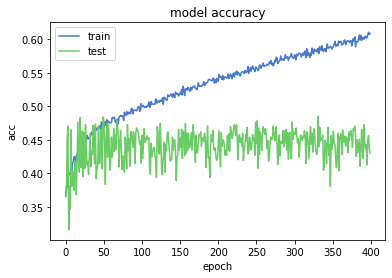

In [90]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [91]:
#save model
model_name = 'IEMOCAP_9_5MALE_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\ioann\saved_models\IEMOCAP_9_5MALE_Model.h5 


In [92]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [93]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/Users/ioann/saved_models/IEMOCAP_9_5MALE_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 42.98%


In [94]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

1033/1033 [==============================] - ETA:  - ETA:  - ETA:  - 0s 212us/step


In [95]:
preds1=preds.argmax(axis=1)
preds1

array([1, 1, 1, ..., 0, 2, 0], dtype=int64)

In [96]:
abc = preds1.astype(int).flatten()
predictions = (lb.inverse_transform((abc)))

In [97]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,oth
1,oth
2,oth
3,p
4,n
5,p
6,p
7,oth
8,n
9,n


In [98]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [99]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,p
1,n
2,n
3,n
4,n
5,n
6,n
7,n
8,p
9,n


In [100]:
finaldf = actualdf.join(preddf)
finaldf

,actualvalues,predictedvalues
0,p,oth
1,n,oth
2,n,oth
3,n,p
4,n,n
5,n,p
6,n,p
7,n,oth
8,p,n
9,n,n


In [101]:
y_true.astype(int)
y_pred.astype(int)


ValueError: invalid literal for int() with base 10: 'p'

In [102]:
from sklearn.metrics import confusion_matrix

from sklearn.metrics import confusion_matrix
confusion_matrix(actualvalues, predictions)

array([[191,  91,  97],
       [123,  82,  62],
       [109, 107, 171]], dtype=int64)

In [103]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
n,379
oth,267
p,387


In [104]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
n,423
oth,280
p,330


In [105]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [106]:
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
accuracy_score(y_true, y_pred)*100

42.981606969990324

In [107]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_true, y_pred)
c

array([[191,  91,  97],
       [123,  82,  62],
       [109, 107, 171]], dtype=int64)

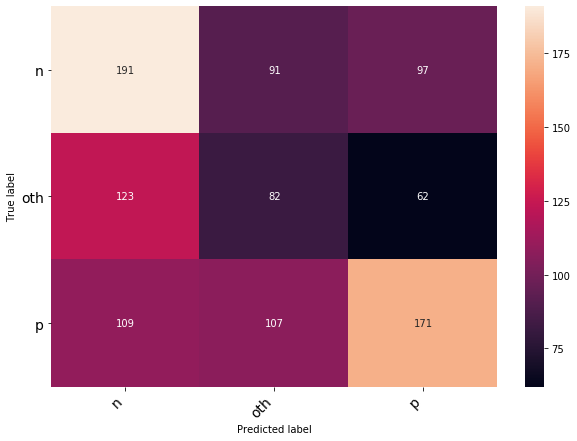

In [108]:
import seaborn as sns;
class_names = ["n", "oth", "p"]


print_confusion_matrix( c , class_names)